## Provide list of paths for edits and run trials -> (maybe analyze results and add to CSV)

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn
from utils.results_to_csv import store_csv
from edit_knn import main as edit

In [3]:
# Define constants, paths
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
class_list_path = 'metadata/cinic-10/class_names.txt'

analyze_in_edit = True
sort_type = 'softmax'

In [5]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

n_select = 100

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [6]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

In [7]:
# Obtain timestamp
paths_timestamp = '0126_161209'
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
# timestamp = '0120_155829'

In [ ]:
for target_class_idx, target_class_name in enumerate(class_list):
    if target_class_idx == 0: 
        continue
    # Create save directories and logging paths
    save_root = config_dict['trainer']['save_dir']
    save_trials_path = os.path.join(save_root, config_dict['name'], '{}_{}'.format(target_class_name, n_select), timestamp, 'trial_paths.txt')
    progress_report_path = os.path.join(save_root, config_dict['name'], '{}_{}'.format(target_class_name, n_select), timestamp, 'progress_report.txt')
    informal_log("Current target class: {}".format(target_class_name), progress_report_path)
    
    
    if os.path.exists(save_trials_path):
        print("Path {} already exists. Overwriting.".format(save_trials_path))
    else:
        if os.path.exists(progress_report_path):
            os.remove(progress_report_path)
        print("Printing progress reports to {}".format(progress_report_path))
        informal_log("Saving path to directories for each trial to {}".format(save_trials_path), progress_report_path)
    
    # Obtain paths for keys and values
    paths_dir = os.path.join('paths', 'edits', 'semantics', '{}_{}'.format(target_class_name, n_select), paths_timestamp)
    key_image_paths_path = os.path.join(paths_dir, 'key_images_{}.txt'.format(sort_type))
    key_image_paths = read_lists(key_image_paths_path)

    value_image_paths_path = os.path.join(paths_dir, 'value_images_{}.txt'.format(sort_type))
    value_image_paths = read_lists(value_image_paths_path)
    n_trials = len(value_image_paths)
    assert len(key_image_paths) == n_trials

    # print("{} edit image pairs".format(n_trials))
    # print("First key image path: {}".format(key_image_paths[0]))
    # print("First value image path: {}".format(value_image_paths[0]))
    
    # Ensure all keys and value paths exist
    non_existent_key_paths = []
    non_existent_value_paths = []
    for key_path, value_path in zip(key_image_paths, value_image_paths):
        if not os.path.exists(key_path):
            non_existent_key_paths.append(key_path)
        if not os.path.exists(value_path):
            non_existent_value_paths.append(value_path)

    if len(non_existent_key_paths) > 0:
        raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))

    if len(non_existent_value_paths) > 0:
        raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))
        
    informal_log("Key image paths stored at {}".format(key_image_paths_path), progress_report_path)
    informal_log("Value image paths stored at {}".format(value_image_paths_path), progress_report_path)
    
    # Run edit for each key and value pair
    for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
        split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
        class_name = os.path.basename(os.path.dirname(key_path))
        file_name = os.path.basename(key_path).split(".")[0]
        key_image_id = "{}-{}-{}".format(class_name, split, file_name)
        # Print Progress
        informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)

        # Create run id 
        value_image_id = os.path.splitext(os.path.basename(value_path))[0]
        run_id = os.path.join('{}_{}'.format(target_class_name, n_select), timestamp, 'results', key_image_id, value_image_id)
        informal_log("Current run_id: {}".format(run_id), progress_report_path)

        # Read config file as json and make updates to key and value paths
        config_dict = read_json(config_path)
        config_dict['editor'].update({
            'key_paths_file': key_path,
            'value_paths_file': value_path
        })

        # Create config object
        config = ConfigParser(config_dict, run_id=run_id)

        # Log the current trial path
        informal_log(os.path.dirname(config.save_dir), save_trials_path)

        informal_log("Calling edit()...", progress_report_path)

        edit(
            config=config,
            val_paths_data_loader=val_paths_data_loader,
            covariance_data_loader=covariance_data_loader,
            do_analyze_knn=analyze_in_edit)

        # Print progress
        informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                    progress_report_path)



Current target class: automobile
Printing progress reports to saved/edit/trials/CINIC10_ImageNet-VGG_16/automobile_100/0127_103716/progress_report.txt
Saving path to directories for each trial to saved/edit/trials/CINIC10_ImageNet-VGG_16/automobile_100/0127_103716/trial_paths.txt
Key image paths stored at paths/edits/semantics/automobile_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/automobile_100/0126_161209/value_images_softmax.txt
(0127_104004) Starting Trial 1/122...
Current run_id: automobile_100/0127_103716/results/automobile-train-n04037443_3590/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/automobile_100/0127_103716/results/automobile-train-n04037443_3590/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

  9%|██████▍                                                               | 25/274 [00:41<05:56,  1.43s/it]

In [33]:
# Define variables
# target_class_name = 'airplane'
# n_select = 100
# paths_dir = os.path.join('paths', 'edits', 'semantics', '{}_{}'.format(target_class_name, n_select), paths_timestamp)


In [ ]:
# key_image_paths_path = os.path.join(paths_dir, 'key_images_{}.txt'.format(sort_type))
# key_image_paths = read_lists(key_image_paths_path)

# value_image_paths_path = os.path.join(paths_dir, 'value_images_{}.txt'.format(sort_type))
# value_image_paths = read_lists(value_image_paths_path)
# n_trials = len(value_image_paths)
# assert len(key_image_paths) == n_trials

# print("{} edit image pairs".format(n_trials))
# print("First key image path: {}".format(key_image_paths[0]))
# print("First value image path: {}".format(value_image_paths[0]))

### Create log and save paths

In [37]:
# # create log path to store the paths to each trial
# save_root = config_dict['trainer']['save_dir']
# save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
# progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
# if os.path.exists(save_trials_path):
#     # os.remove(save_trials_path)
#     print("Path {} already exists. Aborting.".format(save_trials_path))
# else:
#     # progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
#     if os.path.exists(progress_report_path):
#         os.remove(progress_report_path)
#     print("Saving path to directories for each trial to {}".format(save_trials_path))
#     print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/trial_paths.txt
Printing progress reports to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/progress_report.txt


### Ensure all paths for keys and values exist

In [38]:
# non_existent_key_paths = []
# non_existent_value_paths = []
# for key_path, value_path in zip(key_image_paths, value_image_paths):
#     if not os.path.exists(key_path):
#         non_existent_key_paths.append(key_path)
#     if not os.path.exists(value_path):
#         non_existent_value_paths.append(value_path)

# if len(non_existent_key_paths) > 0:
#     raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))
    
# if len(non_existent_value_paths) > 0:
#     raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))
    

## Log where key and val image paths are from

In [39]:
# informal_log("Key image paths stored at {}".format(key_image_paths_path), progress_report_path)
# informal_log("Value image paths stored at {}".format(value_image_paths_path), progress_report_path)

Key image paths stored at paths/edits/semantics/airplane_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/airplane_100/0126_161209/value_images_softmax.txt


## Run edit for each modified image

(0126_170511) Starting Trial 1/158...
Current run_id: 0126_170417/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/airplane/n03365231_4635.png
Value images: saved/segmentations/semantics/airplane_100/airplane-train-n03365231_4635/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Performing pre-edit metric & KNN calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [05:21<00:00,  1.17s/it]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.80it/s]

Loss (orig, final): 0.07912948727607727 0.00577106699347496
L2 norm of weight change: 0.366611123085022
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.60it/s]


Post-edit metrics: {'TP': array([6587, 5244, 5306, 3925, 3953, 2633, 5609, 5285, 3315, 4431]), 'TN': array([56755, 61327, 58805, 59688, 60707, 62217, 61129, 61283, 62711,
       61666]), 'FPs': array([6245, 1673, 4195, 3312, 2293,  783, 1871, 1717,  289, 1334]), 'FNs': array([ 413, 1756, 1694, 3075, 3047, 4367, 1391, 1715, 3685, 2569]), 'accuracy': 0.6612571428571429, 'per_class_accuracy': array([0.90488571, 0.95101429, 0.91587143, 0.90875714, 0.92371429,
       0.92642857, 0.9534    , 0.95097143, 0.94322857, 0.94424286]), 'per_class_accuracy_mean': 0.9322514285714286, 'precision': array([0.51332606, 0.75813214, 0.55846753, 0.5423518 , 0.63288505,
       0.77078454, 0.74986631, 0.75478435, 0.91981132, 0.76860364]), 'precision_mean': 0.6969012741698691, 'recall': array([0.941     , 0.74914286, 0.758     , 0.56071429, 0.56471429,
       0.37614286, 0.80128571, 0.755     , 0.47357143, 0.633     ]), 'recall_mean': 0.6612571428571429, 'predicted_class_distribution': array([12832,  6917,  95

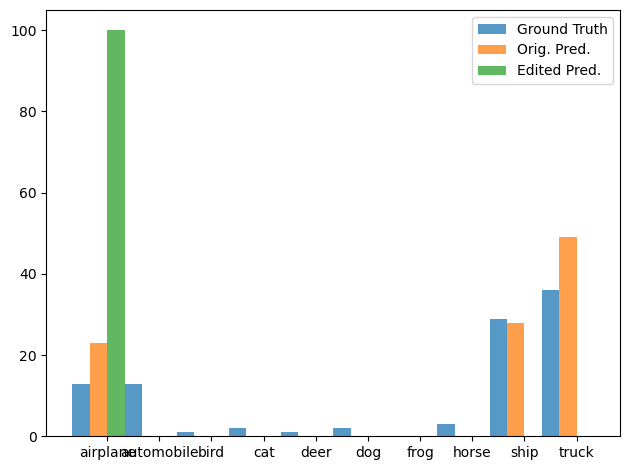

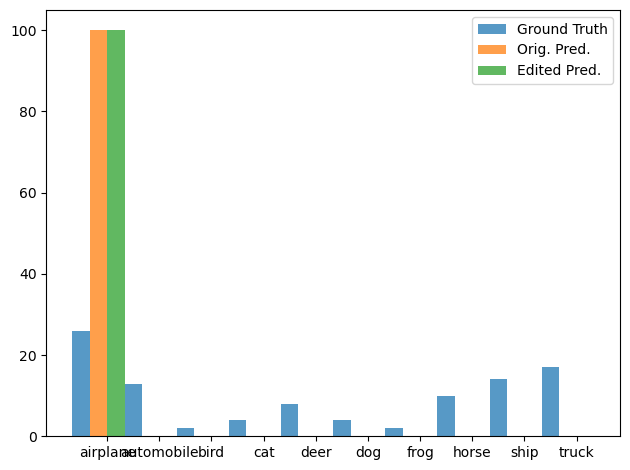

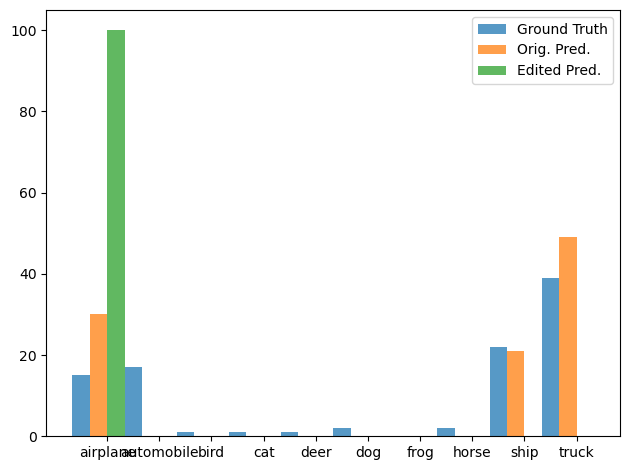

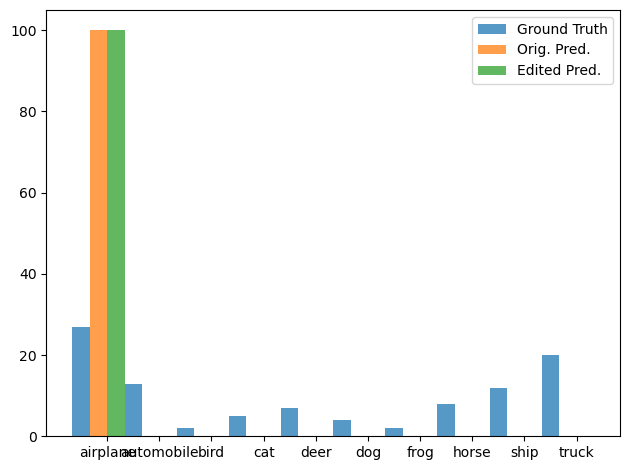

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax/models
Finished trial 1/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax
(0126_171134) Starting Trial 2/158...
Current run_id: 0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 57.12it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:46<00:00, 867.16it/s]

Loss (orig, final): 0.19817081093788147 0.012747062370181084
L2 norm of weight change: 0.9437420964241028
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.14it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6966, 4547, 3293,  436,    0,   73, 4578, 3832,    0, 3099]), 'TN': array([22533, 61953, 62554, 62839, 63000, 63000, 62568, 62734, 63000,
       62643]), 'FPs': array([40467,  1047,   446,   161,     0,     0,   432,   266,     0,
         357]), 'FNs': array([  34, 2453, 3707, 6564, 7000, 6927, 2422, 3168, 7000, 3901]), 'accuracy': 0.3832, 'per_class_accuracy': array([0.42141429, 0.95      , 0.94067143, 0.90392857, 0.9       ,
       0.90104286, 0.95922857, 0.95094286, 0.9       , 0.93917143]), 'per_class_accuracy_mean': 0.8766400000000001, 'precision': array([0.14685978, 0.81283518, 0.88071677, 0.73031826, 0.        ,
       1.        , 0.91377246, 0.93509029, 0.        , 0.89670139]), 'precision_mean': 0.6316294120785721, 'recall': array([0.99514286, 0.64957143, 0.47042857, 0.06228571, 0.        ,
       0.01042857, 0.654     , 0.54742857, 0.        , 0.44271429]), 'recall_mean': 0.3832, 'predicted_class_distribution': array([47433,  5594,  3739,   5

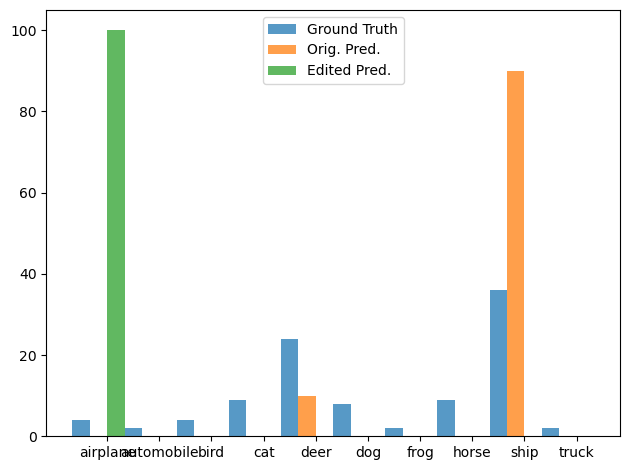

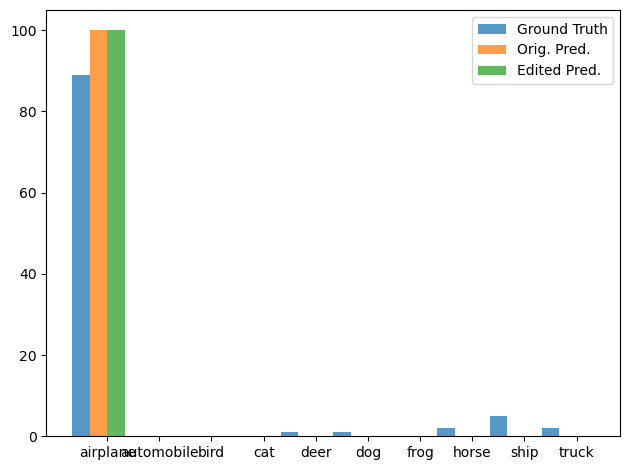

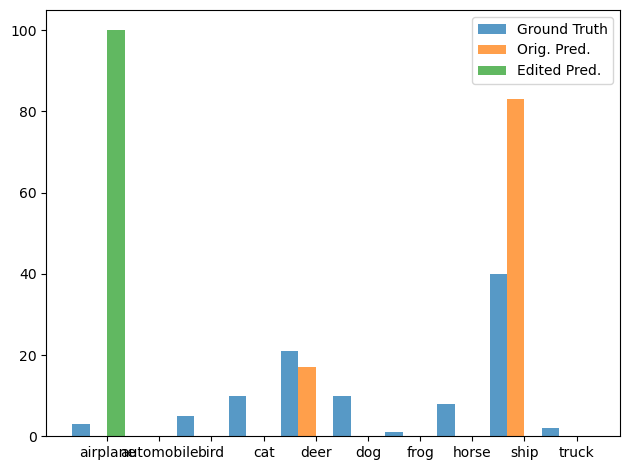

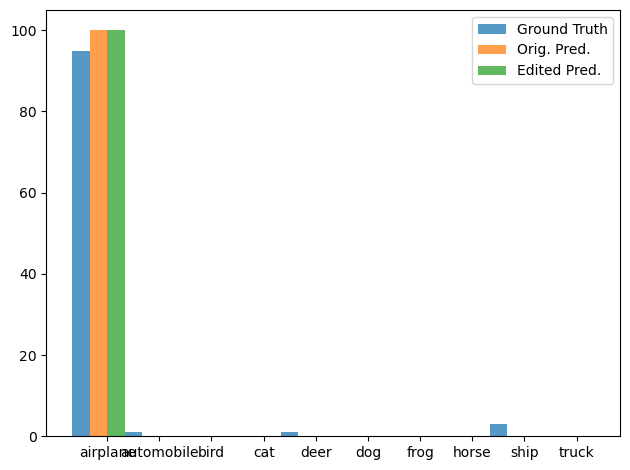

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax/models
Finished trial 2/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax
(0126_171240) Starting Trial 3/158...
Current run_id: 0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validatio

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0169, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.29it/s]

Loss (orig, final): 0.13332810997962952 0.016893260180950165
L2 norm of weight change: 0.5770063400268555
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.34it/s]


Post-edit metrics: {'TP': array([6661, 5553, 5093, 2802,    3, 2463, 5369, 4894, 3508, 4210]), 'TN': array([45711, 60135, 59508, 61716, 63000, 62371, 61682, 61977, 62645,
       61811]), 'FPs': array([17289,  2865,  3492,  1284,     0,   629,  1318,  1023,   355,
        1189]), 'FNs': array([ 339, 1447, 1907, 4198, 6997, 4537, 1631, 2106, 3492, 2790]), 'accuracy': 0.5793714285714285, 'per_class_accuracy': array([0.74817143, 0.9384    , 0.92287143, 0.92168571, 0.90004286,
       0.9262    , 0.95787143, 0.9553    , 0.94504286, 0.94315714]), 'per_class_accuracy_mean': 0.9158742857142859, 'precision': array([0.27812109, 0.65965788, 0.59324403, 0.68575624, 1.        ,
       0.7965718 , 0.80290115, 0.82710833, 0.90810251, 0.77977403]), 'precision_mean': 0.7331237057514535, 'recall': array([9.51571429e-01, 7.93285714e-01, 7.27571429e-01, 4.00285714e-01,
       4.28571429e-04, 3.51857143e-01, 7.67000000e-01, 6.99142857e-01,
       5.01142857e-01, 6.01428571e-01]), 'recall_mean': 0.5793714285

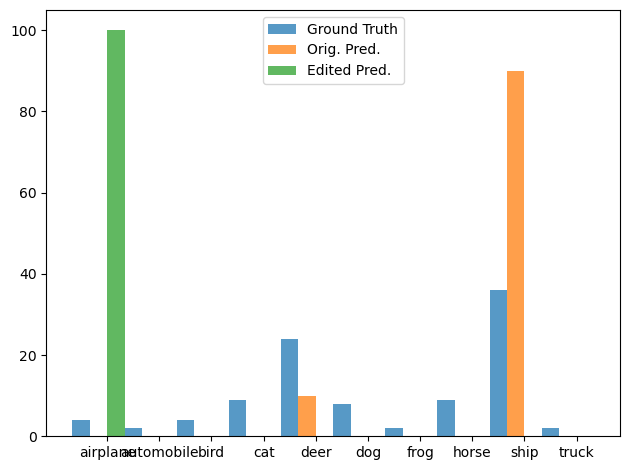

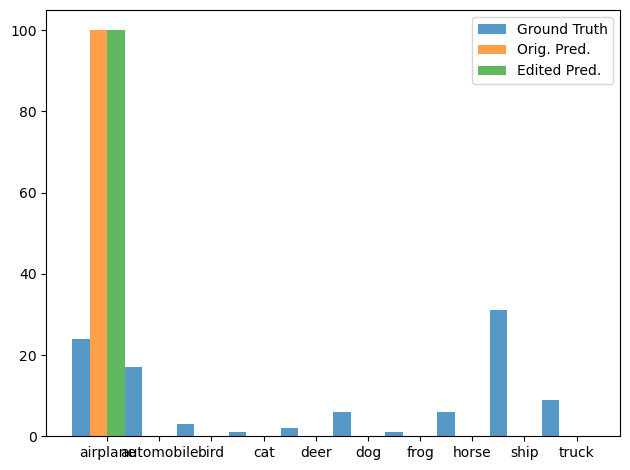

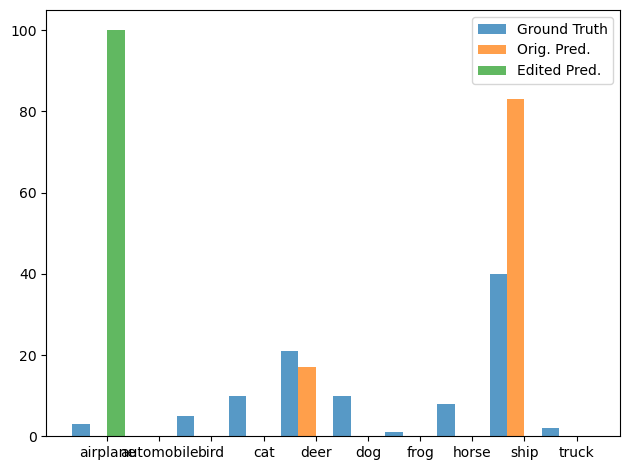

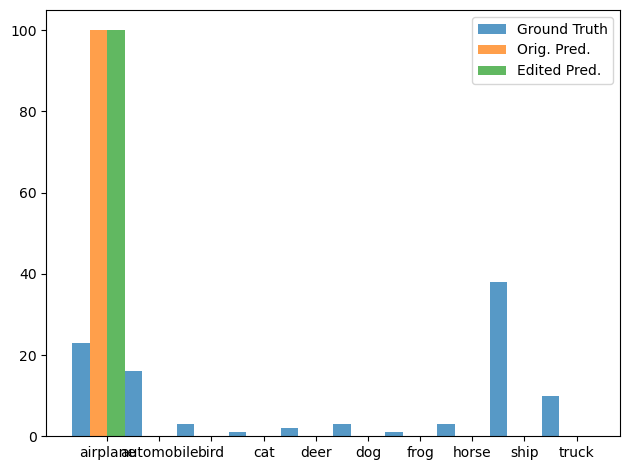

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax/models
Finished trial 3/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax
(0126_171346) Starting Trial 4/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validatio

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.75it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.10it/s]

Loss (orig, final): 0.0834680050611496 0.004560583736747503
L2 norm of weight change: 0.4280029535293579
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.25it/s]


Post-edit metrics: {'TP': array([6764, 5094, 4927, 3784, 4119, 2399, 5537, 5461, 1257, 4693]), 'TN': array([53401, 61492, 60075, 60174, 60305, 62437, 61395, 60526, 62980,
       61250]), 'FPs': array([9599, 1508, 2925, 2826, 2695,  563, 1605, 2474,   20, 1750]), 'FNs': array([ 236, 1906, 2073, 3216, 2881, 4601, 1463, 1539, 5743, 2307]), 'accuracy': 0.6290714285714286, 'per_class_accuracy': array([0.8595    , 0.95122857, 0.9286    , 0.91368571, 0.92034286,
       0.92622857, 0.95617143, 0.94267143, 0.91767143, 0.94204286]), 'per_class_accuracy_mean': 0.9258142857142857, 'precision': array([0.41337163, 0.77158437, 0.62748344, 0.57246596, 0.60449075,
       0.80992573, 0.77527303, 0.68821676, 0.98433829, 0.7283874 ]), 'precision_mean': 0.6975537368054412, 'recall': array([0.96628571, 0.72771429, 0.70385714, 0.54057143, 0.58842857,
       0.34271429, 0.791     , 0.78014286, 0.17957143, 0.67042857]), 'recall_mean': 0.6290714285714285, 'predicted_class_distribution': array([16363,  6602,  78

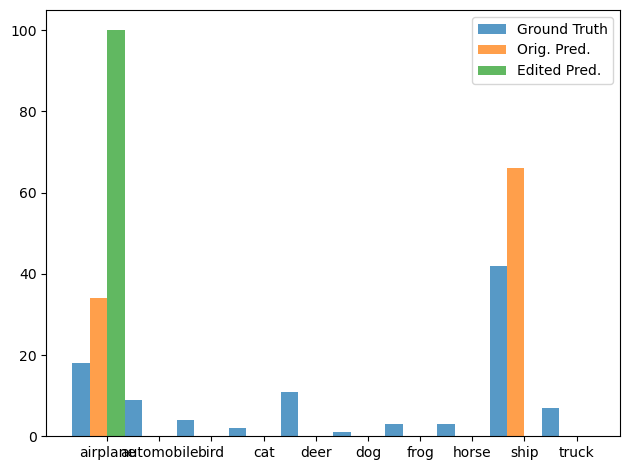

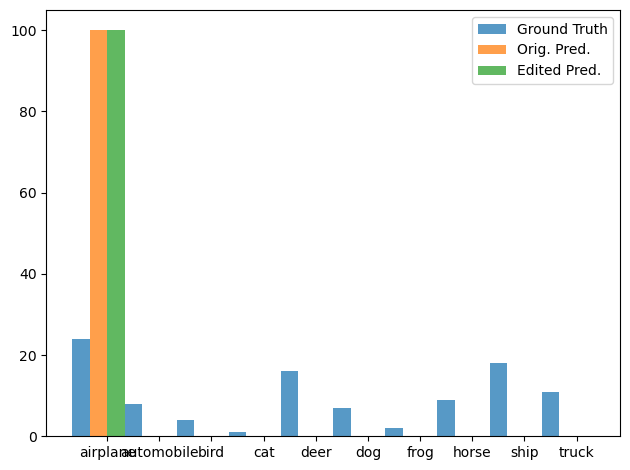

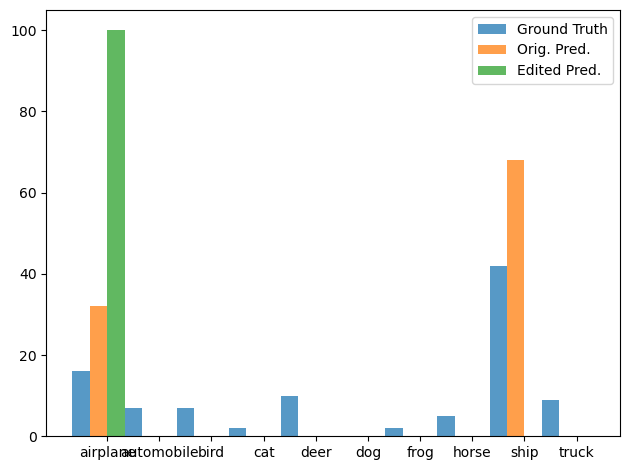

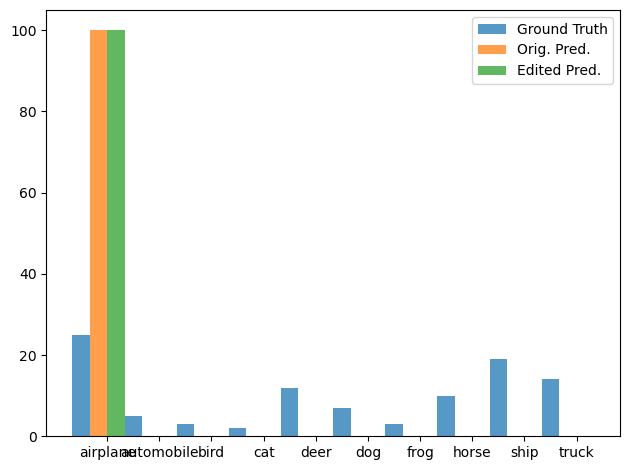

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax/models
Finished trial 4/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax
(0126_171458) Starting Trial 5/158...
Current run_id: 0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.31it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:44<00:00, 891.55it/s]

Loss (orig, final): 0.1968313455581665 0.0252482108771801
L2 norm of weight change: 0.6691174507141113
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.98it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6571, 5315,    0, 3844, 4091, 2650, 5272, 4866, 4424, 4596]), 'TN': array([47719, 61174, 63000, 60007, 60424, 62206, 61810, 62003, 62008,
       61278]), 'FPs': array([15281,  1826,     0,  2993,  2576,   794,  1190,   997,   992,
        1722]), 'FNs': array([ 429, 1685, 7000, 3156, 2909, 4350, 1728, 2134, 2576, 2404]), 'accuracy': 0.5947, 'per_class_accuracy': array([0.77557143, 0.94984286, 0.9       , 0.91215714, 0.92164286,
       0.92651429, 0.95831429, 0.95527143, 0.94902857, 0.94105714]), 'per_class_accuracy_mean': 0.9189399999999999, 'precision': array([0.30070474, 0.74429352, 0.        , 0.5622349 , 0.61361932,
       0.76945412, 0.81584649, 0.82995054, 0.816839  , 0.72744539]), 'precision_mean': 0.6180388011897021, 'recall': array([0.93871429, 0.75928571, 0.        , 0.54914286, 0.58442857,
       0.37857143, 0.75314286, 0.69514286, 0.632     , 0.65657143]), 'recall_mean': 0.5947, 'predicted_class_distribution': array([21852,  7141,     0,  68

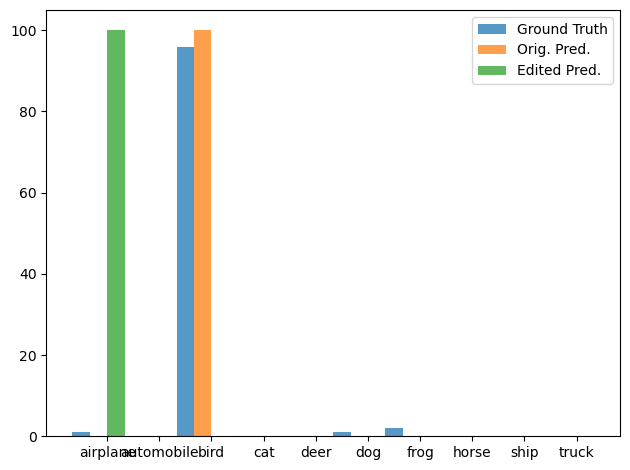

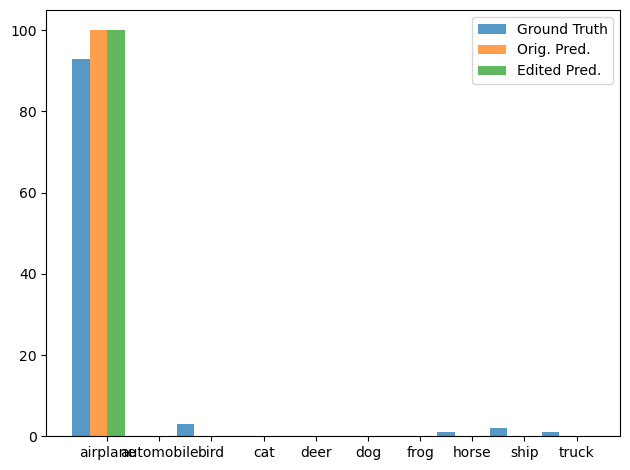

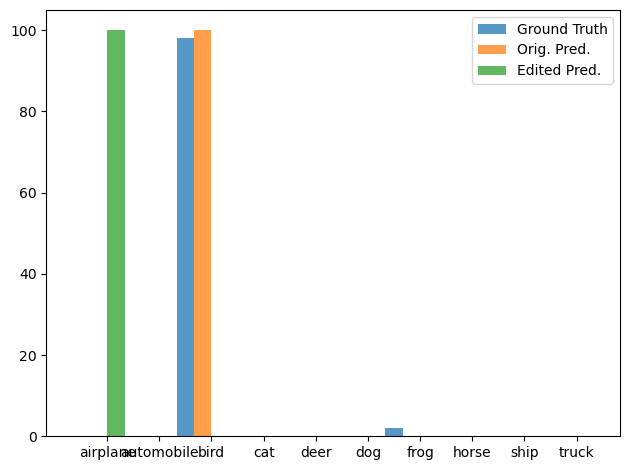

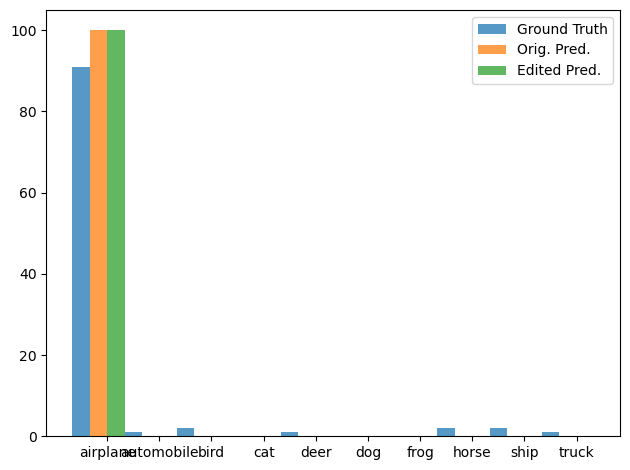

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax/models
Finished trial 5/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax
(0126_171604) Starting Trial 6/158...
Current run_id: 0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Ke

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.93it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.61it/s]

Loss (orig, final): 0.1716325581073761 0.023746907711029053
L2 norm of weight change: 0.529190719127655
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.14it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6537, 5320,    0, 3892, 4156, 2694, 5436, 4912, 4499, 4616]), 'TN': array([48834, 61173, 63000, 59905, 60291, 62150, 61596, 61931, 61942,
       61240]), 'FPs': array([14166,  1827,     0,  3095,  2709,   850,  1404,  1069,  1058,
        1760]), 'FNs': array([ 463, 1680, 7000, 3108, 2844, 4306, 1564, 2088, 2501, 2384]), 'accuracy': 0.6008857142857142, 'per_class_accuracy': array([0.79101429, 0.9499    , 0.9       , 0.91138571, 0.92067143,
       0.92634286, 0.9576    , 0.9549    , 0.94915714, 0.9408    ]), 'per_class_accuracy_mean': 0.9201771428571428, 'precision': array([0.31575134, 0.74436827, 0.        , 0.55703449, 0.60538966,
       0.76015801, 0.79473684, 0.82126735, 0.8096095 , 0.72396487]), 'precision_mean': 0.613228032913641, 'recall': array([0.93385714, 0.76      , 0.        , 0.556     , 0.59371429,
       0.38485714, 0.77657143, 0.70171429, 0.64271429, 0.65942857]), 'recall_mean': 0.6008857142857142, 'predicted_class_distribution': array([2

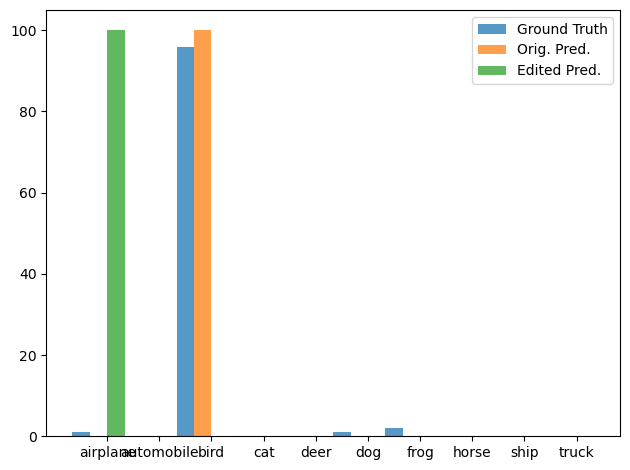

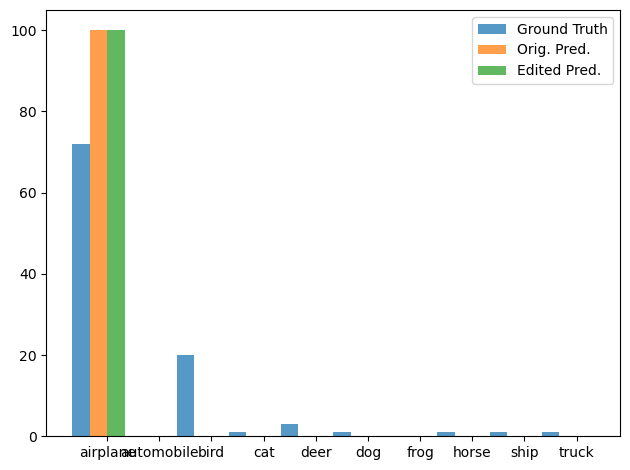

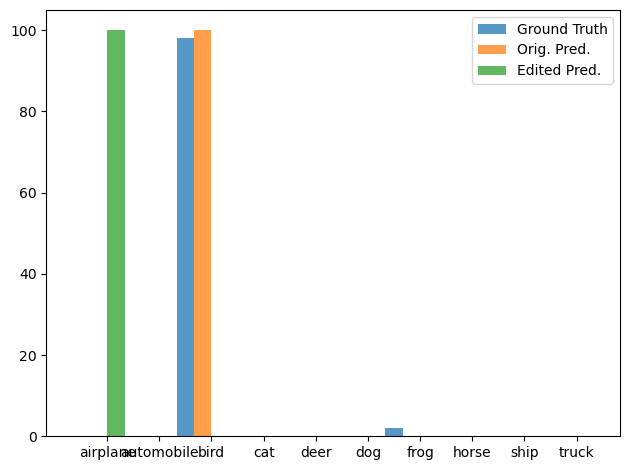

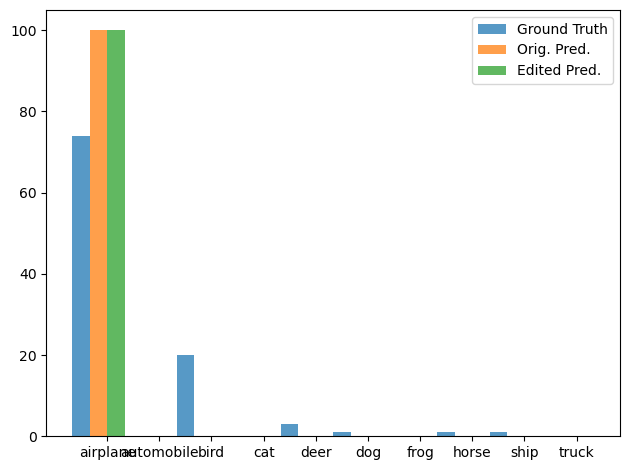

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_gaussian_softmax/models
Finished trial 6/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308397_2932/felzenszwalb_gaussian_softmax
(0126_171713) Starting Trial 7/158...
Current run_id: 0126_170417/results/airplane-train-n04012482_1683/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_1683/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0145, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.17it/s]

Loss (orig, final): 0.1440255343914032 0.014487319625914097
L2 norm of weight change: 0.44399747252464294
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.46it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6447, 5450,    0, 3964, 4226, 2892, 5690, 5085, 4653, 4675]), 'TN': array([51759, 60819, 63000, 59779, 60161, 61899, 61106, 61722, 61804,
       61033]), 'FPs': array([11241,  2181,     0,  3221,  2839,  1101,  1894,  1278,  1196,
        1967]), 'FNs': array([ 553, 1550, 7000, 3036, 2774, 4108, 1310, 1915, 2347, 2325]), 'accuracy': 0.6154571428571428, 'per_class_accuracy': array([0.83151429, 0.9467    , 0.9       , 0.91061429, 0.91981429,
       0.92558571, 0.95422857, 0.95438571, 0.94938571, 0.93868571]), 'per_class_accuracy_mean': 0.9230914285714287, 'precision': array([0.3644844 , 0.71419211, 0.        , 0.55170494, 0.59815994,
       0.72426747, 0.75026371, 0.79915134, 0.7955206 , 0.70385426]), 'precision_mean': 0.6001598778990543, 'recall': array([0.921     , 0.77857143, 0.        , 0.56628571, 0.60371429,
       0.41314286, 0.81285714, 0.72642857, 0.66471429, 0.66785714]), 'recall_mean': 0.6154571428571429, 'predicted_class_distribution': array([

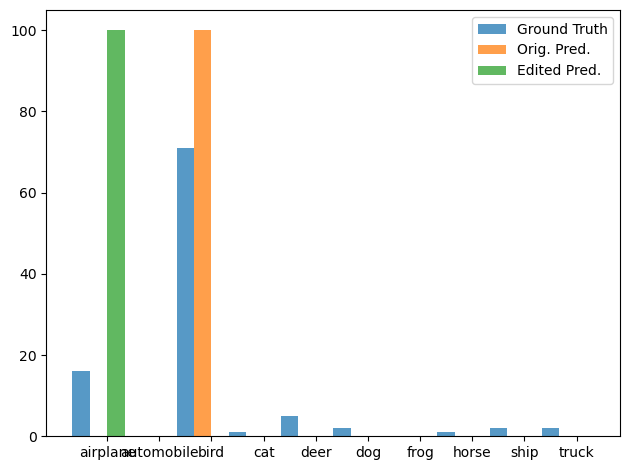

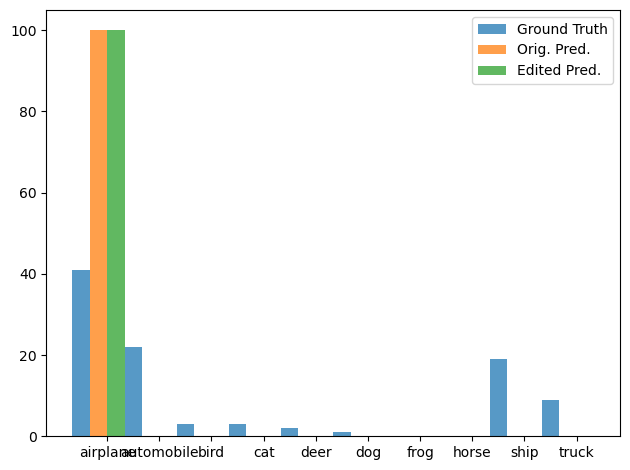

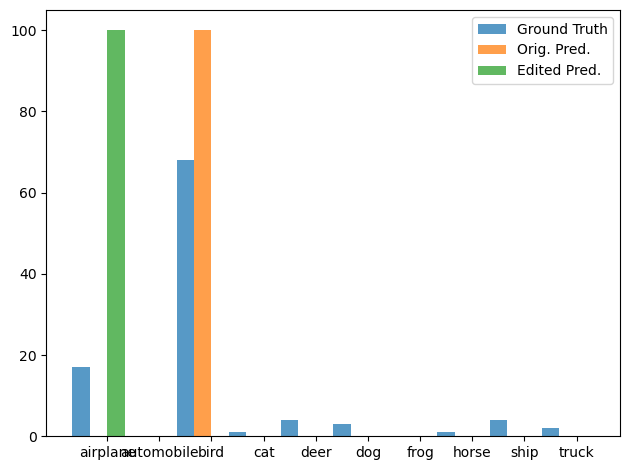

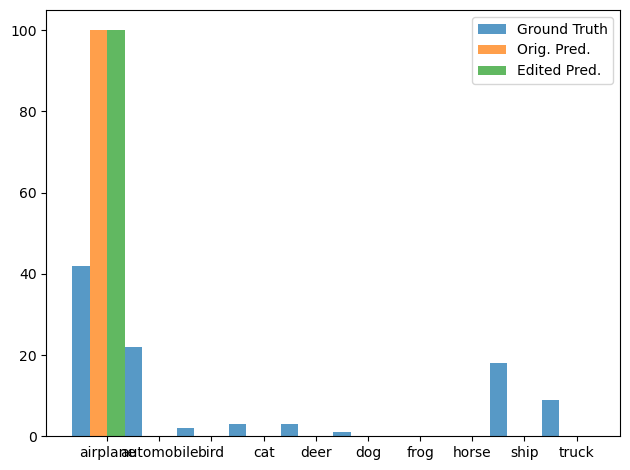

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_1683/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_1683/felzenszwalb_masked_softmax/models
Finished trial 7/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_1683/felzenszwalb_masked_softmax
(0126_171827) Starting Trial 8/158...
Current run_id: 0126_170417/results/airplane-train-n04222723_5958/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_5958/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.33it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:46<00:00, 861.17it/s]

Loss (orig, final): 0.17762309312820435 0.005775872617959976
L2 norm of weight change: 0.7443973422050476
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.71it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6873, 4562, 4959, 3885, 3670, 2175, 5450, 5291,    0, 3572]), 'TN': array([47291, 61938, 59757, 59897, 61092, 62599, 61548, 60896, 63000,
       62419]), 'FPs': array([15709,  1062,  3243,  3103,  1908,   401,  1452,  2104,     0,
         581]), 'FNs': array([ 127, 2438, 2041, 3115, 3330, 4825, 1550, 1709, 7000, 3428]), 'accuracy': 0.5776714285714286, 'per_class_accuracy': array([0.77377143, 0.95      , 0.92451429, 0.91117143, 0.92517143,
       0.92534286, 0.95711429, 0.94552857, 0.9       , 0.94272857]), 'per_class_accuracy_mean': 0.9155342857142857, 'precision': array([0.30435745, 0.81116643, 0.60460863, 0.55595306, 0.65794191,
       0.8443323 , 0.7896262 , 0.71548343, 0.        , 0.86010113]), 'precision_mean': 0.6143570551432, 'recall': array([0.98185714, 0.65171429, 0.70842857, 0.555     , 0.52428571,
       0.31071429, 0.77857143, 0.75585714, 0.        , 0.51028571]), 'recall_mean': 0.5776714285714286, 'predicted_class_distribution': array([225

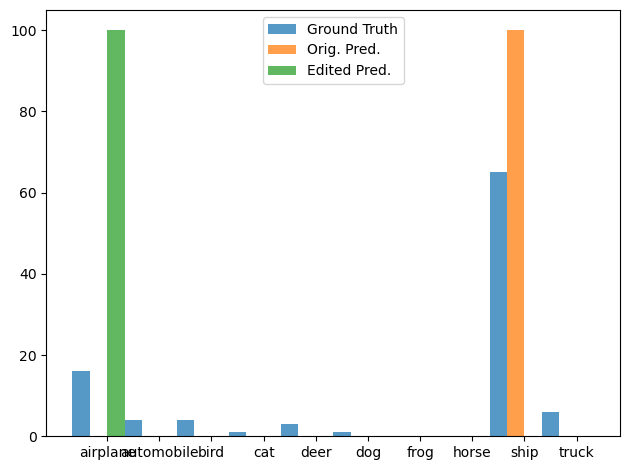

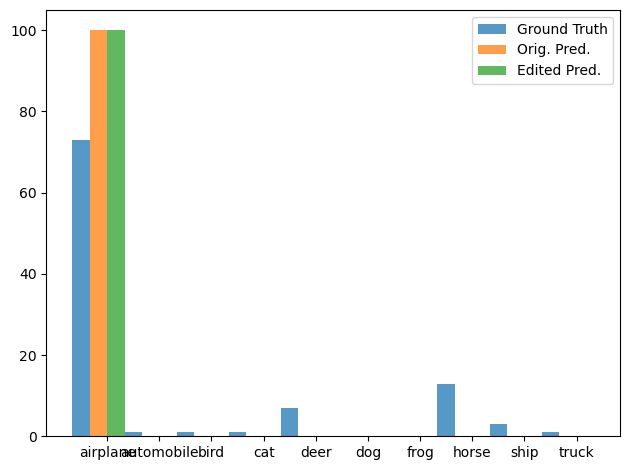

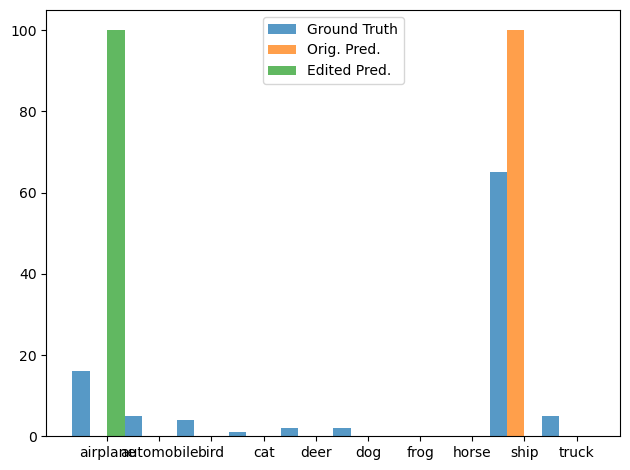

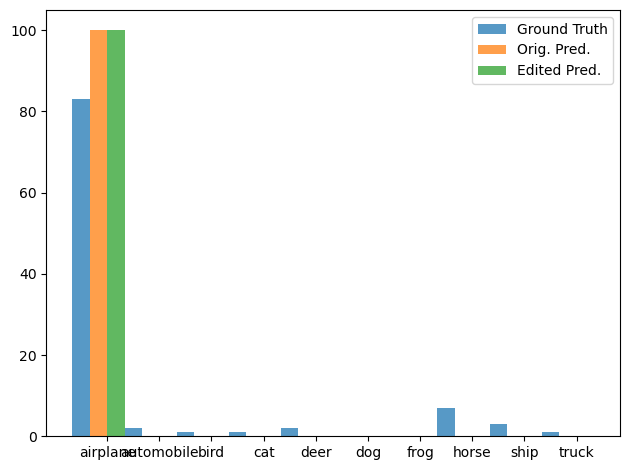

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_5958/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_5958/felzenszwalb_masked_softmax/models
Finished trial 8/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_5958/felzenszwalb_masked_softmax
(0126_171932) Starting Trial 9/158...
Current run_id: 0126_170417/results/airplane-train-n04308273_715/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key imag

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.05it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 883.76it/s]

Loss (orig, final): 0.16258466243743896 0.005869721993803978
L2 norm of weight change: 0.6710118651390076
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [04:27<00:00,  1.02it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6620, 5095,    0, 3766, 4130, 2400, 5198, 4636, 4390, 4660]), 'TN': array([46174, 61476, 63000, 60138, 60279, 62452, 61922, 62225, 62021,
       61208]), 'FPs': array([16826,  1524,     0,  2862,  2721,   548,  1078,   775,   979,
        1792]), 'FNs': array([ 380, 1905, 7000, 3234, 2870, 4600, 1802, 2364, 2610, 2340]), 'accuracy': 0.5842142857142857, 'per_class_accuracy': array([0.7542    , 0.95101429, 0.9       , 0.91291429, 0.92012857,
       0.92645714, 0.95885714, 0.95515714, 0.94872857, 0.94097143]), 'per_class_accuracy_mean': 0.9168428571428571, 'precision': array([0.28235093, 0.76975374, 0.        , 0.56819553, 0.6028317 ,
       0.81411126, 0.82823454, 0.85677324, 0.81765692, 0.72225666]), 'precision_mean': 0.626216454061257, 'recall': array([0.94571429, 0.72785714, 0.        , 0.538     , 0.59      ,
       0.34285714, 0.74257143, 0.66228571, 0.62714286, 0.66571429]), 'recall_mean': 0.5842142857142857, 'predicted_class_distribution': array([2

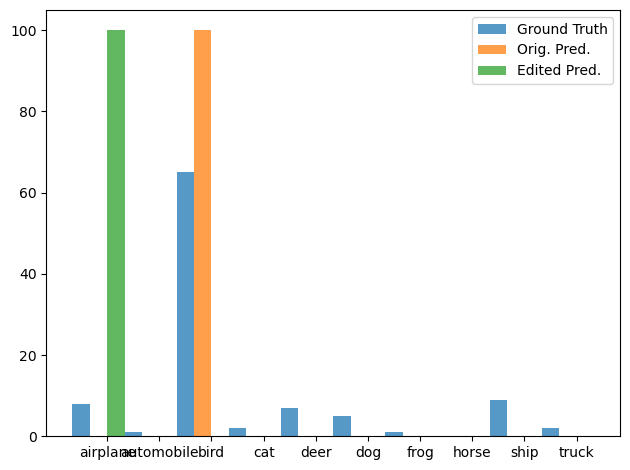

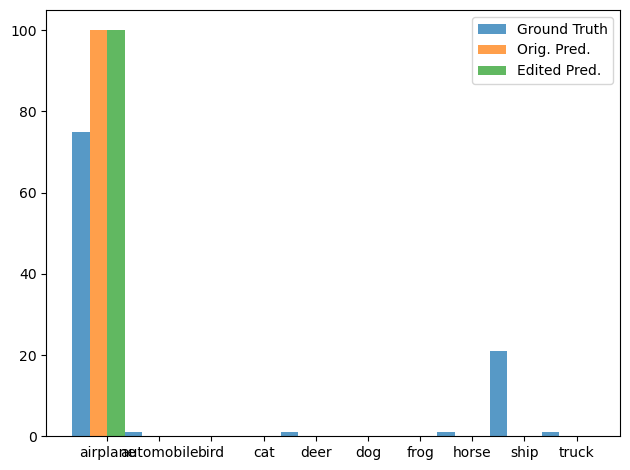

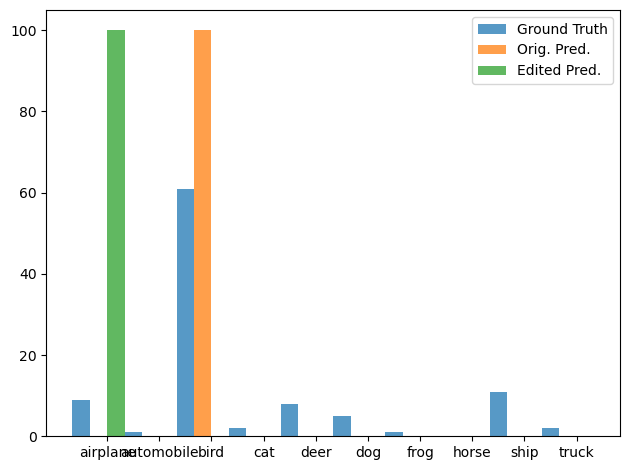

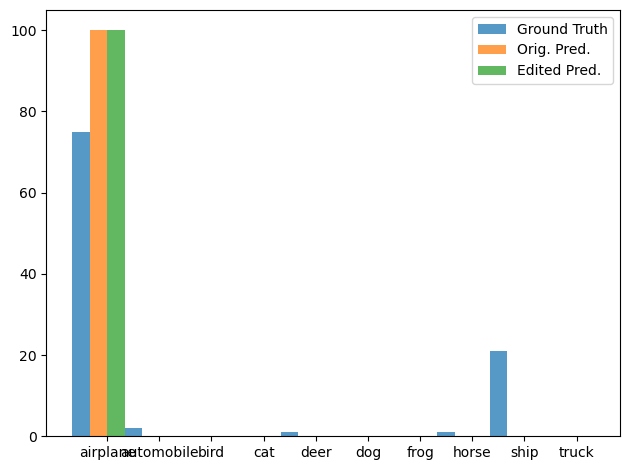

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_masked_softmax/models
Finished trial 9/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_masked_softmax
(0126_172457) Starting Trial 10/158...
Current run_id: 0126_170417/results/airplane-train-n04308273_715/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:24<00:00, 11.22it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.50it/s]

Loss (orig, final): 0.09875106811523438 0.004187275189906359
L2 norm of weight change: 0.3923141658306122
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.38it/s]


Post-edit metrics: {'TP': array([6550, 5161, 3258, 3959, 4317, 2521, 5614, 4943, 4431, 4725]), 'TN': array([53463, 61437, 62382, 59711, 59939, 62331, 61227, 61848, 62019,
       61122]), 'FPs': array([9537, 1563,  618, 3289, 3061,  669, 1773, 1152,  981, 1878]), 'FNs': array([ 450, 1839, 3742, 3041, 2683, 4479, 1386, 2057, 2569, 2275]), 'accuracy': 0.6497, 'per_class_accuracy': array([0.85732857, 0.9514    , 0.93771429, 0.90957143, 0.91794286,
       0.92645714, 0.95487143, 0.95415714, 0.94928571, 0.94067143]), 'per_class_accuracy_mean': 0.92994, 'precision': array([0.40716106, 0.76754908, 0.84055728, 0.54621965, 0.58511792,
       0.79028213, 0.75998376, 0.81099262, 0.81873614, 0.71558383]), 'precision_mean': 0.7042183451379536, 'recall': array([0.93571429, 0.73728571, 0.46542857, 0.56557143, 0.61671429,
       0.36014286, 0.802     , 0.70614286, 0.633     , 0.675     ]), 'recall_mean': 0.6496999999999999, 'predicted_class_distribution': array([16087,  6724,  3876,  7248,  7378,  3190

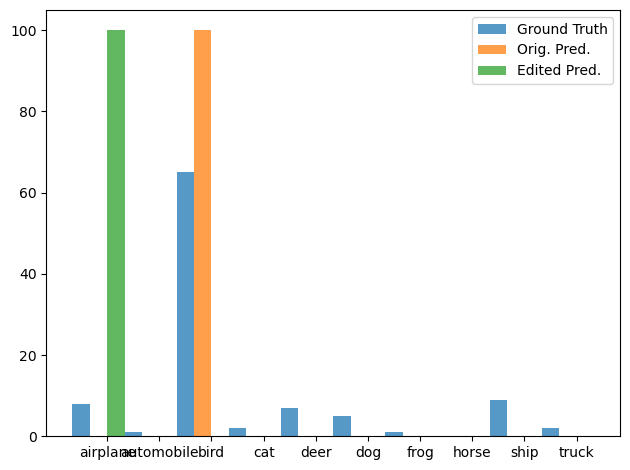

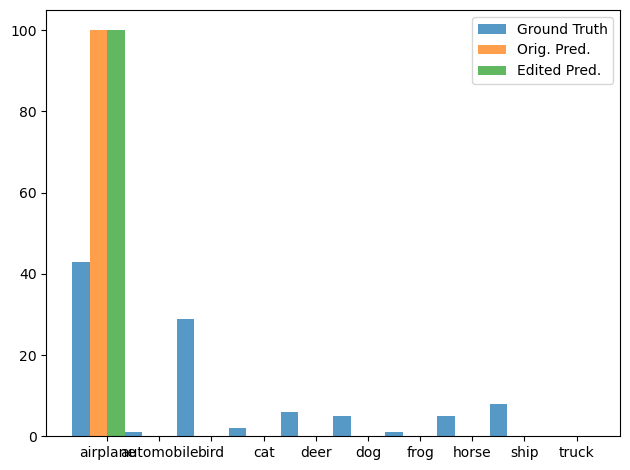

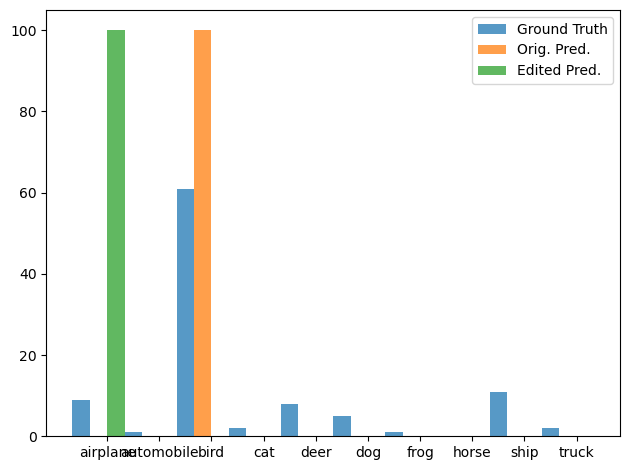

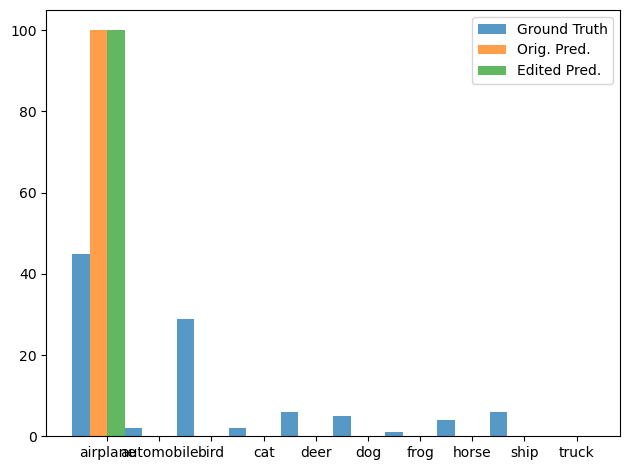

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_gaussian_softmax/models
Finished trial 10/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_715/felzenszwalb_gaussian_softmax
(0126_172626) Starting Trial 11/158...
Current run_id: 0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
K

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.58it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.19it/s]

Loss (orig, final): 0.15188205242156982 0.004507591016590595
L2 norm of weight change: 0.681854784488678
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.79it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6735, 4858, 5295, 3500, 3987, 2808, 5283, 4534, 3231,    0]), 'TN': array([46820, 61731, 58527, 60790, 60523, 62033, 61807, 62261, 62739,
       63000]), 'FPs': array([16180,  1269,  4473,  2210,  2477,   967,  1193,   739,   261,
           0]), 'FNs': array([ 265, 2142, 1705, 3500, 3013, 4192, 1717, 2466, 3769, 7000]), 'accuracy': 0.5747285714285715, 'per_class_accuracy': array([0.76507143, 0.95127143, 0.91174286, 0.91842857, 0.92157143,
       0.9263    , 0.95842857, 0.95421429, 0.94242857, 0.9       ]), 'per_class_accuracy_mean': 0.9149457142857143, 'precision': array([0.29391228, 0.79288396, 0.54207617, 0.61295972, 0.61680074,
       0.74384106, 0.81578135, 0.85985208, 0.92525773, 0.        ]), 'precision_mean': 0.6203365084917561, 'recall': array([0.96214286, 0.694     , 0.75642857, 0.5       , 0.56957143,
       0.40114286, 0.75471429, 0.64771429, 0.46157143, 0.        ]), 'recall_mean': 0.5747285714285715, 'predicted_class_distribution': array([

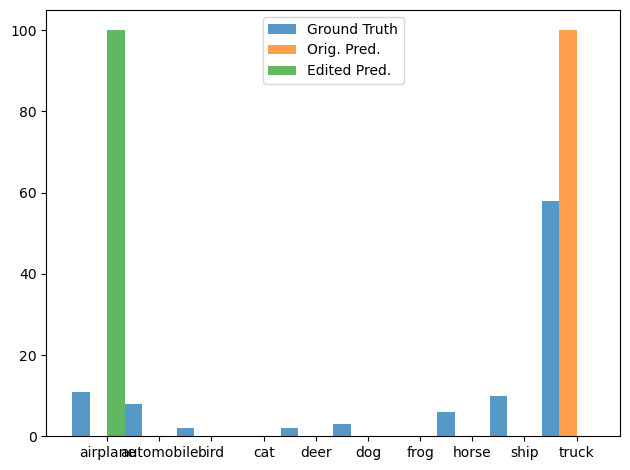

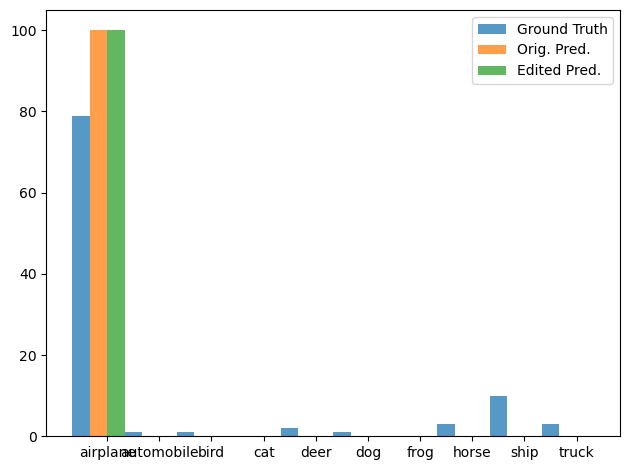

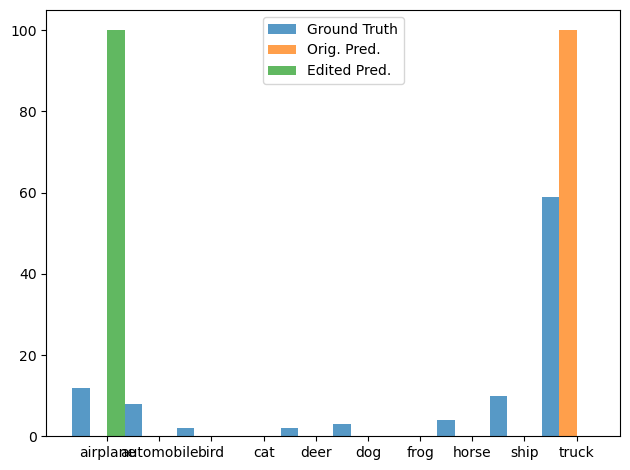

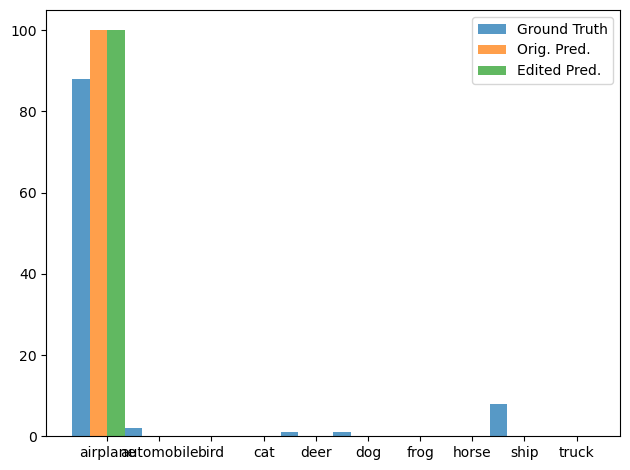

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_masked_softmax/models
Finished trial 11/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_masked_softmax
(0126_172736) Starting Trial 12/158...
Current run_id: 0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.17it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 886.07it/s]

Loss (orig, final): 0.10013306140899658 0.010520359501242638
L2 norm of weight change: 0.353396475315094
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.90it/s]


Post-edit metrics: {'TP': array([6453, 5671, 5306, 3542, 4065, 3028, 5592, 4984, 4334, 3748]), 'TN': array([57229, 60502, 58807, 60576, 60491, 61739, 61158, 61876, 62067,
       62278]), 'FPs': array([5771, 2498, 4193, 2424, 2509, 1261, 1842, 1124,  933,  722]), 'FNs': array([ 547, 1329, 1694, 3458, 2935, 3972, 1408, 2016, 2666, 3252]), 'accuracy': 0.6674714285714286, 'per_class_accuracy': array([0.90974286, 0.94532857, 0.9159    , 0.91597143, 0.92222857,
       0.92524286, 0.95357143, 0.95514286, 0.94858571, 0.94322857]), 'per_class_accuracy_mean': 0.9334942857142858, 'precision': array([0.52789594, 0.69420982, 0.55858511, 0.59369762, 0.618345  ,
       0.70599207, 0.75221953, 0.81597904, 0.82285931, 0.83847875]), 'precision_mean': 0.6928262197923389, 'recall': array([0.92185714, 0.81014286, 0.758     , 0.506     , 0.58071429,
       0.43257143, 0.79885714, 0.712     , 0.61914286, 0.53542857]), 'recall_mean': 0.6674714285714286, 'predicted_class_distribution': array([12224,  8169,  94

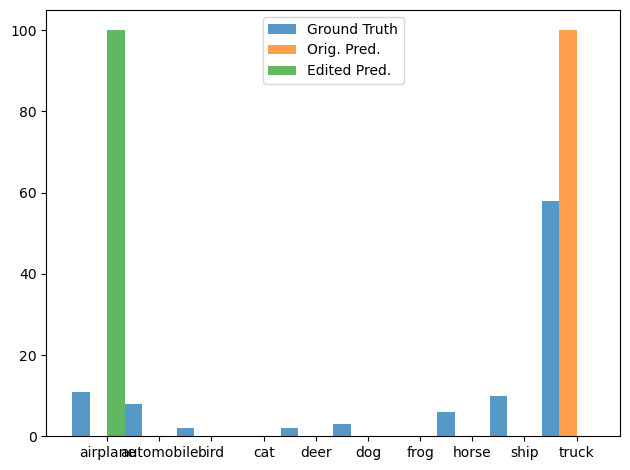

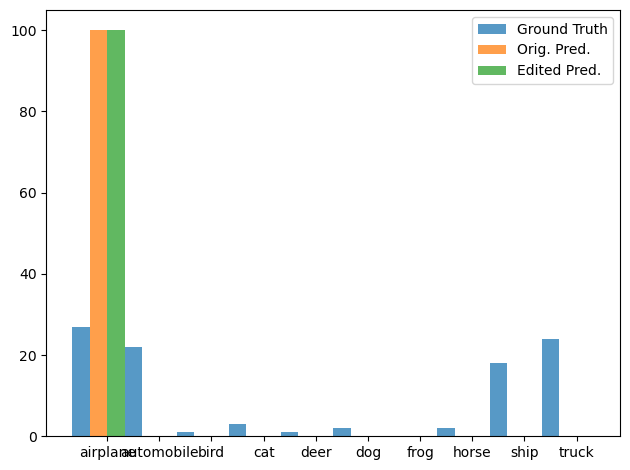

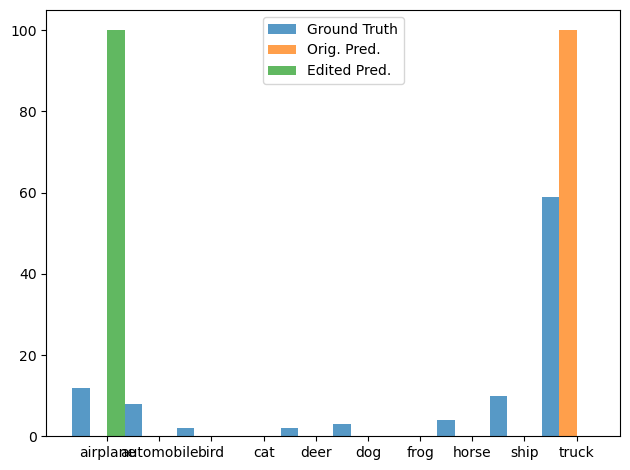

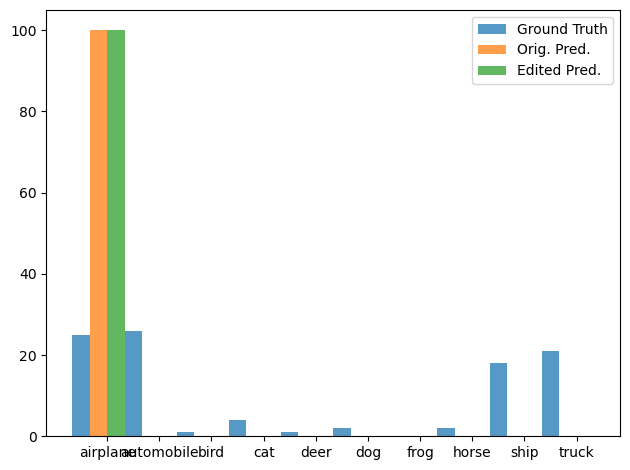

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_gaussian_softmax/models
Finished trial 12/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_2174/felzenszwalb_gaussian_softmax
(0126_172853) Starting Trial 13/158...
Current run_id: 0126_170417/results/airplane-train-n04308273_5662/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_5662/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.44it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 883.21it/s]

Loss (orig, final): 0.09689173847436905 0.0073289209976792336
L2 norm of weight change: 0.4090054929256439
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.76it/s]


Post-edit metrics: {'TP': array([6372, 4958, 4980, 4160, 4252, 2806, 5503, 4253, 5023, 4256]), 'TN': array([57111, 61619, 59967, 59083, 60090, 61962, 61429, 62566, 60866,
       61870]), 'FPs': array([5889, 1381, 3033, 3917, 2910, 1038, 1571,  434, 2134, 1130]), 'FNs': array([ 628, 2042, 2020, 2840, 2748, 4194, 1497, 2747, 1977, 2744]), 'accuracy': 0.6651857142857143, 'per_class_accuracy': array([0.9069    , 0.9511    , 0.92781429, 0.90347143, 0.91917143,
       0.92525714, 0.95617143, 0.95455714, 0.94127143, 0.94465714]), 'per_class_accuracy_mean': 0.9330371428571429, 'precision': array([0.5196966 , 0.78214229, 0.62149008, 0.51504271, 0.59368891,
       0.72996878, 0.77791914, 0.90740346, 0.70183038, 0.79019681]), 'precision_mean': 0.693937916071466, 'recall': array([0.91028571, 0.70828571, 0.71142857, 0.59428571, 0.60742857,
       0.40085714, 0.78614286, 0.60757143, 0.71757143, 0.608     ]), 'recall_mean': 0.6651857142857143, 'predicted_class_distribution': array([12261,  6339,  801

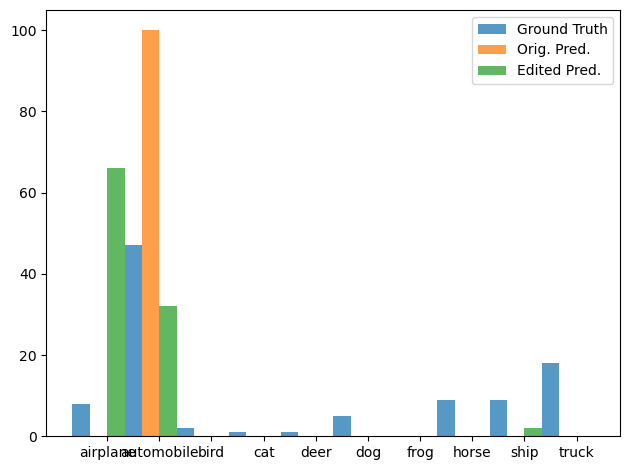

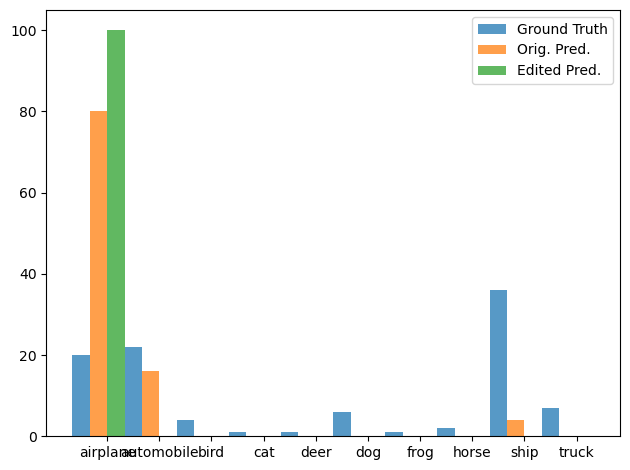

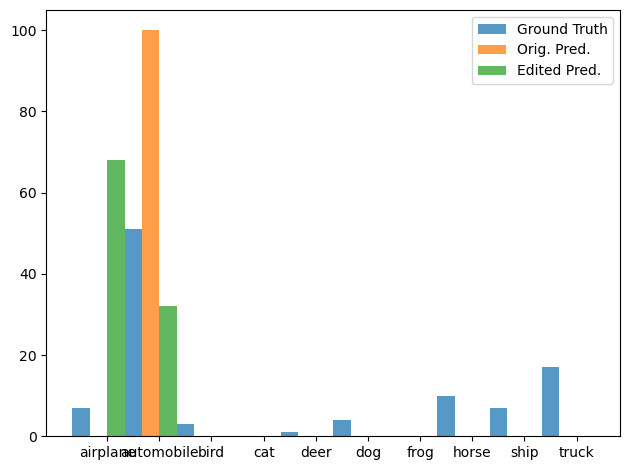

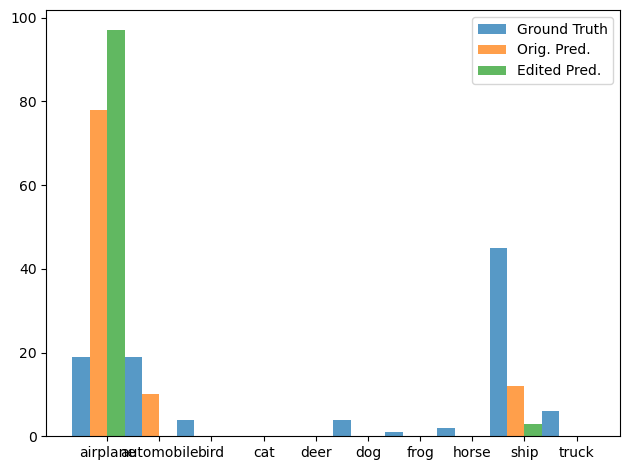

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_5662/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_5662/felzenszwalb_masked_softmax/models
Finished trial 13/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_5662/felzenszwalb_masked_softmax
(0126_173019) Starting Trial 14/158...
Current run_id: 0126_170417/results/airplane-train-n03335030_28782/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03335030_28782/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Ke

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.50it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.67it/s]

Loss (orig, final): 0.1755525767803192 0.005097800865769386
L2 norm of weight change: 0.7585615515708923
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.76it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6883, 5035, 4777, 3668,    0, 2429, 5174, 4353,    0, 3676]), 'TN': array([38804, 61492, 60212, 60372, 63000, 62429, 61976, 62361, 63000,
       62349]), 'FPs': array([24196,  1508,  2788,  2628,     0,   571,  1024,   639,     0,
         651]), 'FNs': array([ 117, 1965, 2223, 3332, 7000, 4571, 1826, 2647, 7000, 3324]), 'accuracy': 0.5142142857142857, 'per_class_accuracy': array([0.65267143, 0.95038571, 0.92841429, 0.91485714, 0.9       ,
       0.92654286, 0.95928571, 0.95305714, 0.9       , 0.94321429]), 'per_class_accuracy_mean': 0.9028428571428571, 'precision': array([0.22146787, 0.76952468, 0.63146067, 0.58259212, 0.        ,
       0.80966667, 0.83478541, 0.87199519, 0.        , 0.84954934]), 'precision_mean': 0.557104196617265, 'recall': array([0.98328571, 0.71928571, 0.68242857, 0.524     , 0.        ,
       0.347     , 0.73914286, 0.62185714, 0.        , 0.52514286]), 'recall_mean': 0.5142142857142857, 'predicted_class_distribution': array([3

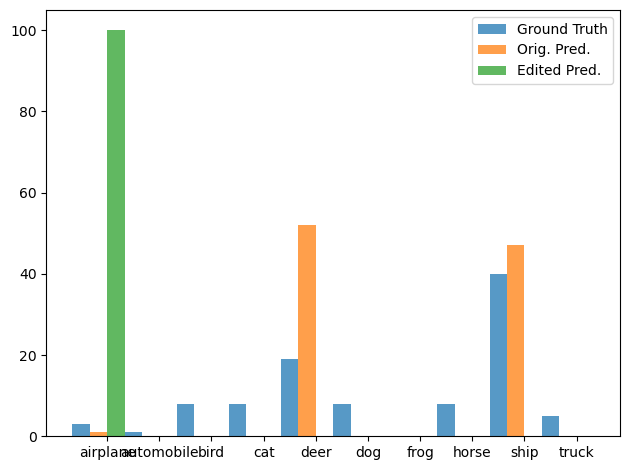

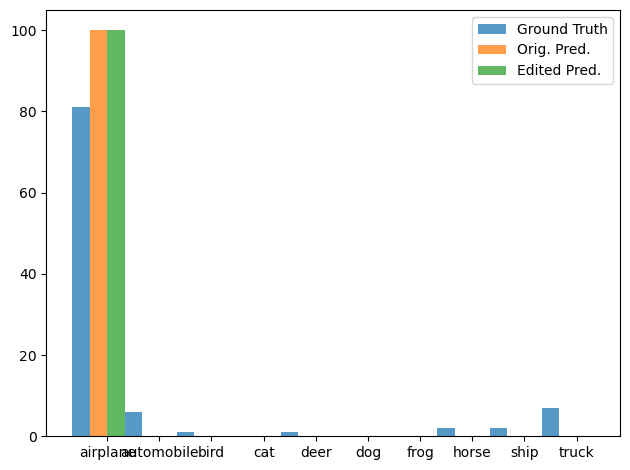

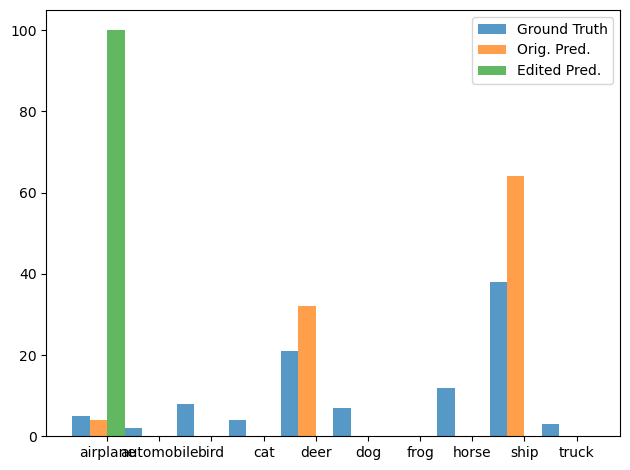

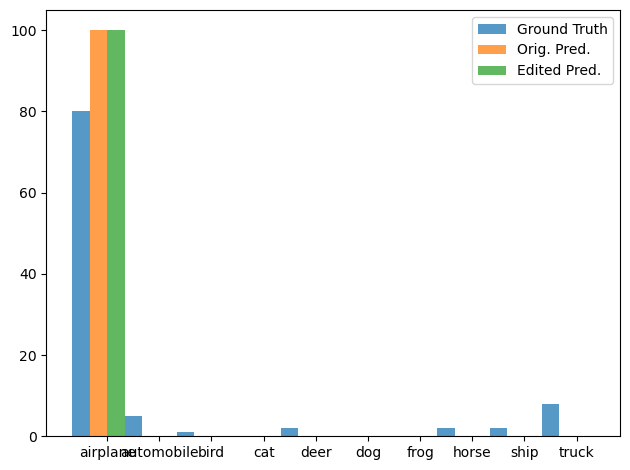

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03335030_28782/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03335030_28782/felzenszwalb_masked_softmax/models
Finished trial 14/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03335030_28782/felzenszwalb_masked_softmax
(0126_173125) Starting Trial 15/158...
Current run_id: 0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 874.22it/s]

Loss (orig, final): 0.12645608186721802 0.0063237836584448814
L2 norm of weight change: 0.5588065385818481
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.54it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6813, 5031, 5071, 3960, 3850, 2398, 5522, 5359,    0, 4358]), 'TN': array([51086, 61544, 59605, 59719, 60874, 62436, 61379, 60926, 63000,
       61793]), 'FPs': array([11914,  1456,  3395,  3281,  2126,   564,  1621,  2074,     0,
        1207]), 'FNs': array([ 187, 1969, 1929, 3040, 3150, 4602, 1478, 1641, 7000, 2642]), 'accuracy': 0.6051714285714286, 'per_class_accuracy': array([0.82712857, 0.95107143, 0.92394286, 0.9097    , 0.92462857,
       0.9262    , 0.95572857, 0.94692857, 0.9       , 0.94501429]), 'per_class_accuracy_mean': 0.9210342857142859, 'precision': array([0.36380627, 0.7755511 , 0.59898417, 0.54688579, 0.64424364,
       0.80958812, 0.77306454, 0.72097403, 0.        , 0.78310872]), 'precision_mean': 0.6016206378438245, 'recall': array([0.97328571, 0.71871429, 0.72442857, 0.56571429, 0.55      ,
       0.34257143, 0.78885714, 0.76557143, 0.        , 0.62257143]), 'recall_mean': 0.6051714285714286, 'predicted_class_distribution': array([

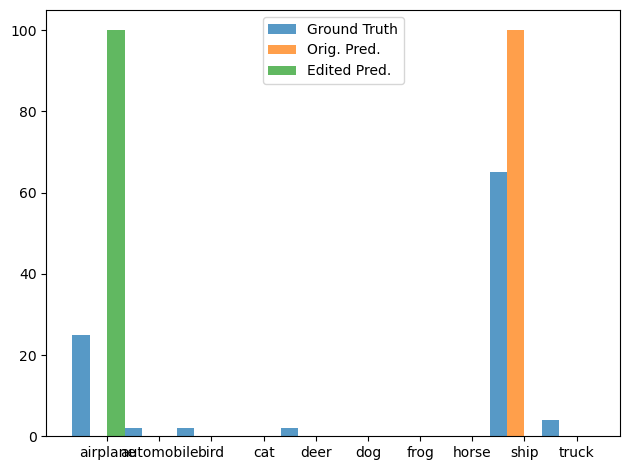

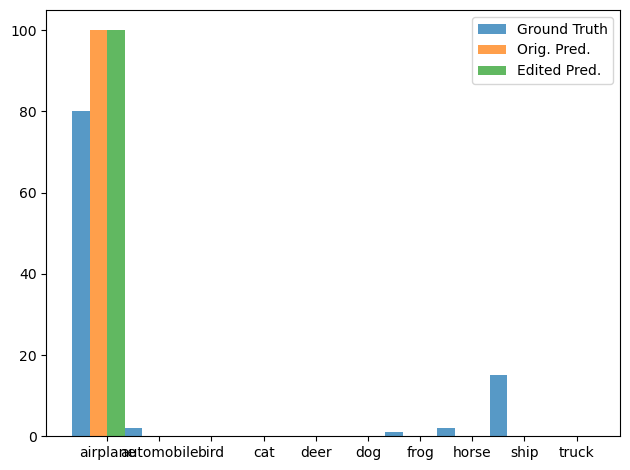

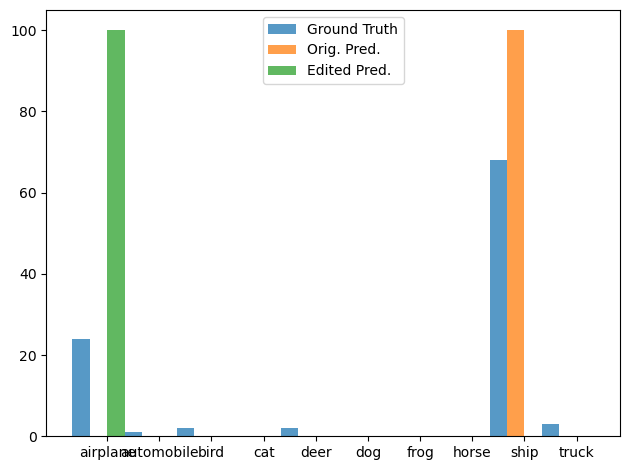

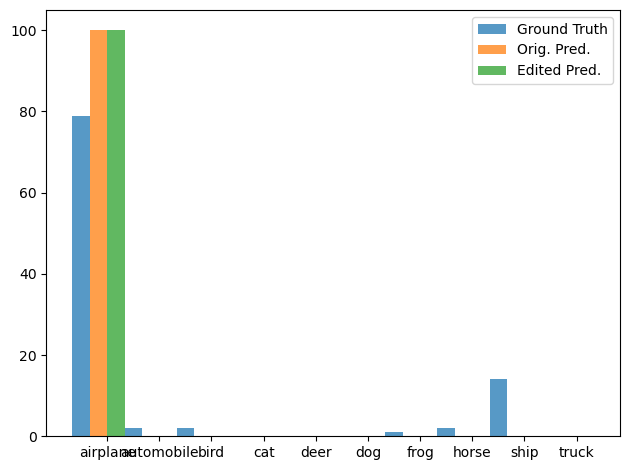

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_masked_softmax/models
Finished trial 15/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_masked_softmax
(0126_173230) Starting Trial 16/158...
Current run_id: 0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validat

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.69it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 870.43it/s]

Loss (orig, final): 0.07863251119852066 0.008416238240897655
L2 norm of weight change: 0.25857672095298767
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.04it/s]


Post-edit metrics: {'TP': array([6422, 5332, 5167, 3951, 4178, 2775, 5690, 5298, 3952, 4651]), 'TN': array([58806, 61182, 59470, 59593, 60296, 62031, 60947, 61335, 62457,
       61299]), 'FPs': array([4194, 1818, 3530, 3407, 2704,  969, 2053, 1665,  543, 1701]), 'FNs': array([ 578, 1668, 1833, 3049, 2822, 4225, 1310, 1702, 3048, 2349]), 'accuracy': 0.6773714285714286, 'per_class_accuracy': array([0.93182857, 0.9502    , 0.92338571, 0.90777143, 0.92105714,
       0.9258    , 0.95195714, 0.9519    , 0.9487    , 0.94214286]), 'per_class_accuracy_mean': 0.9354742857142858, 'precision': array([0.60493595, 0.74573427, 0.59411291, 0.53696657, 0.60709096,
       0.7411859 , 0.73485729, 0.76087893, 0.87919911, 0.73221033]), 'precision_mean': 0.6937172209871795, 'recall': array([0.91742857, 0.76171429, 0.73814286, 0.56442857, 0.59685714,
       0.39642857, 0.81285714, 0.75685714, 0.56457143, 0.66442857]), 'recall_mean': 0.6773714285714286, 'predicted_class_distribution': array([10616,  7150,  86

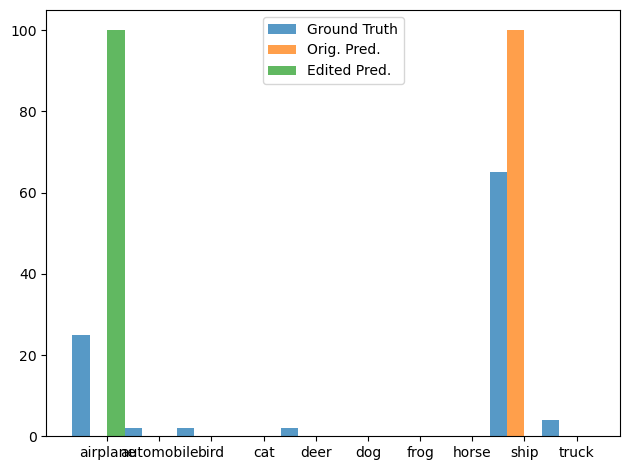

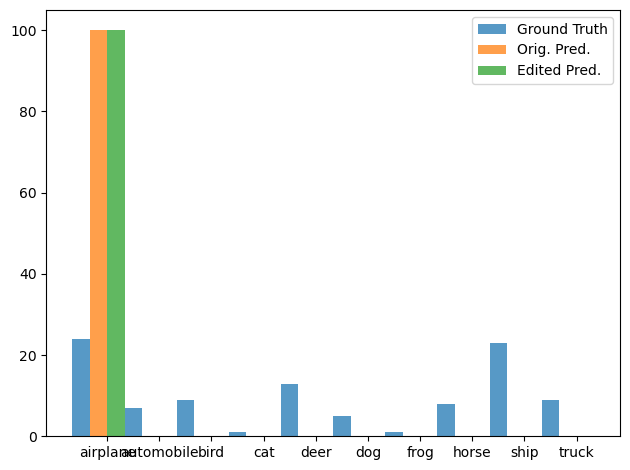

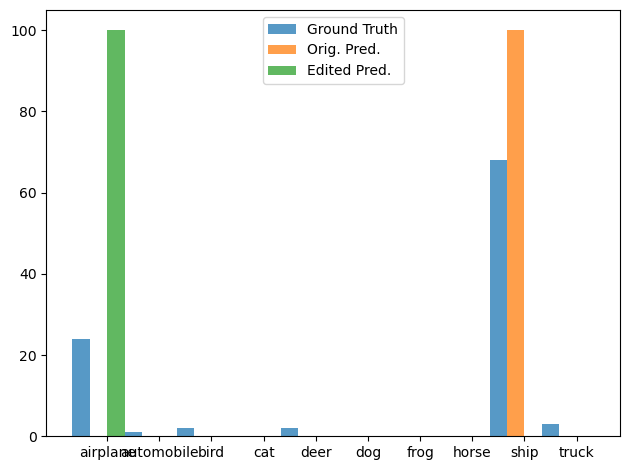

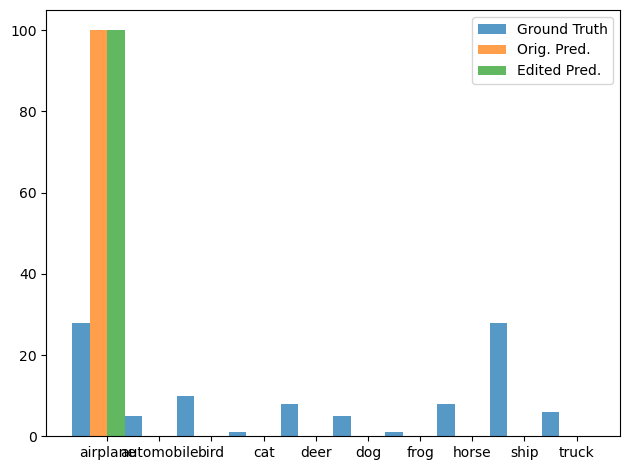

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_gaussian_softmax/models
Finished trial 16/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_16253/felzenszwalb_gaussian_softmax
(0126_173335) Starting Trial 17/158...
Current run_id: 0126_170417/results/airplane-train-n04012084_243/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validatio

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.94it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.59it/s]

Loss (orig, final): 0.08049948513507843 0.003455763217061758
L2 norm of weight change: 0.27625247836112976
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.73it/s]


Post-edit metrics: {'TP': array([6400, 5334, 4371, 4066, 4290, 2834, 5644, 5099, 4693, 4685]), 'TN': array([57829, 61143, 61193, 59487, 60016, 61975, 61177, 61705, 61772,
       61119]), 'FPs': array([5171, 1857, 1807, 3513, 2984, 1025, 1823, 1295, 1228, 1881]), 'FNs': array([ 600, 1666, 2629, 2934, 2710, 4166, 1356, 1901, 2307, 2315]), 'accuracy': 0.6773714285714286, 'per_class_accuracy': array([0.91755714, 0.94967143, 0.93662857, 0.9079    , 0.91865714,
       0.92584286, 0.95458571, 0.95434286, 0.9495    , 0.94005714]), 'per_class_accuracy_mean': 0.9354742857142858, 'precision': array([0.55310691, 0.74176053, 0.70751052, 0.53648239, 0.58977179,
       0.73438715, 0.75585911, 0.79746637, 0.7926026 , 0.71352422]), 'precision_mean': 0.6922471587531296, 'recall': array([0.91428571, 0.762     , 0.62442857, 0.58085714, 0.61285714,
       0.40485714, 0.80628571, 0.72842857, 0.67042857, 0.66928571]), 'recall_mean': 0.6773714285714285, 'predicted_class_distribution': array([11571,  7191,  61

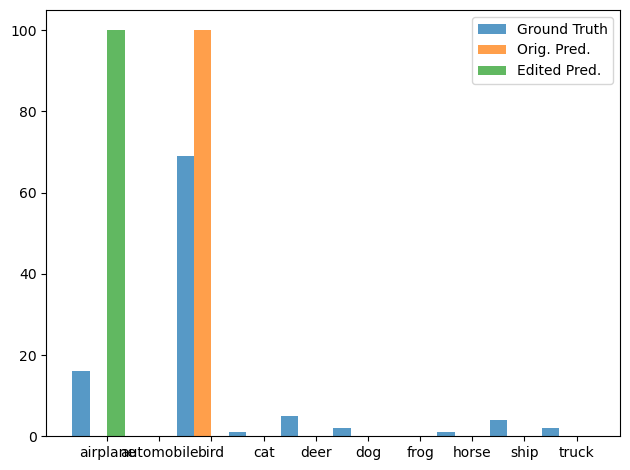

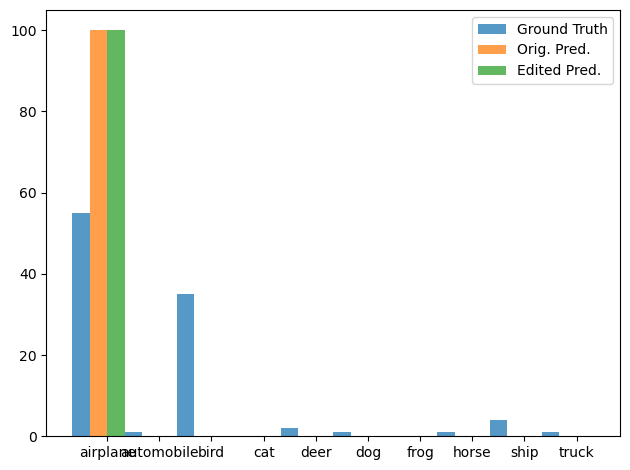

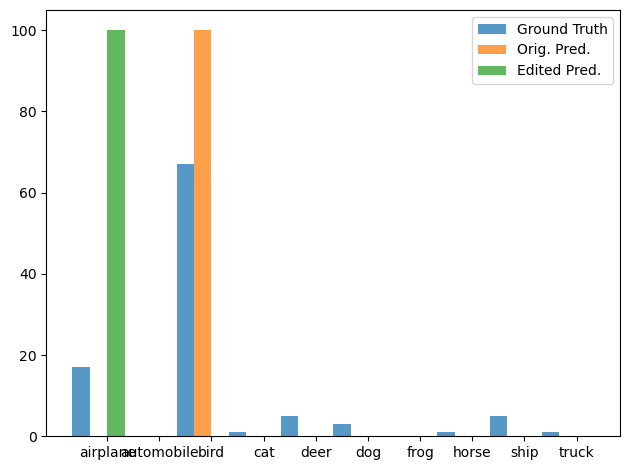

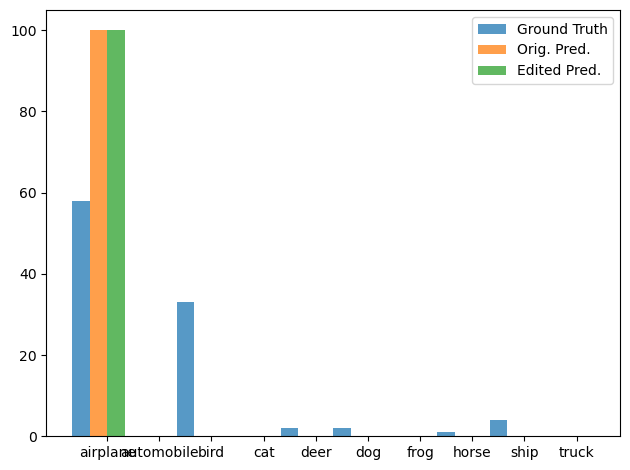

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_masked_softmax/models
Finished trial 17/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_masked_softmax
(0126_173442) Starting Trial 18/158...
Current run_id: 0126_170417/results/airplane-train-n04012084_243/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.00it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.47it/s]

Loss (orig, final): 0.14157772064208984 0.004306400194764137
L2 norm of weight change: 0.5671927332878113
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.84it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6549, 5241,    0, 4075, 4217, 2662, 5387, 4943, 4474, 4695]), 'TN': array([49410, 61295, 63000, 59538, 60186, 62175, 61694, 61886, 61981,
       61078]), 'FPs': array([13590,  1705,     0,  3462,  2814,   825,  1306,  1114,  1019,
        1922]), 'FNs': array([ 451, 1759, 7000, 2925, 2783, 4338, 1613, 2057, 2526, 2305]), 'accuracy': 0.6034714285714285, 'per_class_accuracy': array([0.79941429, 0.95051429, 0.9       , 0.90875714, 0.92004286,
       0.92624286, 0.9583    , 0.9547    , 0.94935714, 0.93961429]), 'per_class_accuracy_mean': 0.9206942857142856, 'precision': array([0.32518993, 0.75453498, 0.        , 0.54066605, 0.59977244,
       0.76340694, 0.80487076, 0.81608057, 0.81449117, 0.70953604]), 'precision_mean': 0.612854888060449, 'recall': array([0.93557143, 0.74871429, 0.        , 0.58214286, 0.60242857,
       0.38028571, 0.76957143, 0.70614286, 0.63914286, 0.67071429]), 'recall_mean': 0.6034714285714285, 'predicted_class_distribution': array([2

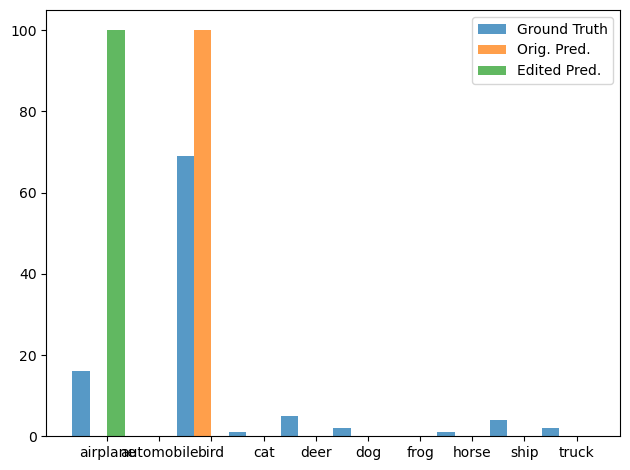

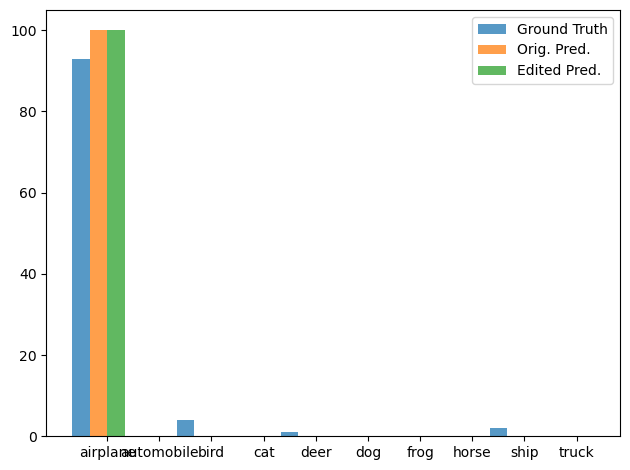

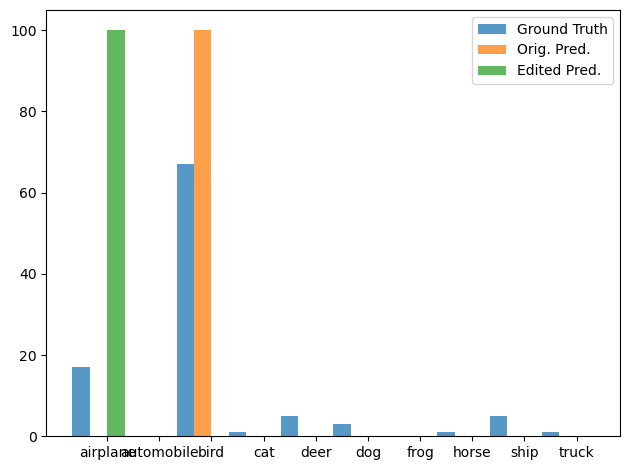

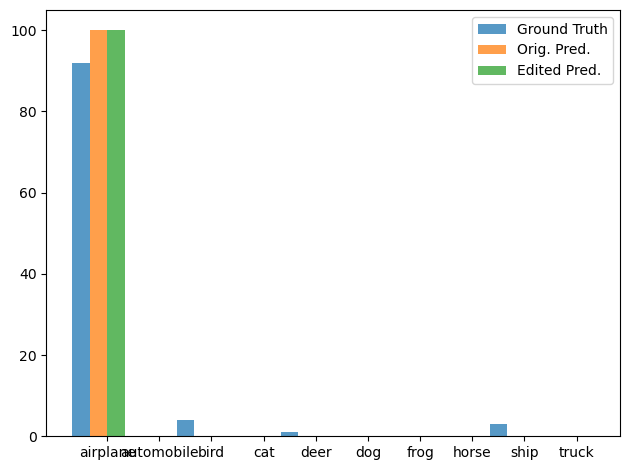

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_gaussian_softmax/models
Finished trial 18/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012084_243/felzenszwalb_gaussian_softmax
(0126_173547) Starting Trial 19/158...
Current run_id: 0126_170417/results/airplane-train-n02691156_6774/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02691156_6774/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
K

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.77it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.77it/s]

Loss (orig, final): 0.12980686128139496 0.008235306479036808
L2 norm of weight change: 0.5831109285354614
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.26it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6560,    0, 4856, 4885, 4152, 1948, 5258, 4651, 4027, 3838]), 'TN': array([49191, 63000, 60277, 55877, 60316, 62693, 61928, 62272, 62387,
       62234]), 'FPs': array([13809,     0,  2723,  7123,  2684,   307,  1072,   728,   613,
         766]), 'FNs': array([ 440, 7000, 2144, 2115, 2848, 5052, 1742, 2349, 2973, 3162]), 'accuracy': 0.5739285714285715, 'per_class_accuracy': array([0.79644286, 0.9       , 0.93047143, 0.86802857, 0.92097143,
       0.92344286, 0.9598    , 0.95604286, 0.94877143, 0.94388571]), 'per_class_accuracy_mean': 0.9147857142857143, 'precision': array([0.32205803, 0.        , 0.64071777, 0.40681213, 0.60737273,
       0.86385809, 0.83064771, 0.86465886, 0.86788793, 0.83362294]), 'precision_mean': 0.6237636188575919, 'recall': array([0.93714286, 0.        , 0.69371429, 0.69785714, 0.59314286,
       0.27828571, 0.75114286, 0.66442857, 0.57528571, 0.54828571]), 'recall_mean': 0.5739285714285713, 'predicted_class_distribution': array([

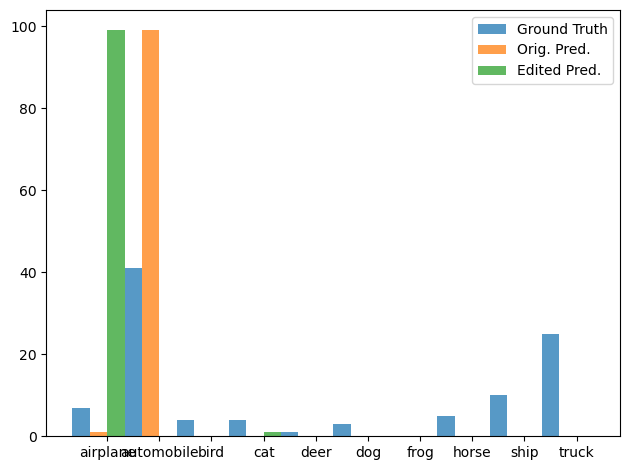

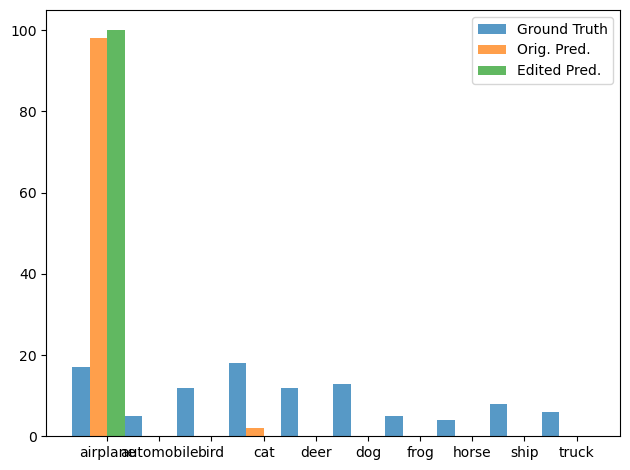

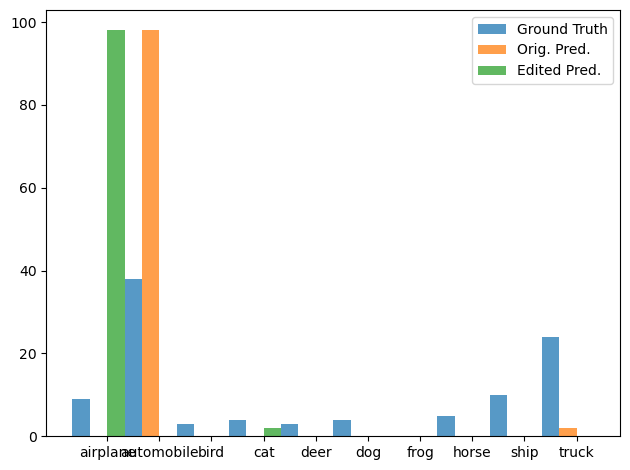

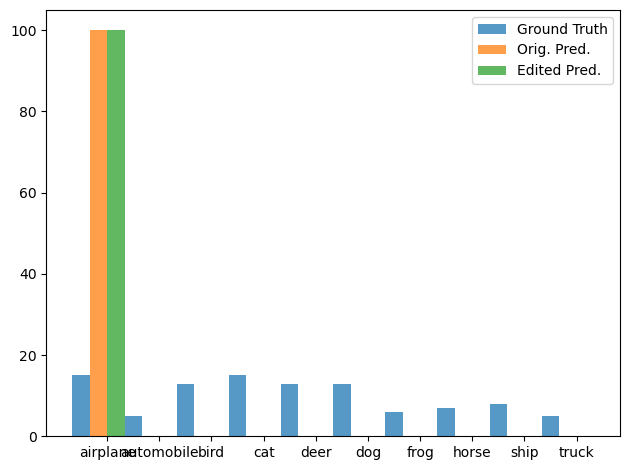

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02691156_6774/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02691156_6774/felzenszwalb_masked_softmax/models
Finished trial 19/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02691156_6774/felzenszwalb_masked_softmax
(0126_173652) Starting Trial 20/158...
Current run_id: 0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0543, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 880.06it/s]


Loss (orig, final): 0.22232329845428467 0.05426078662276268
L2 norm of weight change: 0.6696168780326843
Performing post-edit metric & KNN calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.64it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6765, 5255, 5118, 3898, 3892, 2539, 5672, 5327,    0, 4342]), 'TN': array([52130, 61337, 59564, 59745, 60821, 62318, 60946, 61151, 63000,
       61796]), 'FPs': array([10870,  1663,  3436,  3255,  2179,   682,  2054,  1849,     0,
        1204]), 'FNs': array([ 235, 1745, 1882, 3102, 3108, 4461, 1328, 1673, 7000, 2658]), 'accuracy': 0.6115428571428572, 'per_class_accuracy': array([0.84135714, 0.95131429, 0.92402857, 0.90918571, 0.92447143,
       0.92652857, 0.95168571, 0.94968571, 0.9       , 0.94482857]), 'per_class_accuracy_mean': 0.9223085714285715, 'precision': array([0.38361213, 0.7596126 , 0.59831658, 0.54494618, 0.64108055,
       0.78826451, 0.73414445, 0.74233556, 0.        , 0.7829066 ]), 'precision_mean': 0.597521916387495, 'recall': array([0.96642857, 0.75071429, 0.73114286, 0.55685714, 0.556     ,
       0.36271429, 0.81028571, 0.761     , 0.        , 0.62028571]), 'recall_mean': 0.6115428571428572, 'predicted_class_distribution': array([1

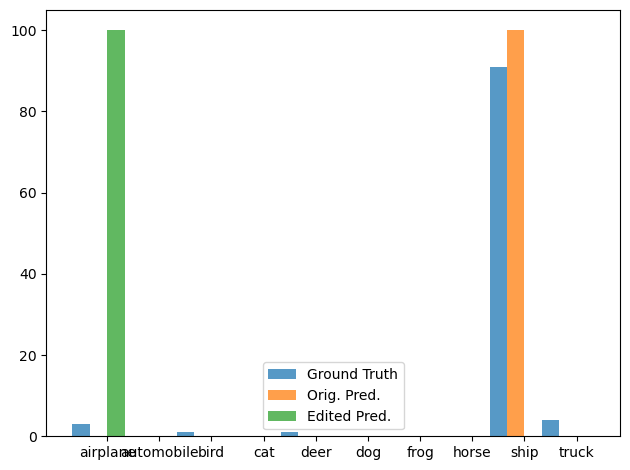

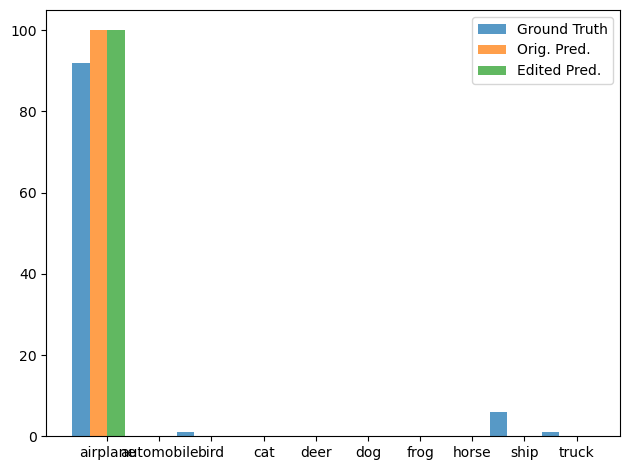

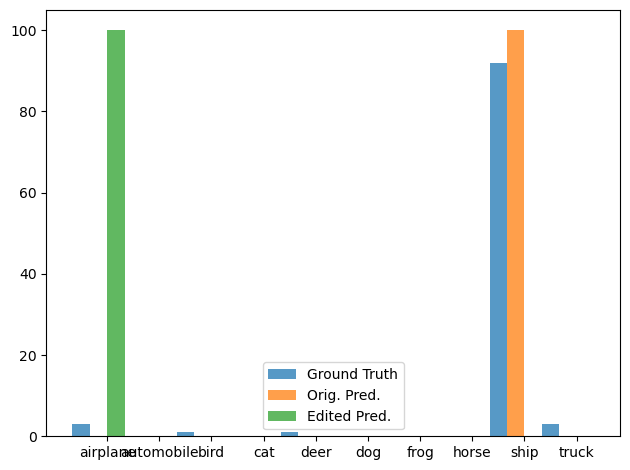

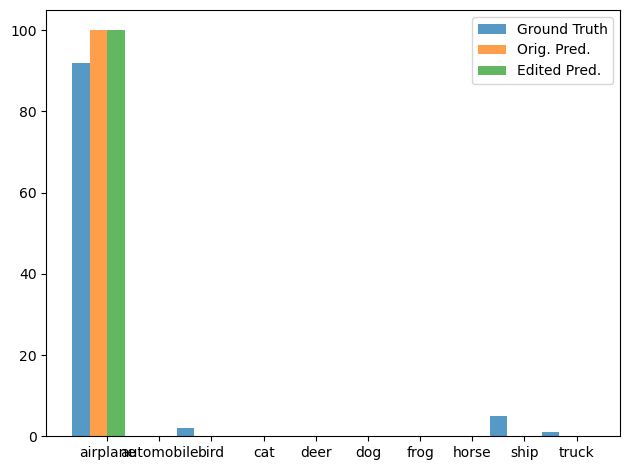

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_masked_softmax/models
Finished trial 20/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_masked_softmax
(0126_173756) Starting Trial 21/158...
Current run_id: 0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.76it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0522, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 874.75it/s]

Loss (orig, final): 0.21075765788555145 0.05224298685789108
L2 norm of weight change: 0.6166674494743347
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.88it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6754, 5262, 5137, 3894, 3961, 2557, 5678, 5315,    0, 4386]), 'TN': array([52427, 61327, 59543, 59756, 60717, 62301, 60943, 61177, 63000,
       61753]), 'FPs': array([10573,  1673,  3457,  3244,  2283,   699,  2057,  1823,     0,
        1247]), 'FNs': array([ 246, 1738, 1863, 3106, 3039, 4443, 1322, 1685, 7000, 2614]), 'accuracy': 0.6134857142857143, 'per_class_accuracy': array([0.84544286, 0.95127143, 0.924     , 0.90928571, 0.92397143,
       0.92654286, 0.95172857, 0.94988571, 0.9       , 0.94484286]), 'per_class_accuracy_mean': 0.922697142857143, 'precision': array([0.38979627, 0.75875991, 0.59774261, 0.54553096, 0.63436899,
       0.78531941, 0.73406593, 0.74460633, 0.        , 0.77862595]), 'precision_mean': 0.5968816382498808, 'recall': array([0.96485714, 0.75171429, 0.73385714, 0.55628571, 0.56585714,
       0.36528571, 0.81114286, 0.75928571, 0.        , 0.62657143]), 'recall_mean': 0.6134857142857142, 'predicted_class_distribution': array([1

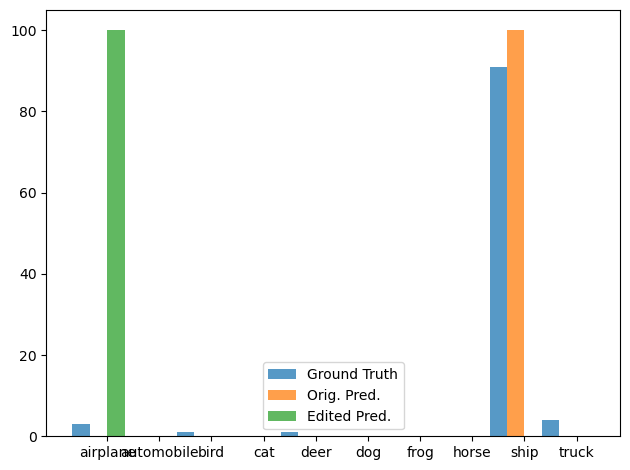

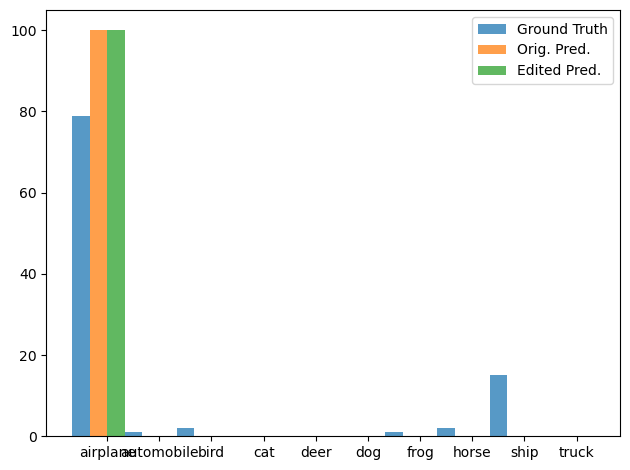

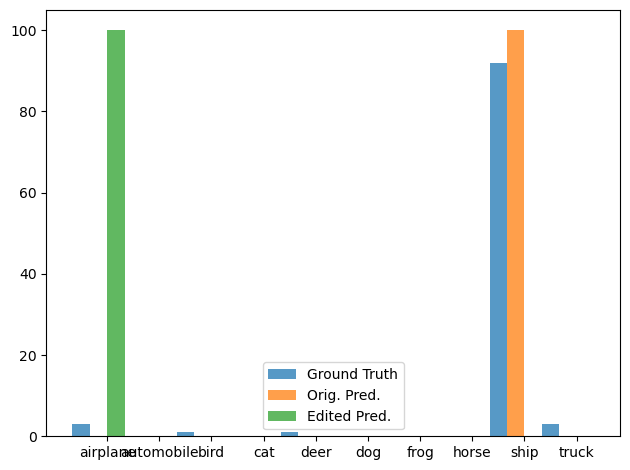

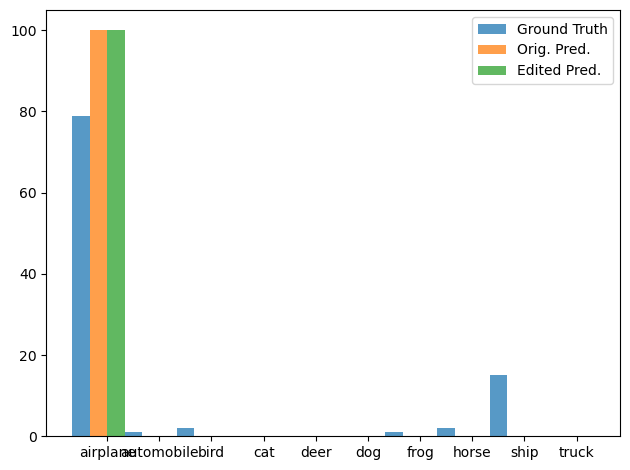

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_gaussian_softmax/models
Finished trial 21/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02704645_2368/felzenszwalb_gaussian_softmax
(0126_173900) Starting Trial 22/158...
Current run_id: 0126_170417/results/airplane-train-n03365231_5956/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_5956/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0519, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 886.73it/s]

Loss (orig, final): 0.21481233835220337 0.051937345415353775
L2 norm of weight change: 0.6606365442276001
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.28it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6755, 5244, 5123, 3977, 3889, 2551, 5662, 5339,    0, 4386]), 'TN': array([52408, 61354, 59584, 59570, 60830, 62302, 60996, 61131, 63000,
       61751]), 'FPs': array([10592,  1646,  3416,  3430,  2170,   698,  2004,  1869,     0,
        1249]), 'FNs': array([ 245, 1756, 1877, 3023, 3111, 4449, 1338, 1661, 7000, 2614]), 'accuracy': 0.6132285714285715, 'per_class_accuracy': array([0.84518571, 0.9514    , 0.92438571, 0.90781429, 0.92455714,
       0.92647143, 0.95225714, 0.94957143, 0.9       , 0.94481429]), 'per_class_accuracy_mean': 0.9226457142857143, 'precision': array([0.38940451, 0.76110305, 0.59995316, 0.53692453, 0.64185509,
       0.78516467, 0.73858596, 0.74070477, 0.        , 0.7783496 ]), 'precision_mean': 0.5972045337668173, 'recall': array([0.965     , 0.74914286, 0.73185714, 0.56814286, 0.55557143,
       0.36442857, 0.80885714, 0.76271429, 0.        , 0.62657143]), 'recall_mean': 0.6132285714285713, 'predicted_class_distribution': array([

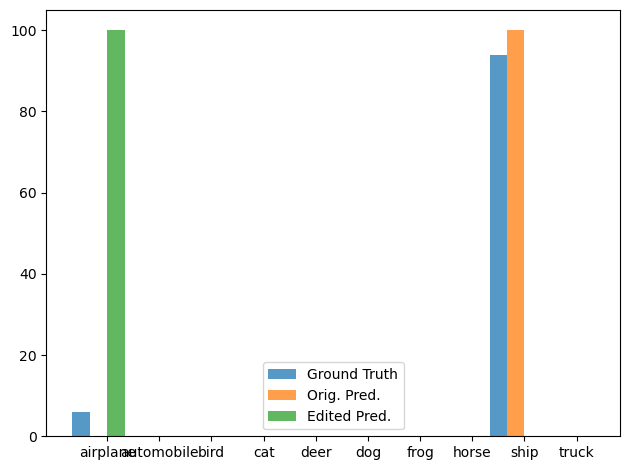

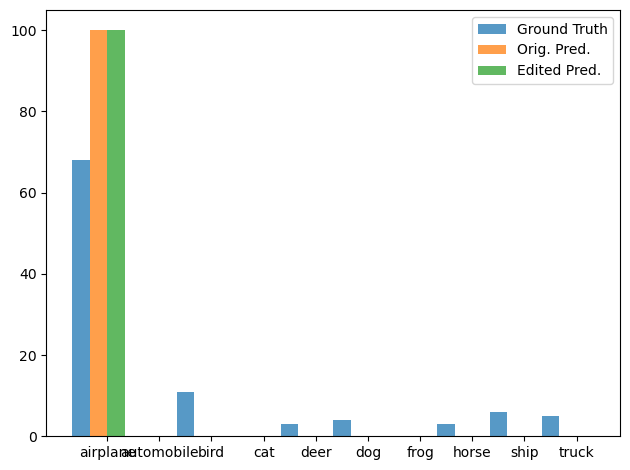

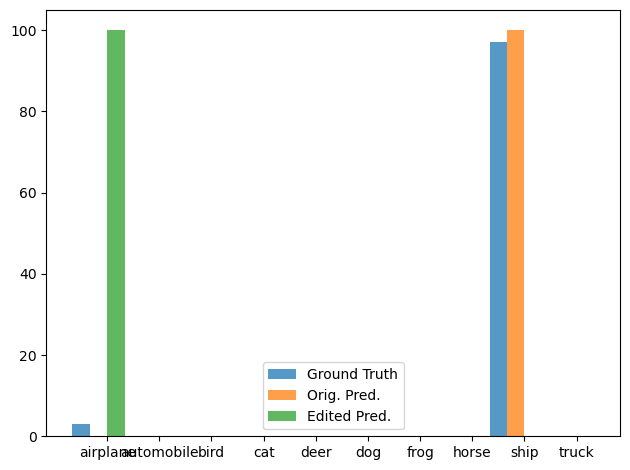

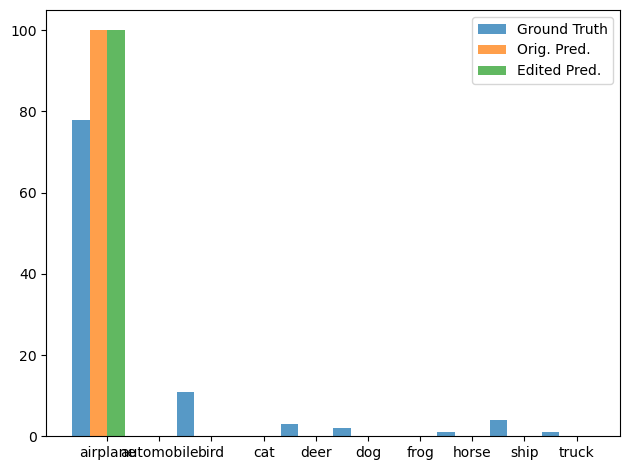

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_5956/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_5956/felzenszwalb_masked_softmax/models
Finished trial 22/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03365231_5956/felzenszwalb_masked_softmax
(0126_174009) Starting Trial 23/158...
Current run_id: 0126_170417/results/airplane-train-n03595860_2078/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_2078/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.75it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.59it/s]

Loss (orig, final): 0.17566624283790588 0.006995064206421375
L2 norm of weight change: 0.6685066819190979
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.82it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6830, 5274, 5037, 3812, 3621, 2478, 5605, 5336,    0, 3987]), 'TN': array([50166, 61255, 59633, 60031, 61224, 62379, 61173, 60984, 63000,
       62135]), 'FPs': array([12834,  1745,  3367,  2969,  1776,   621,  1827,  2016,     0,
         865]), 'FNs': array([ 170, 1726, 1963, 3188, 3379, 4522, 1395, 1664, 7000, 3013]), 'accuracy': 0.5997142857142858, 'per_class_accuracy': array([0.81422857, 0.95041429, 0.92385714, 0.91204286, 0.92635714,
       0.92652857, 0.95397143, 0.94742857, 0.9       , 0.9446    ]), 'per_class_accuracy_mean': 0.9199428571428572, 'precision': array([0.34733523, 0.75138909, 0.59935745, 0.56215897, 0.67092829,
       0.79961278, 0.75417115, 0.7257889 , 0.        , 0.821723  ]), 'precision_mean': 0.6032464866488751, 'recall': array([0.97571429, 0.75342857, 0.71957143, 0.54457143, 0.51728571,
       0.354     , 0.80071429, 0.76228571, 0.        , 0.56957143]), 'recall_mean': 0.5997142857142858, 'predicted_class_distribution': array([

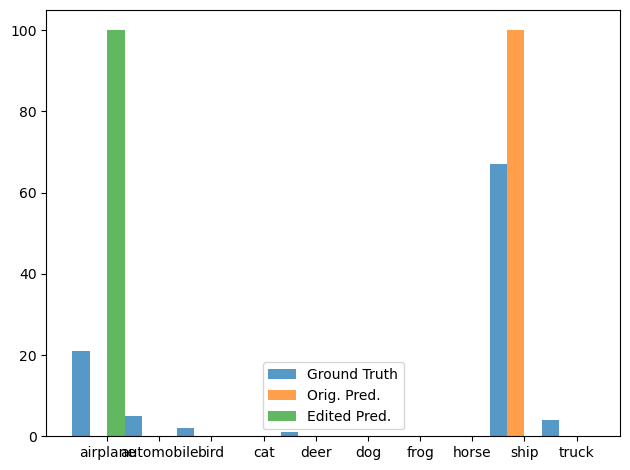

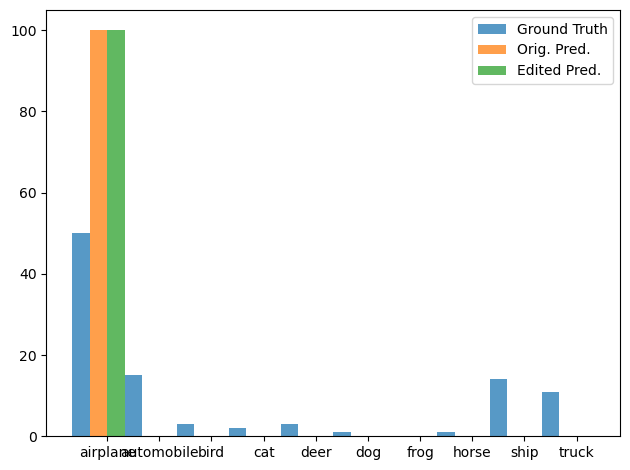

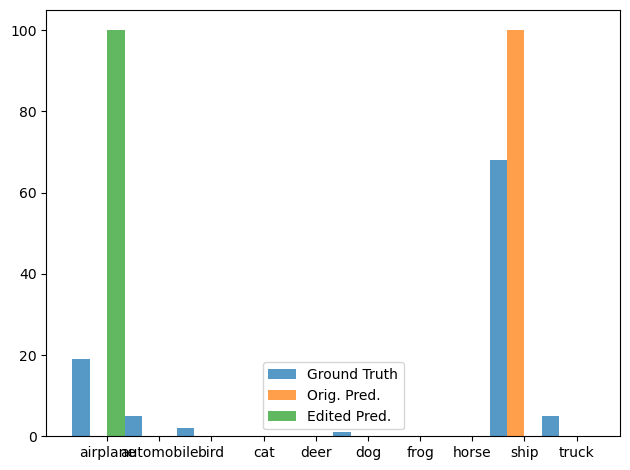

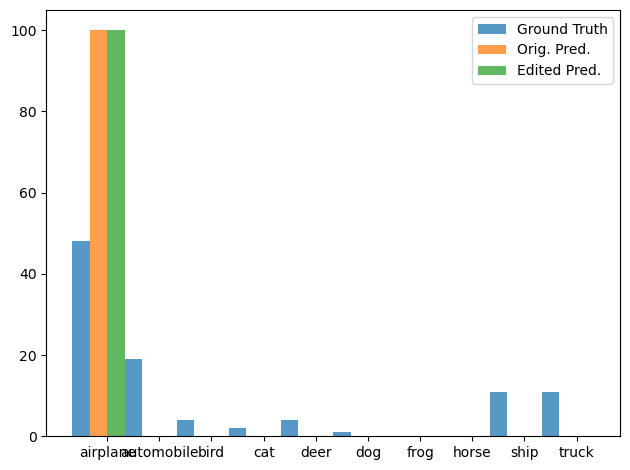

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_2078/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_2078/felzenszwalb_masked_softmax/models
Finished trial 23/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_2078/felzenszwalb_masked_softmax
(0126_174115) Starting Trial 24/158...
Current run_id: 0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.45it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 884.89it/s]

Loss (orig, final): 0.1820833384990692 0.01243748888373375
L2 norm of weight change: 0.68780118227005
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.20it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6628, 5343, 5313, 3377, 3913, 2975, 5423, 4495, 3838,    0]), 'TN': array([48693, 61145, 58551, 60998, 60698, 61831, 61562, 62327, 62500,
       63000]), 'FPs': array([14307,  1855,  4449,  2002,  2302,  1169,  1438,   673,   500,
           0]), 'FNs': array([ 372, 1657, 1687, 3623, 3087, 4025, 1577, 2505, 3162, 7000]), 'accuracy': 0.5900714285714286, 'per_class_accuracy': array([0.7903    , 0.94982857, 0.91234286, 0.91964286, 0.92301429,
       0.9258    , 0.95692857, 0.9546    , 0.94768571, 0.9       ]), 'per_class_accuracy_mean': 0.9180142857142858, 'precision': array([0.316599  , 0.74228952, 0.54425323, 0.62781186, 0.62960579,
       0.71790541, 0.79040956, 0.86977554, 0.88473951, 0.        ]), 'precision_mean': 0.6123389421724343, 'recall': array([0.94685714, 0.76328571, 0.759     , 0.48242857, 0.559     ,
       0.425     , 0.77471429, 0.64214286, 0.54828571, 0.        ]), 'recall_mean': 0.5900714285714286, 'predicted_class_distribution': array([

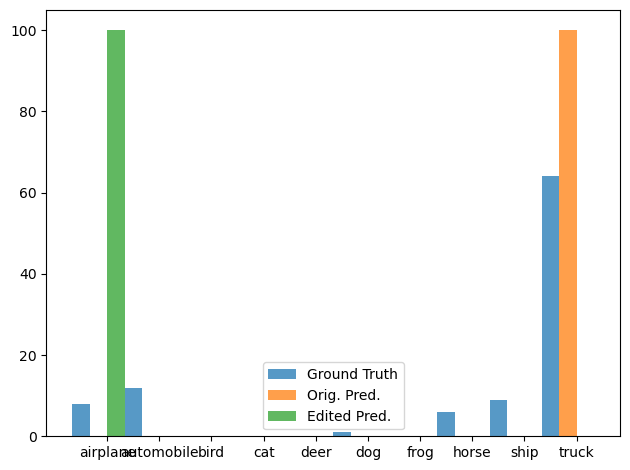

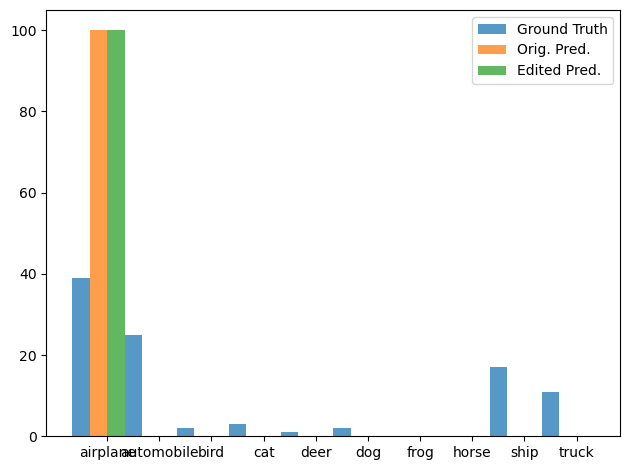

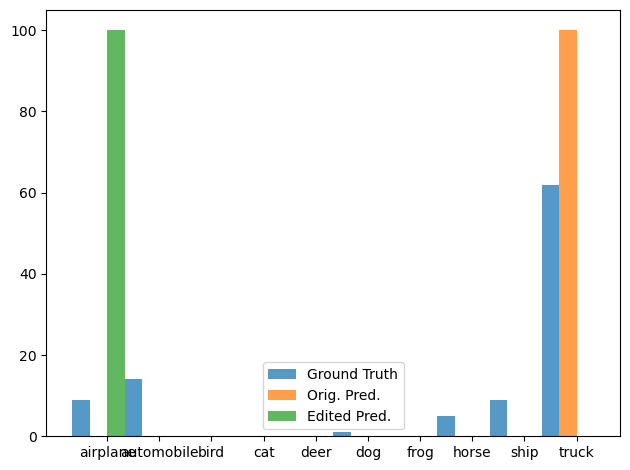

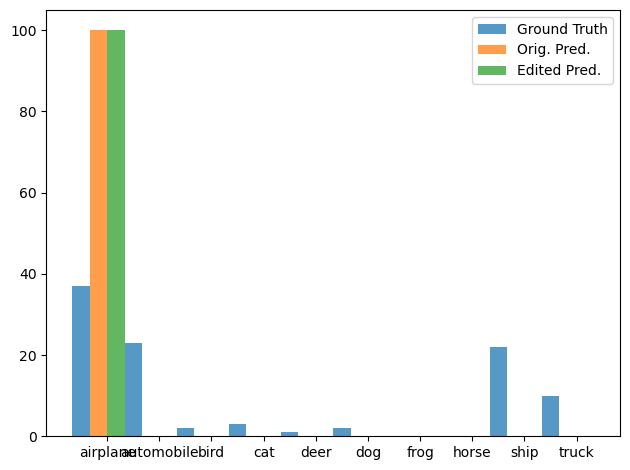

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_masked_softmax/models
Finished trial 24/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_masked_softmax
(0126_174224) Starting Trial 25/158...
Current run_id: 0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.74it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 872.84it/s]

Loss (orig, final): 0.09171251207590103 0.003205297514796257
L2 norm of weight change: 0.3406652510166168
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.35it/s]


Post-edit metrics: {'TP': array([6476, 5424, 5303, 3760, 4072, 2887, 5520, 4969, 4328, 3778]), 'TN': array([56464, 61003, 58837, 60193, 60468, 61937, 61341, 61883, 62113,
       62278]), 'FPs': array([6536, 1997, 4163, 2807, 2532, 1063, 1659, 1117,  887,  722]), 'FNs': array([ 524, 1576, 1697, 3240, 2928, 4113, 1480, 2031, 2672, 3222]), 'accuracy': 0.6645285714285715, 'per_class_accuracy': array([0.89914286, 0.94895714, 0.91628571, 0.91361429, 0.922     ,
       0.92605714, 0.95515714, 0.95502857, 0.94915714, 0.94365714]), 'per_class_accuracy_mean': 0.9329057142857143, 'precision': array([0.49769444, 0.7308988 , 0.56021551, 0.57255977, 0.616596  ,
       0.73088608, 0.76890932, 0.81646402, 0.82991371, 0.83955556]), 'precision_mean': 0.6963693192278939, 'recall': array([0.92514286, 0.77485714, 0.75757143, 0.53714286, 0.58171429,
       0.41242857, 0.78857143, 0.70985714, 0.61828571, 0.53971429]), 'recall_mean': 0.6645285714285716, 'predicted_class_distribution': array([13012,  7421,  94

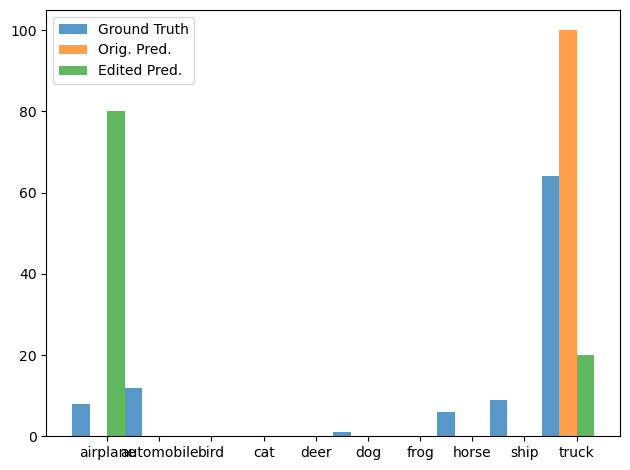

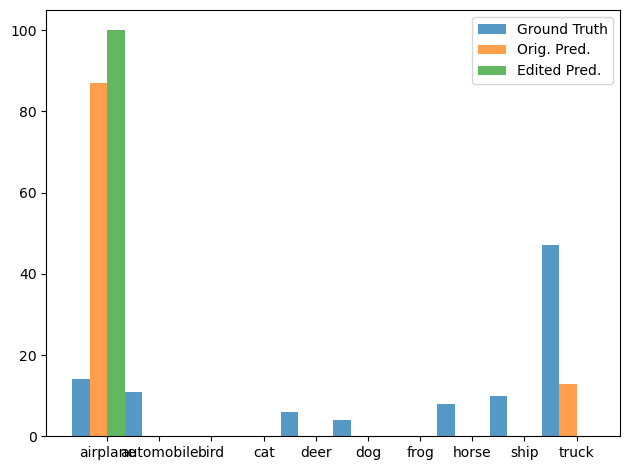

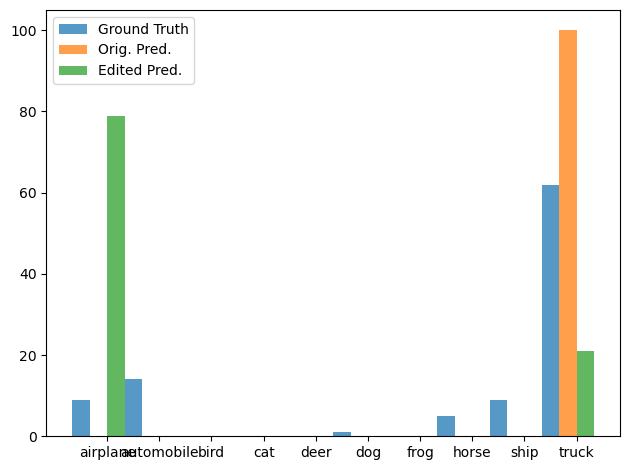

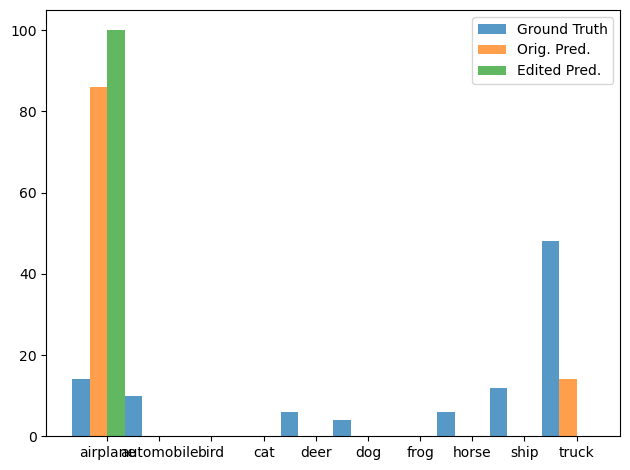

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_gaussian_softmax/models
Finished trial 25/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04308273_4722/felzenszwalb_gaussian_softmax
(0126_174333) Starting Trial 26/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_1168/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1168/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.35it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.96it/s]

Loss (orig, final): 0.12158011645078659 0.006192733533680439
L2 norm of weight change: 0.5684931874275208
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.58it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6584, 5240,    0, 4054, 3972, 2759, 4604, 5070, 4471, 4571]), 'TN': array([47210, 61287, 63000, 59561, 60666, 62049, 62492, 61717, 61962,
       61381]), 'FPs': array([15790,  1713,     0,  3439,  2334,   951,   508,  1283,  1038,
        1619]), 'FNs': array([ 416, 1760, 7000, 2946, 3028, 4241, 2396, 1930, 2529, 2429]), 'accuracy': 0.5903571428571428, 'per_class_accuracy': array([0.76848571, 0.95038571, 0.9       , 0.90878571, 0.9234    ,
       0.92582857, 0.95851429, 0.9541    , 0.94904286, 0.94217143]), 'per_class_accuracy_mean': 0.9180714285714286, 'precision': array([0.29427013, 0.75363153, 0.        , 0.5410383 , 0.62987631,
       0.74366577, 0.90062598, 0.79804817, 0.81158105, 0.73844911]), 'precision_mean': 0.62111863447994, 'recall': array([0.94057143, 0.74857143, 0.        , 0.57914286, 0.56742857,
       0.39414286, 0.65771429, 0.72428571, 0.63871429, 0.653     ]), 'recall_mean': 0.5903571428571428, 'predicted_class_distribution': array([22

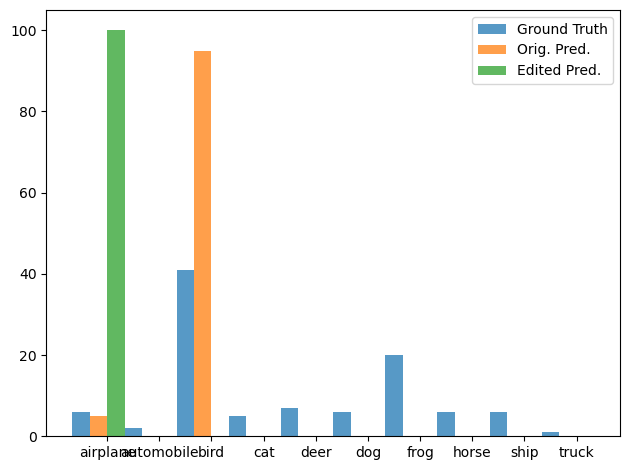

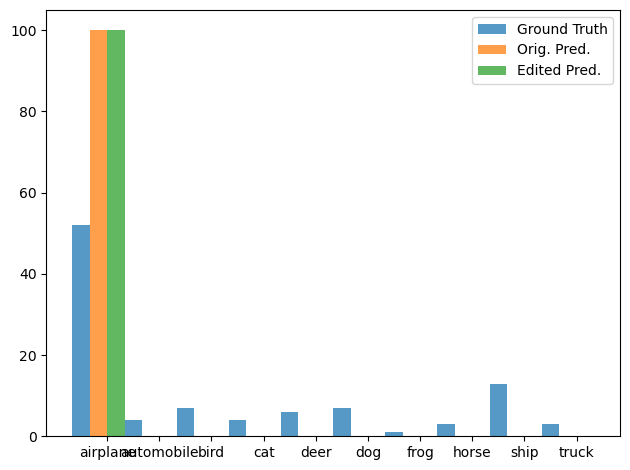

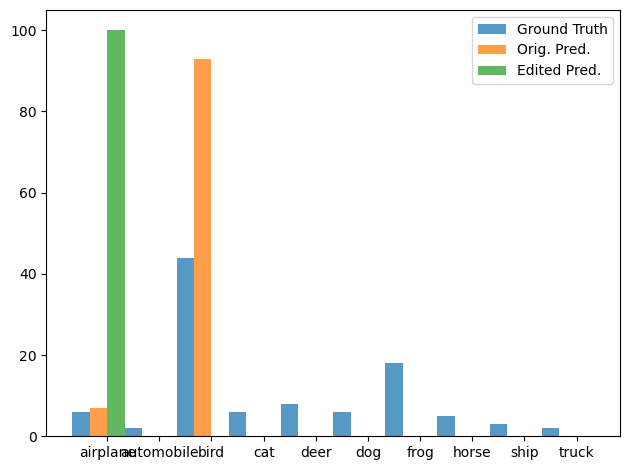

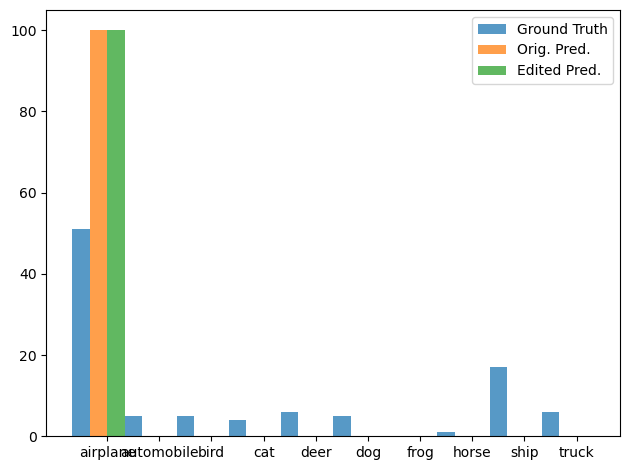

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1168/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1168/felzenszwalb_masked_softmax/models
Finished trial 26/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1168/felzenszwalb_masked_softmax
(0126_174438) Starting Trial 27/158...
Current run_id: 0126_170417/results/airplane-train-n04160586_1972/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_1972/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.65it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0214, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 875.93it/s]

Loss (orig, final): 0.19409123063087463 0.021359801292419434
L2 norm of weight change: 0.6954124569892883
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.09it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6810, 5055, 5038, 4308, 3475, 2401, 5505, 5281,    0, 4286]), 'TN': array([50612, 61527, 59788, 58790, 61449, 62438, 61425, 61251, 63000,
       61879]), 'FPs': array([12388,  1473,  3212,  4210,  1551,   562,  1575,  1749,     0,
        1121]), 'FNs': array([ 190, 1945, 1962, 2692, 3525, 4599, 1495, 1719, 7000, 2714]), 'accuracy': 0.6022714285714286, 'per_class_accuracy': array([0.82031429, 0.95117143, 0.92608571, 0.9014    , 0.92748571,
       0.92627143, 0.95614286, 0.95045714, 0.9       , 0.94521429]), 'per_class_accuracy_mean': 0.9204542857142858, 'precision': array([0.35472445, 0.77435662, 0.61066667, 0.50575252, 0.6914047 ,
       0.81032737, 0.77754237, 0.7512091 , 0.        , 0.79267616]), 'precision_mean': 0.6068659962589512, 'recall': array([0.97285714, 0.72214286, 0.71971429, 0.61542857, 0.49642857,
       0.343     , 0.78642857, 0.75442857, 0.        , 0.61228571]), 'recall_mean': 0.6022714285714286, 'predicted_class_distribution': array([

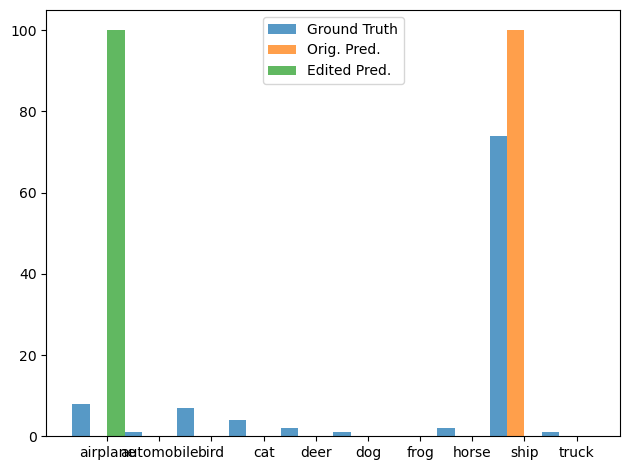

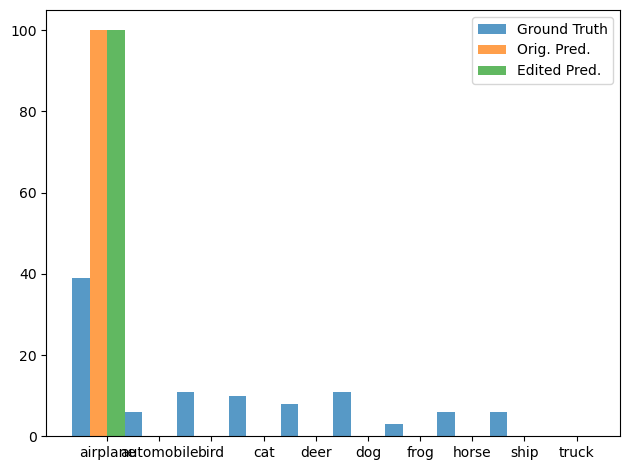

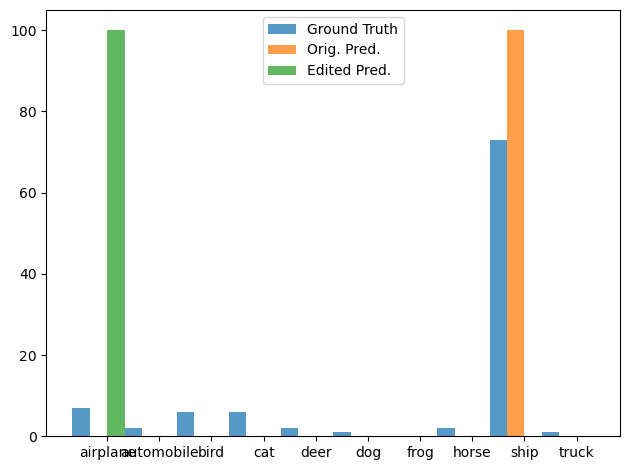

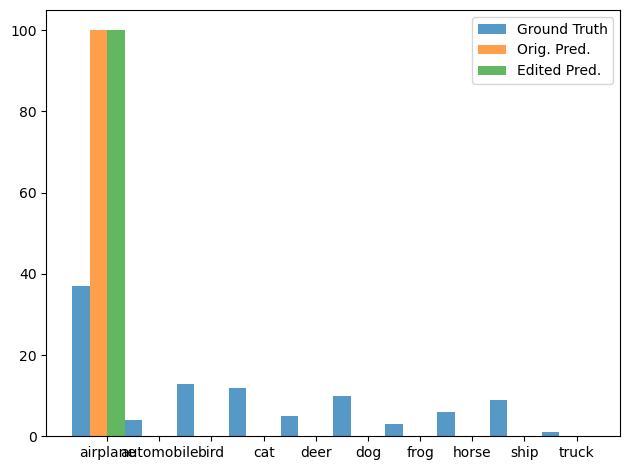

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_1972/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_1972/felzenszwalb_masked_softmax/models
Finished trial 27/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_1972/felzenszwalb_masked_softmax
(0126_174545) Starting Trial 28/158...
Current run_id: 0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.32it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.56it/s]

Loss (orig, final): 0.06355728954076767 0.0033282176591455936
L2 norm of weight change: 0.2345154732465744
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.89it/s]


Post-edit metrics: {'TP': array([6347, 5344, 4584, 4026, 4305, 2837, 5708, 5117, 4703, 4723]), 'TN': array([58710, 61133, 60849, 59474, 60006, 61964, 61020, 61675, 61793,
       61070]), 'FPs': array([4290, 1867, 2151, 3526, 2994, 1036, 1980, 1325, 1207, 1930]), 'FNs': array([ 653, 1656, 2416, 2974, 2695, 4163, 1292, 1883, 2297, 2277]), 'accuracy': 0.6813428571428571, 'per_class_accuracy': array([0.92938571, 0.94967143, 0.93475714, 0.90714286, 0.91872857,
       0.92572857, 0.95325714, 0.95417143, 0.94994286, 0.9399    ]), 'per_class_accuracy_mean': 0.9362685714285714, 'precision': array([0.5966908 , 0.74109   , 0.68062361, 0.53310381, 0.58980682,
       0.7325071 , 0.74245578, 0.79431853, 0.79576988, 0.70990531]), 'precision_mean': 0.691627163981688, 'recall': array([0.90671429, 0.76342857, 0.65485714, 0.57514286, 0.615     ,
       0.40528571, 0.81542857, 0.731     , 0.67185714, 0.67471429]), 'recall_mean': 0.6813428571428571, 'predicted_class_distribution': array([10637,  7211,  673

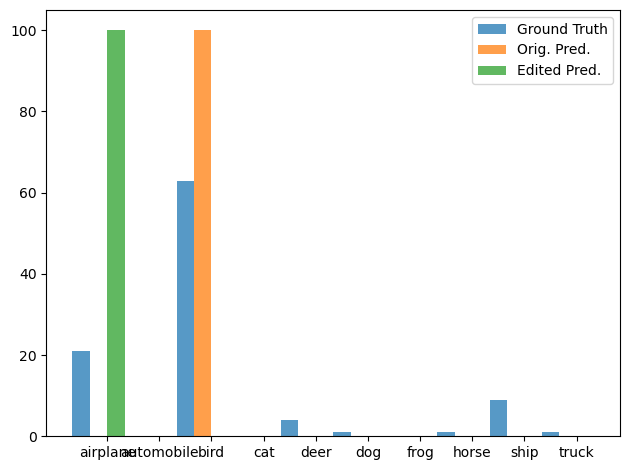

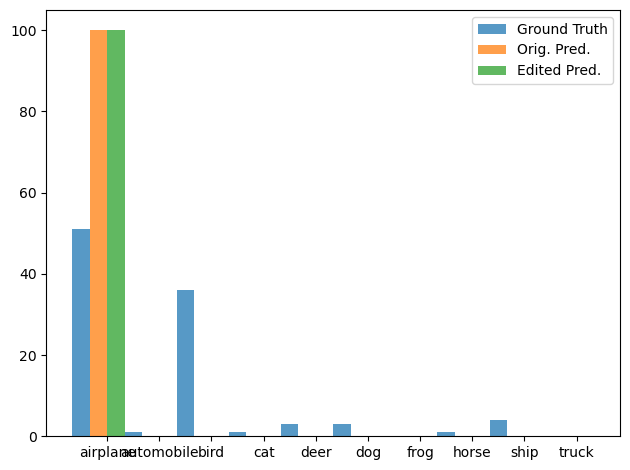

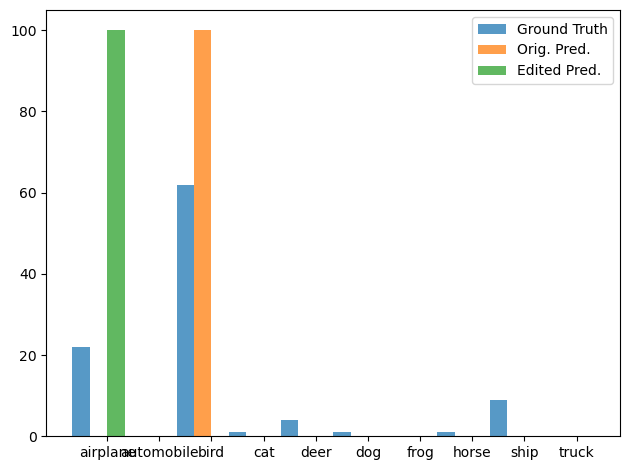

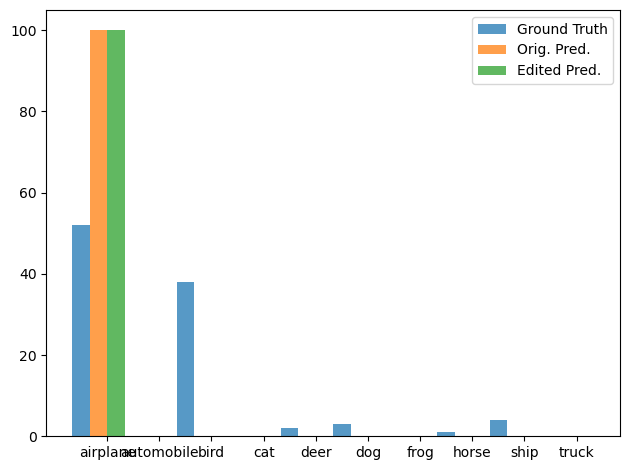

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_masked_softmax/models
Finished trial 28/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_masked_softmax
(0126_174651) Starting Trial 29/158...
Current run_id: 0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.64it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 881.68it/s]

Loss (orig, final): 0.08689066767692566 0.006939050275832415
L2 norm of weight change: 0.27358609437942505
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.75it/s]


Post-edit metrics: {'TP': array([6298, 5372, 4332, 4019, 4399, 2948, 5736, 4991, 4943, 4683]), 'TN': array([58864, 61074, 61326, 59533, 59773, 61809, 60969, 61896, 61396,
       61081]), 'FPs': array([4136, 1926, 1674, 3467, 3227, 1191, 2031, 1104, 1604, 1919]), 'FNs': array([ 702, 1628, 2668, 2981, 2601, 4052, 1264, 2009, 2057, 2317]), 'accuracy': 0.6817285714285715, 'per_class_accuracy': array([0.93088571, 0.94922857, 0.93797143, 0.90788571, 0.91674286,
       0.9251    , 0.95292857, 0.95552857, 0.9477    , 0.93948571]), 'per_class_accuracy_mean': 0.9363457142857143, 'precision': array([0.6036036 , 0.73609208, 0.72127872, 0.53686882, 0.57684238,
       0.71224934, 0.73850908, 0.81886792, 0.75500229, 0.70933051]), 'precision_mean': 0.6908644742045251, 'recall': array([0.89971429, 0.76742857, 0.61885714, 0.57414286, 0.62842857,
       0.42114286, 0.81942857, 0.713     , 0.70614286, 0.669     ]), 'recall_mean': 0.6817285714285714, 'predicted_class_distribution': array([10434,  7298,  60

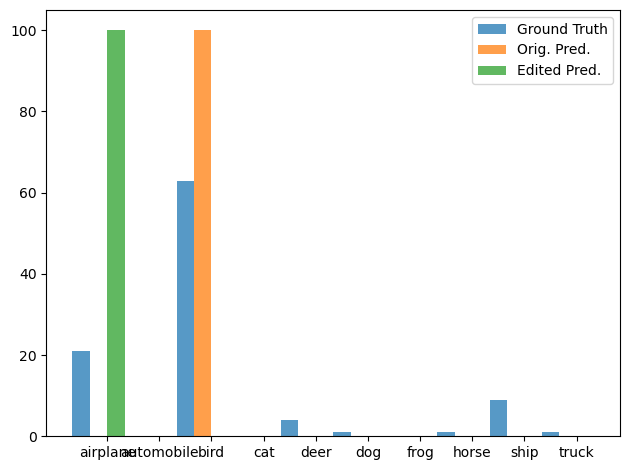

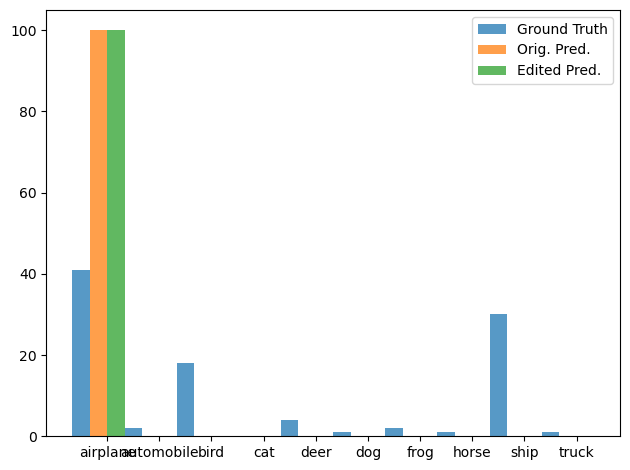

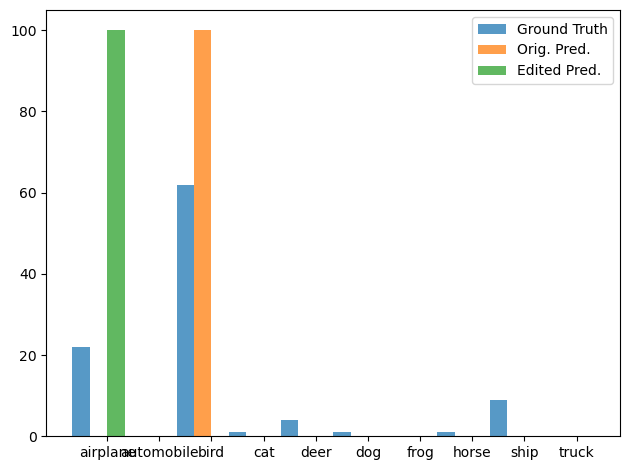

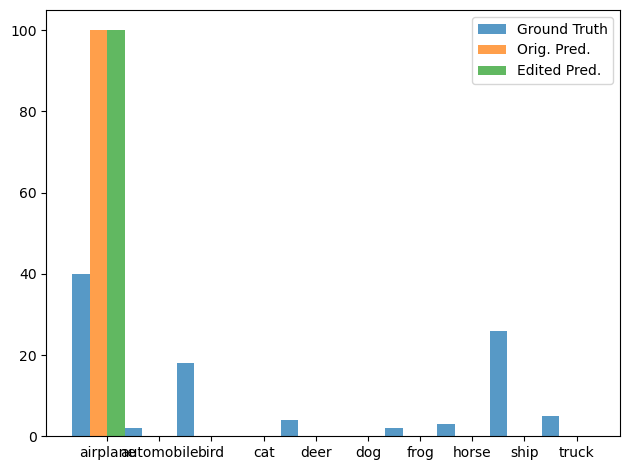

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_gaussian_softmax/models
Finished trial 29/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04222723_8439/felzenszwalb_gaussian_softmax
(0126_174801) Starting Trial 30/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.11it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 884.08it/s]

Loss (orig, final): 0.09545856714248657 0.004324300680309534
L2 norm of weight change: 0.404052734375
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.80it/s]


Post-edit metrics: {'TP': array([6514, 5287, 3144, 4107, 4267, 2742, 5630, 5059, 4507, 4725]), 'TN': array([54817, 61224, 62450, 59402, 60048, 62076, 61241, 61727, 61965,
       61032]), 'FPs': array([8183, 1776,  550, 3598, 2952,  924, 1759, 1273, 1035, 1968]), 'FNs': array([ 486, 1713, 3856, 2893, 2733, 4258, 1370, 1941, 2493, 2275]), 'accuracy': 0.6568857142857143, 'per_class_accuracy': array([0.87615714, 0.95015714, 0.93705714, 0.90727143, 0.91878571,
       0.92597143, 0.9553    , 0.95408571, 0.9496    , 0.93938571]), 'per_class_accuracy_mean': 0.931377142857143, 'precision': array([0.4432197 , 0.74854878, 0.85110991, 0.5330305 , 0.5910791 ,
       0.74795417, 0.76194343, 0.79895768, 0.81324432, 0.70596145]), 'precision_mean': 0.6995049031074971, 'recall': array([0.93057143, 0.75528571, 0.44914286, 0.58671429, 0.60957143,
       0.39171429, 0.80428571, 0.72271429, 0.64385714, 0.675     ]), 'recall_mean': 0.6568857142857143, 'predicted_class_distribution': array([14697,  7063,  369

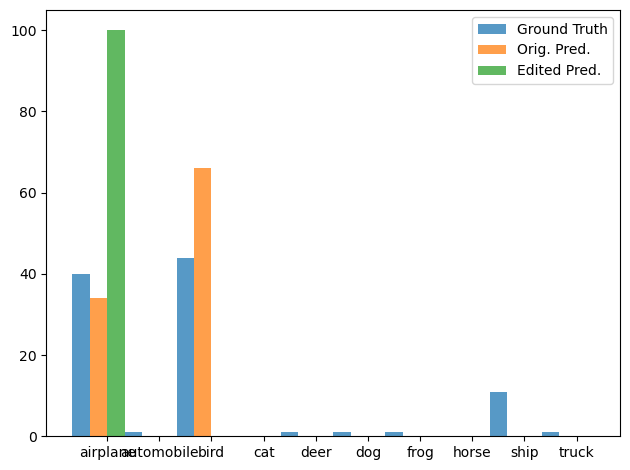

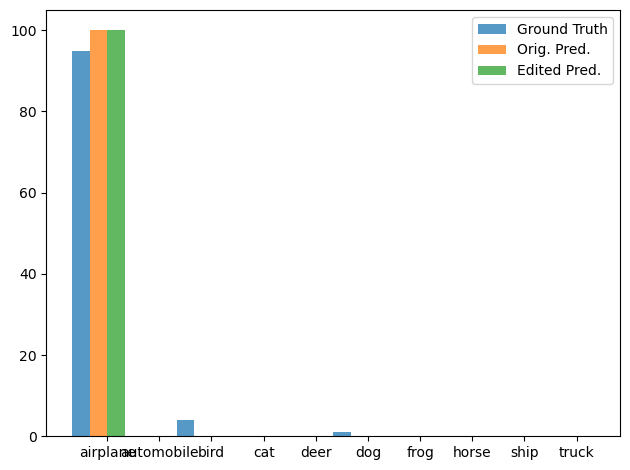

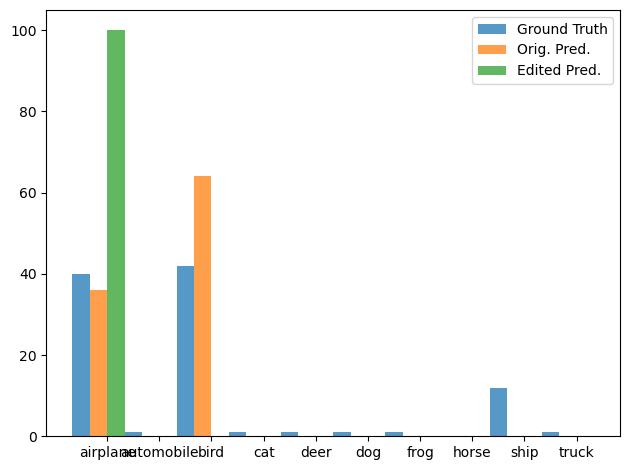

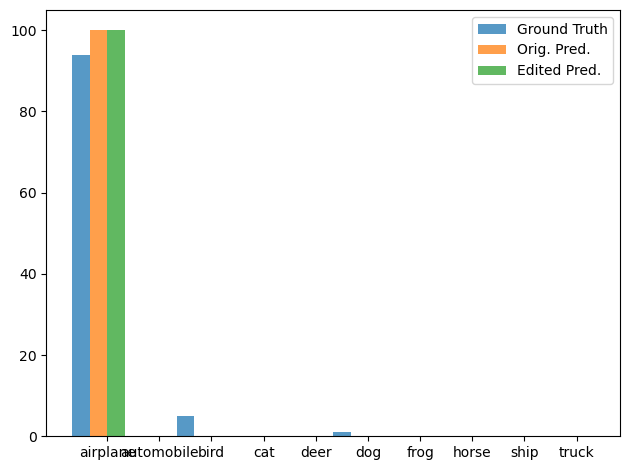

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_masked_softmax/models
Finished trial 30/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_masked_softmax
(0126_174923) Starting Trial 31/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.17it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:44<00:00, 889.61it/s]

Loss (orig, final): 0.1009761244058609 0.002995207207277417
L2 norm of weight change: 0.46768274903297424
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.48it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6514, 5287,    0, 4127, 4277, 2739, 5612, 5041, 4526, 4731]), 'TN': array([51235, 61215, 63000, 59351, 60017, 62068, 61278, 61752, 61948,
       60990]), 'FPs': array([11765,  1785,     0,  3649,  2983,   932,  1722,  1248,  1052,
        2010]), 'FNs': array([ 486, 1713, 7000, 2873, 2723, 4261, 1388, 1959, 2474, 2269]), 'accuracy': 0.6122, 'per_class_accuracy': array([0.82498571, 0.95002857, 0.9       , 0.90682857, 0.91848571,
       0.92581429, 0.95557143, 0.95418571, 0.94962857, 0.93887143]), 'per_class_accuracy_mean': 0.9224399999999999, 'precision': array([0.35636523, 0.74759615, 0.        , 0.5307356 , 0.58911846,
       0.74611822, 0.76520316, 0.80155828, 0.81140194, 0.70182466]), 'precision_mean': 0.6049921690606392, 'recall': array([0.93057143, 0.75528571, 0.        , 0.58957143, 0.611     ,
       0.39128571, 0.80171429, 0.72014286, 0.64657143, 0.67585714]), 'recall_mean': 0.6122, 'predicted_class_distribution': array([18279,  7072,     0,  77

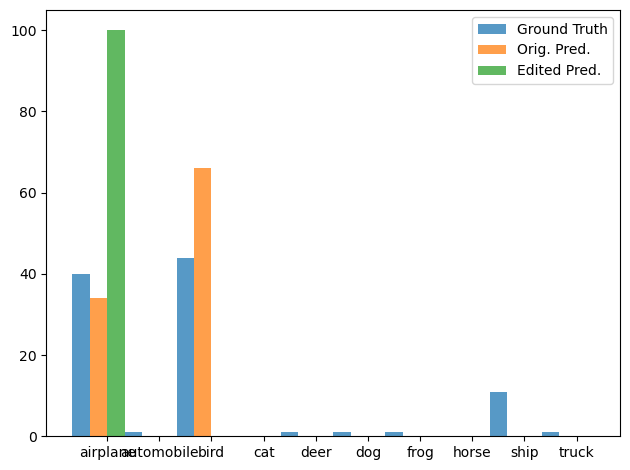

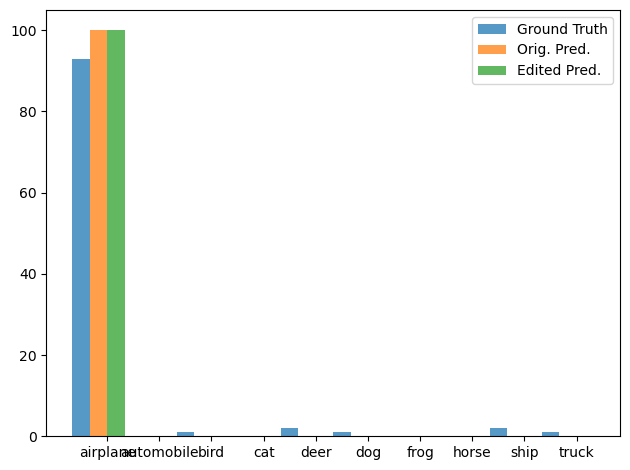

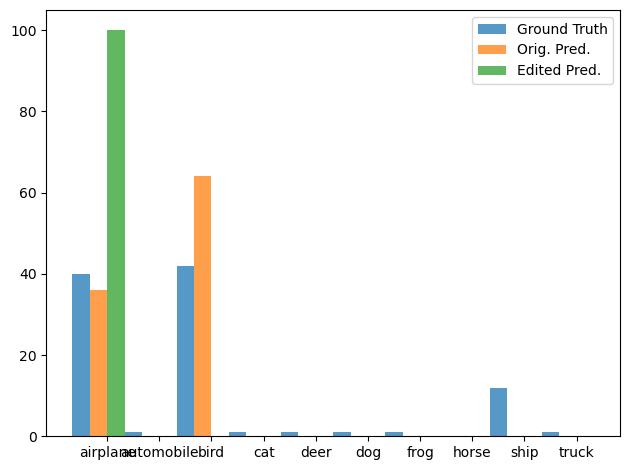

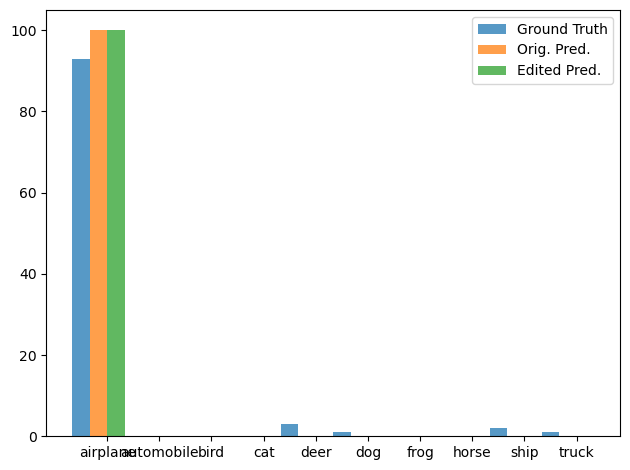

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_gaussian_softmax/models
Finished trial 31/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_6124/felzenszwalb_gaussian_softmax
(0126_175029) Starting Trial 32/158...
Current run_id: 0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validati

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.75it/s]

Loss (orig, final): 0.13320006430149078 0.004097485914826393
L2 norm of weight change: 0.5570598840713501
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.30it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6583, 5269,    0, 4035, 4154, 2626, 5455, 4946, 4366, 4679]), 'TN': array([49110, 61232, 63000, 59608, 60325, 62210, 61572, 61849, 62087,
       61120]), 'FPs': array([13890,  1768,     0,  3392,  2675,   790,  1428,  1151,   913,
        1880]), 'FNs': array([ 417, 1731, 7000, 2965, 2846, 4374, 1545, 2054, 2634, 2321]), 'accuracy': 0.6016142857142858, 'per_class_accuracy': array([0.79561429, 0.95001429, 0.9       , 0.90918571, 0.92112857,
       0.92622857, 0.95752857, 0.95421429, 0.94932857, 0.93998571]), 'per_class_accuracy_mean': 0.9203228571428571, 'precision': array([0.32154545, 0.74875657, 0.        , 0.543288  , 0.60828818,
       0.76873536, 0.79253233, 0.81121863, 0.82705058, 0.71337094]), 'precision_mean': 0.613478604807508, 'recall': array([0.94042857, 0.75271429, 0.        , 0.57642857, 0.59342857,
       0.37514286, 0.77928571, 0.70657143, 0.62371429, 0.66842857]), 'recall_mean': 0.6016142857142858, 'predicted_class_distribution': array([2

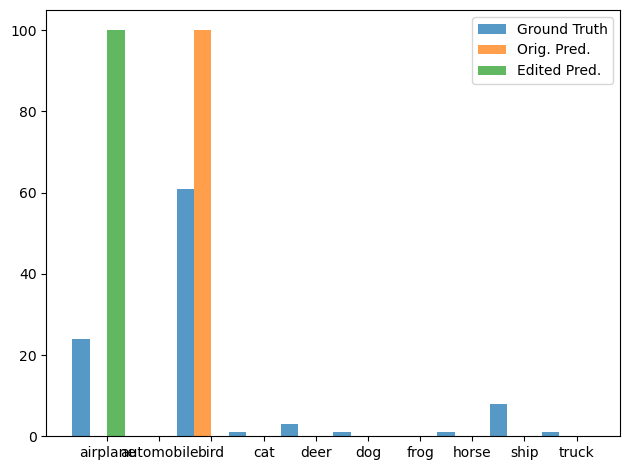

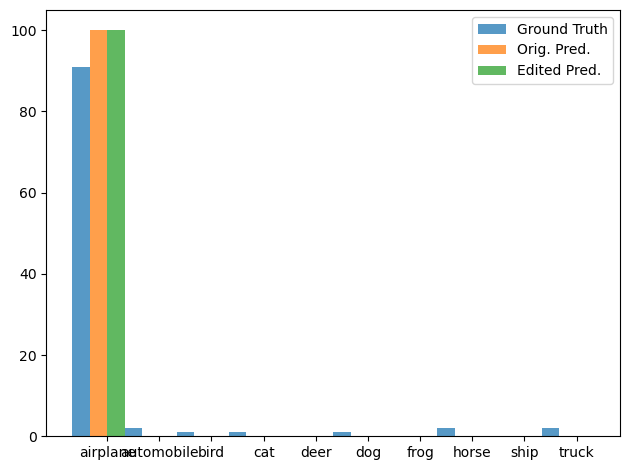

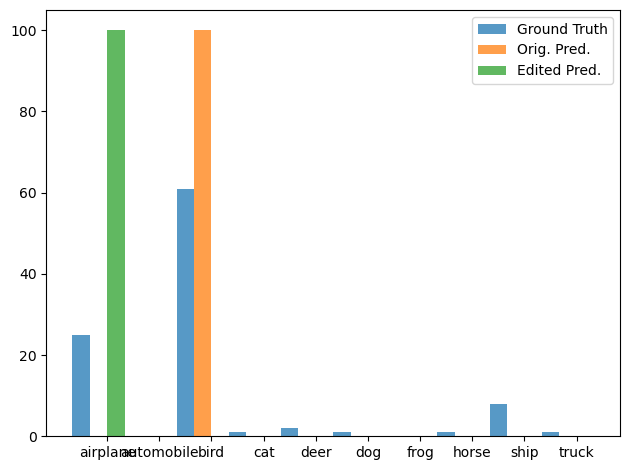

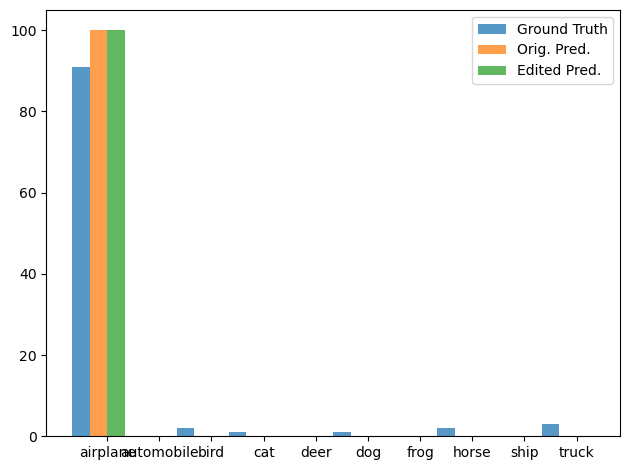

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_masked_softmax/models
Finished trial 32/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_masked_softmax
(0126_175137) Starting Trial 33/158...
Current run_id: 0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validat

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.38it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:44<00:00, 889.86it/s]

Loss (orig, final): 0.06532774865627289 0.007102226838469505
L2 norm of weight change: 0.2400803118944168
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.42it/s]


Post-edit metrics: {'TP': array([6340, 5299, 4581, 4115, 4316, 2810, 5707, 5090, 4711, 4740]), 'TN': array([58790, 61206, 60877, 59237, 59985, 61991, 61036, 61745, 61776,
       61066]), 'FPs': array([4210, 1794, 2123, 3763, 3015, 1009, 1964, 1255, 1224, 1934]), 'FNs': array([ 660, 1701, 2419, 2885, 2684, 4190, 1293, 1910, 2289, 2260]), 'accuracy': 0.6815571428571429, 'per_class_accuracy': array([0.93042857, 0.95007143, 0.93511429, 0.90502857, 0.91858571,
       0.92572857, 0.95347143, 0.95478571, 0.94981429, 0.94008571]), 'per_class_accuracy_mean': 0.9363114285714286, 'precision': array([0.60094787, 0.74707458, 0.68332339, 0.5223407 , 0.58873278,
       0.73579471, 0.7439708 , 0.80220646, 0.7937658 , 0.71021876]), 'precision_mean': 0.6928375838152949, 'recall': array([0.90571429, 0.757     , 0.65442857, 0.58785714, 0.61657143,
       0.40142857, 0.81528571, 0.72714286, 0.673     , 0.67714286]), 'recall_mean': 0.6815571428571429, 'predicted_class_distribution': array([10550,  7093,  67

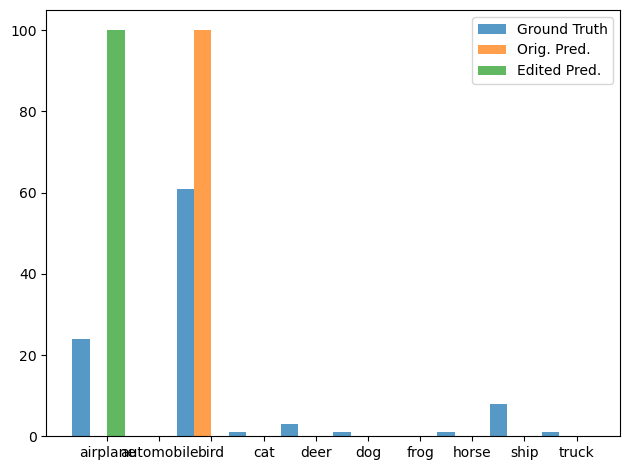

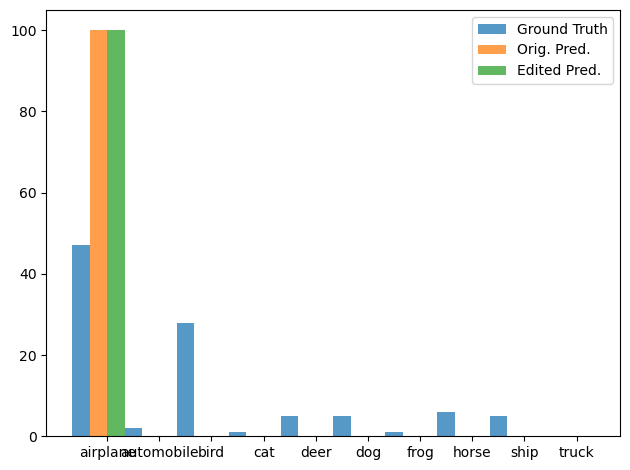

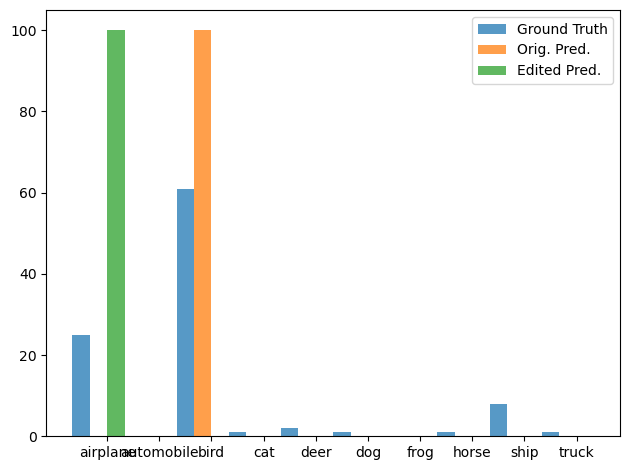

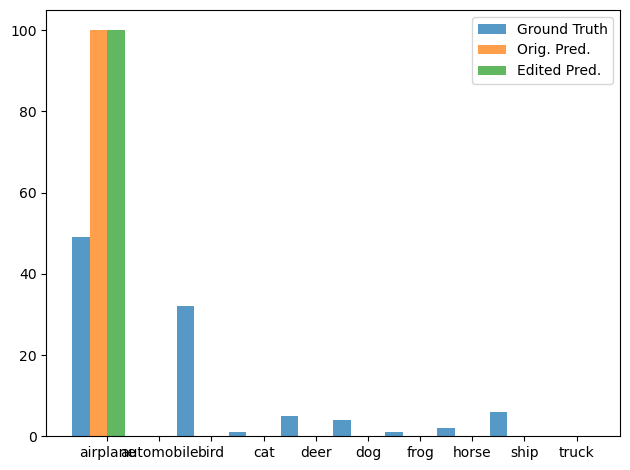

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_gaussian_softmax/models
Finished trial 33/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03577672_10632/felzenszwalb_gaussian_softmax
(0126_175244) Starting Trial 34/158...
Current run_id: 0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for valid

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.06it/s]

Loss (orig, final): 0.15143899619579315 0.006072826683521271
L2 norm of weight change: 0.7272146344184875
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.24it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6905, 5072, 3919, 3573, 3355, 2137, 5549, 5146,    0, 4184]), 'TN': array([44245, 61450, 61821, 60558, 61555, 62617, 61377, 61251, 63000,
       61966]), 'FPs': array([18755,  1550,  1179,  2442,  1445,   383,  1623,  1749,     0,
        1034]), 'FNs': array([  95, 1928, 3081, 3427, 3645, 4863, 1451, 1854, 7000, 2816]), 'accuracy': 0.5691428571428572, 'per_class_accuracy': array([0.73071429, 0.95031429, 0.93914286, 0.91615714, 0.92728571,
       0.92505714, 0.95608571, 0.94852857, 0.9       , 0.945     ]), 'per_class_accuracy_mean': 0.9138285714285714, 'precision': array([0.26909587, 0.76593174, 0.76873284, 0.59401496, 0.69895833,
       0.84801587, 0.77370329, 0.74633793, 0.        , 0.80183979]), 'precision_mean': 0.6266630619048172, 'recall': array([0.98642857, 0.72457143, 0.55985714, 0.51042857, 0.47928571,
       0.30528571, 0.79271429, 0.73514286, 0.        , 0.59771429]), 'recall_mean': 0.5691428571428572, 'predicted_class_distribution': array([

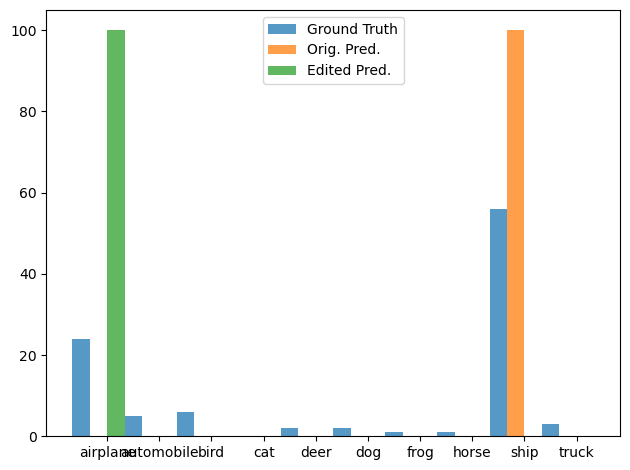

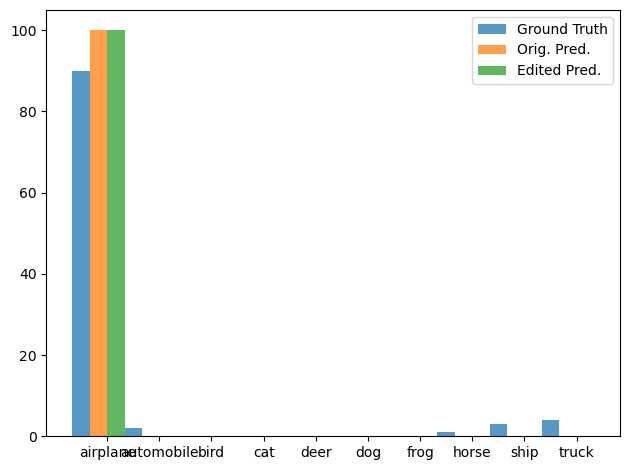

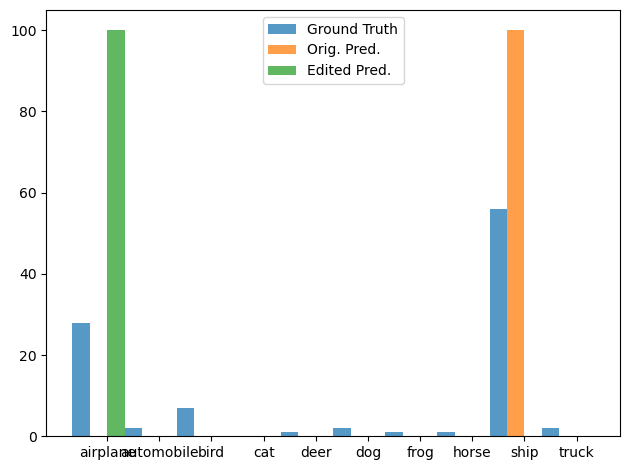

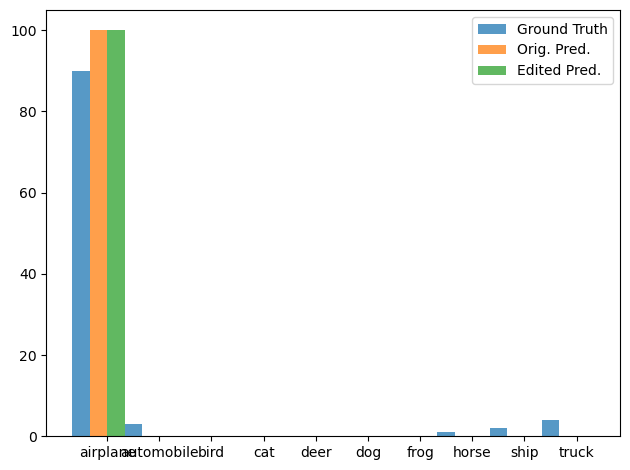

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_masked_softmax/models
Finished trial 34/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_masked_softmax
(0126_175349) Starting Trial 35/158...
Current run_id: 0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validat

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.98it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 888.17it/s]

Loss (orig, final): 0.09512794017791748 0.0037194739561527967
L2 norm of weight change: 0.41366931796073914
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.24it/s]


Post-edit metrics: {'TP': array([6717, 5186, 4736, 3855, 4007, 2441, 5606, 5100, 3154, 4595]), 'TN': array([53800, 61361, 60402, 59954, 60566, 62407, 61207, 61607, 62750,
       61343]), 'FPs': array([9200, 1639, 2598, 3046, 2434,  593, 1793, 1393,  250, 1657]), 'FNs': array([ 283, 1814, 2264, 3145, 2993, 4559, 1394, 1900, 3846, 2405]), 'accuracy': 0.6485285714285715, 'per_class_accuracy': array([0.86452857, 0.95067143, 0.93054286, 0.91155714, 0.92247143,
       0.9264    , 0.95447143, 0.95295714, 0.94148571, 0.94197143]), 'per_class_accuracy_mean': 0.9297057142857141, 'precision': array([0.42200163, 0.75985348, 0.64575948, 0.55861469, 0.62210837,
       0.80454845, 0.75766996, 0.78546127, 0.92655699, 0.73496481]), 'precision_mean': 0.7017539126829654, 'recall': array([0.95957143, 0.74085714, 0.67657143, 0.55071429, 0.57242857,
       0.34871429, 0.80085714, 0.72857143, 0.45057143, 0.65642857]), 'recall_mean': 0.6485285714285713, 'predicted_class_distribution': array([15917,  6825,  73

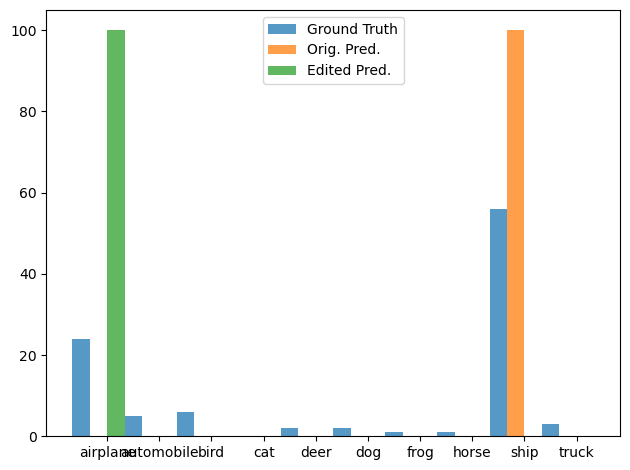

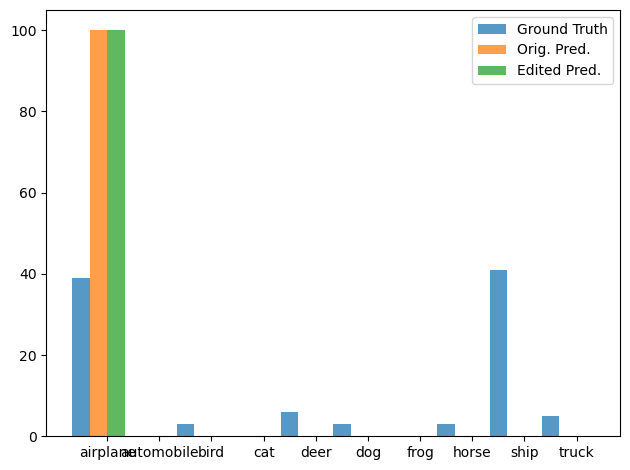

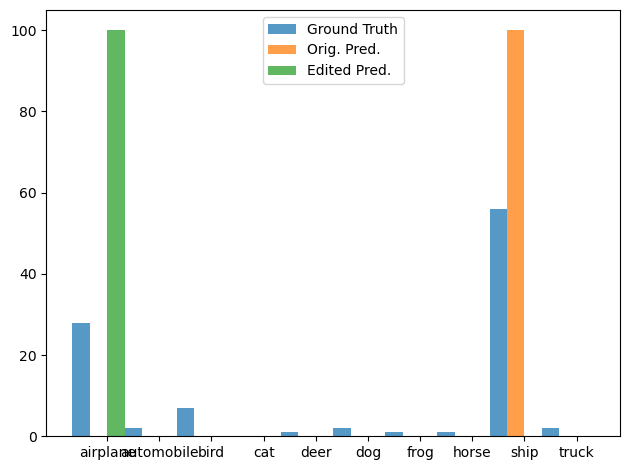

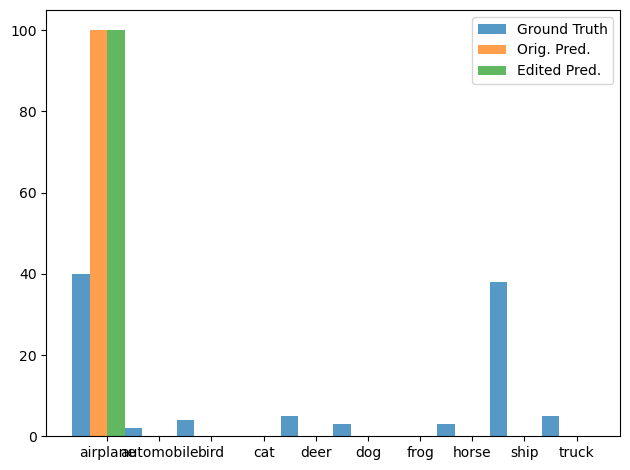

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_gaussian_softmax/models
Finished trial 35/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04160586_14609/felzenszwalb_gaussian_softmax
(0126_175459) Starting Trial 36/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_9637/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_9637/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validat

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.60it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 872.06it/s]

Loss (orig, final): 0.14133170247077942 0.005188180133700371
L2 norm of weight change: 0.6880178451538086
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.19it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6935, 5024, 4090, 3251,   17, 2287, 5162, 4507,    0, 3694]), 'TN': array([35728, 61510, 61646, 61028, 63000, 62531, 62009, 62162, 63000,
       62353]), 'FPs': array([27272,  1490,  1354,  1972,     0,   469,   991,   838,     0,
         647]), 'FNs': array([  65, 1976, 2910, 3749, 6983, 4713, 1838, 2493, 7000, 3306]), 'accuracy': 0.49952857142857143, 'per_class_accuracy': array([0.60947143, 0.95048571, 0.93908571, 0.91827143, 0.90024286,
       0.92597143, 0.95958571, 0.95241429, 0.9       , 0.94352857]), 'per_class_accuracy_mean': 0.8999057142857142, 'precision': array([0.20273628, 0.7712619 , 0.75128582, 0.62243921, 1.        ,
       0.82982583, 0.83894035, 0.84321796, 0.        , 0.850956  ]), 'precision_mean': 0.6710663360404965, 'recall': array([0.99071429, 0.71771429, 0.58428571, 0.46442857, 0.00242857,
       0.32671429, 0.73742857, 0.64385714, 0.        , 0.52771429]), 'recall_mean': 0.49952857142857143, 'predicted_class_distribution': array

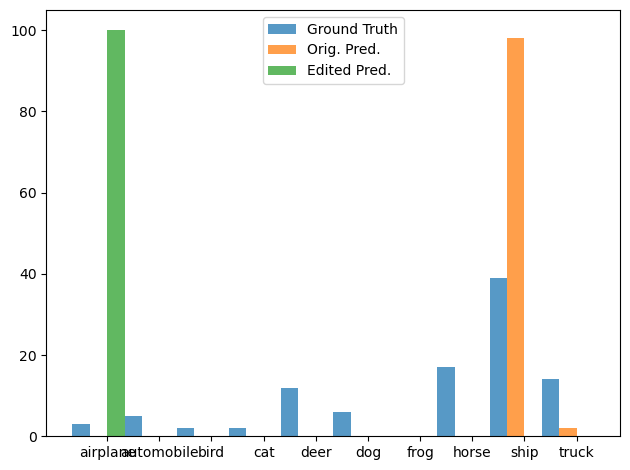

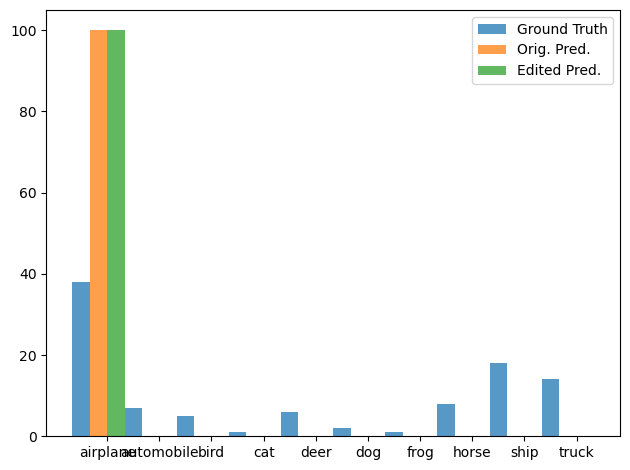

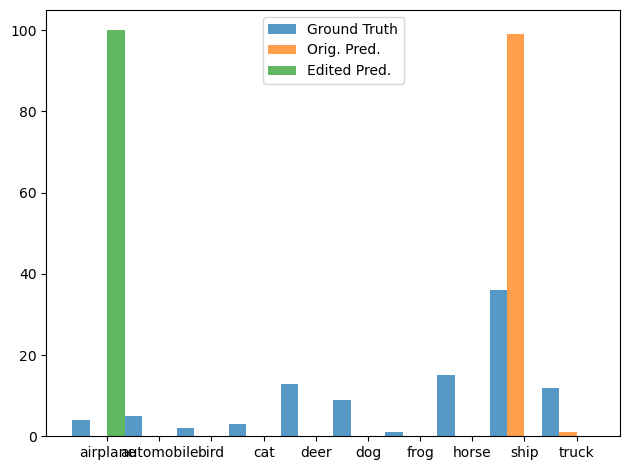

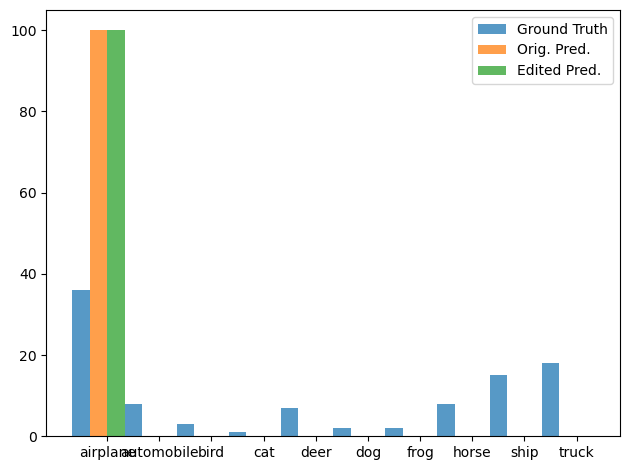

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_9637/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_9637/felzenszwalb_masked_softmax/models
Finished trial 36/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_9637/felzenszwalb_masked_softmax
(0126_175608) Starting Trial 37/158...
Current run_id: 0126_170417/results/airplane-train-n04012482_590/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_590/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.17it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0557, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 886.86it/s]

Loss (orig, final): 0.2076798677444458 0.055699385702610016
L2 norm of weight change: 0.6051921844482422
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:25<00:00, 10.90it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6724, 5324, 5130, 3965, 3912, 2665, 5700, 5335,    0, 4437]), 'TN': array([53081, 61216, 59582, 59560, 60808, 62185, 60910, 61180, 63000,
       61670]), 'FPs': array([9919, 1784, 3418, 3440, 2192,  815, 2090, 1820,    0, 1330]), 'FNs': array([ 276, 1676, 1870, 3035, 3088, 4335, 1300, 1665, 7000, 2563]), 'accuracy': 0.6170285714285715, 'per_class_accuracy': array([0.85435714, 0.95057143, 0.92445714, 0.9075    , 0.92457143,
       0.92642857, 0.95157143, 0.95021429, 0.9       , 0.94438571]), 'per_class_accuracy_mean': 0.9234057142857143, 'precision': array([0.4040137 , 0.74901519, 0.60014038, 0.53544902, 0.64089122,
       0.7658046 , 0.73170732, 0.74563242, 0.        , 0.76937749]), 'precision_mean': 0.5942031349403336, 'recall': array([0.96057143, 0.76057143, 0.73285714, 0.56642857, 0.55885714,
       0.38071429, 0.81428571, 0.76214286, 0.        , 0.63385714]), 'recall_mean': 0.6170285714285714, 'predicted_class_distribution': array([16643,  7108,  85

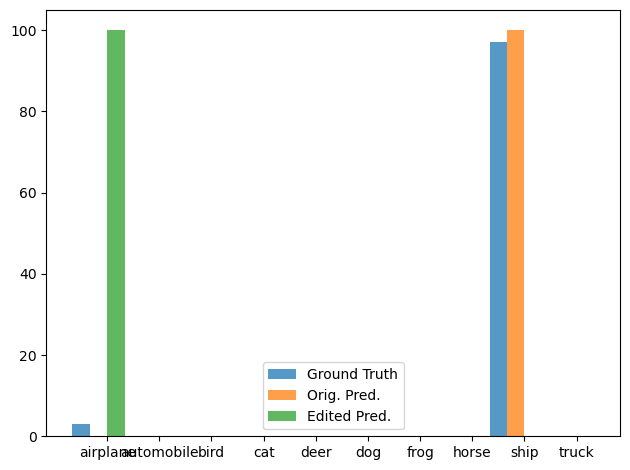

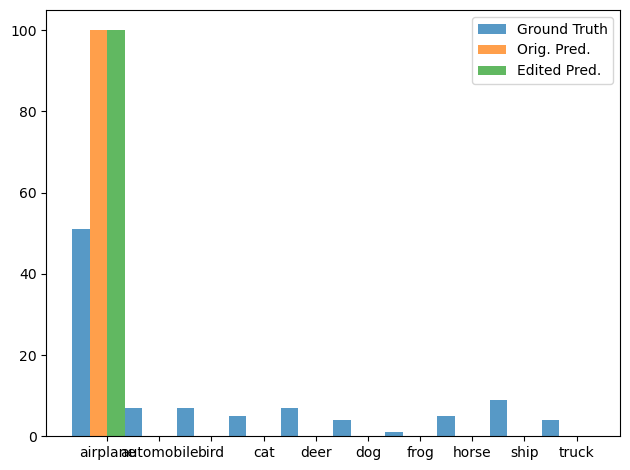

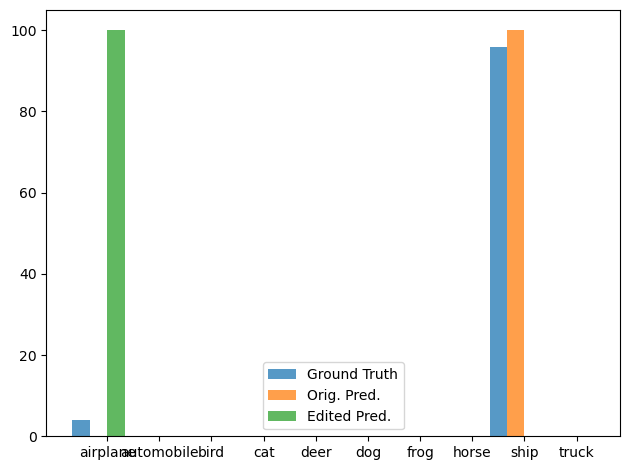

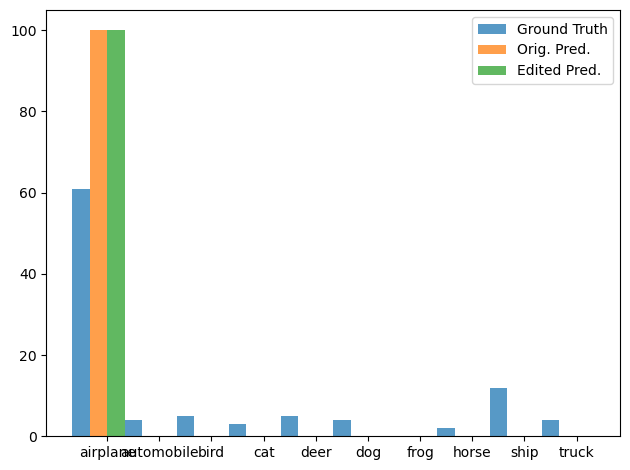

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_590/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_590/felzenszwalb_masked_softmax/models
Finished trial 37/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n04012482_590/felzenszwalb_masked_softmax
(0126_175732) Starting Trial 38/158...
Current run_id: 0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.50it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 888.18it/s]

Loss (orig, final): 0.12279614061117172 0.005759802181273699
L2 norm of weight change: 0.4999115467071533
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.69it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6524, 5186, 5505, 3554, 4131, 2963, 5371, 4742, 4071,    0]), 'TN': array([51261, 61393, 57536, 60551, 60332, 61838, 61597, 62189, 62350,
       63000]), 'FPs': array([11739,  1607,  5464,  2449,  2668,  1162,  1403,   811,   650,
           0]), 'FNs': array([ 476, 1814, 1495, 3446, 2869, 4037, 1629, 2258, 2929, 7000]), 'accuracy': 0.6006714285714285, 'per_class_accuracy': array([0.8255    , 0.95112857, 0.90058571, 0.91578571, 0.9209    ,
       0.92572857, 0.95668571, 0.95615714, 0.94887143, 0.9       ]), 'per_class_accuracy_mean': 0.9201342857142857, 'precision': array([0.35722499, 0.76343295, 0.5018689 , 0.59203731, 0.60758935,
       0.71830303, 0.79288456, 0.85395282, 0.86231731, 0.        ]), 'precision_mean': 0.6049611218282682, 'recall': array([0.932     , 0.74085714, 0.78642857, 0.50771429, 0.59014286,
       0.42328571, 0.76728571, 0.67742857, 0.58157143, 0.        ]), 'recall_mean': 0.6006714285714285, 'predicted_class_distribution': array([

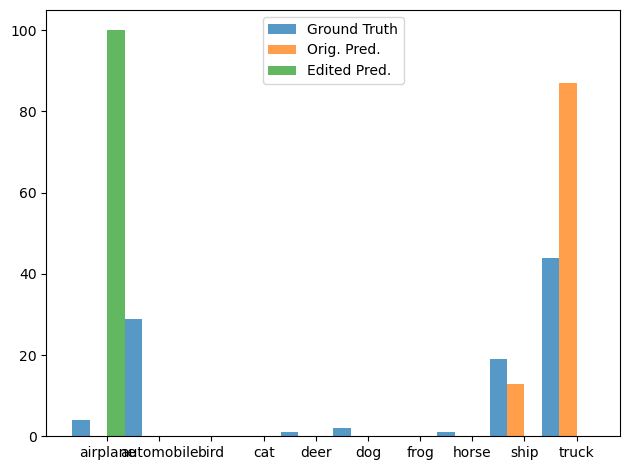

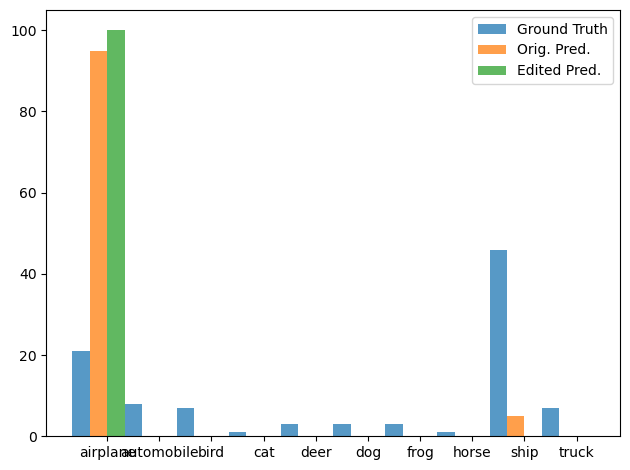

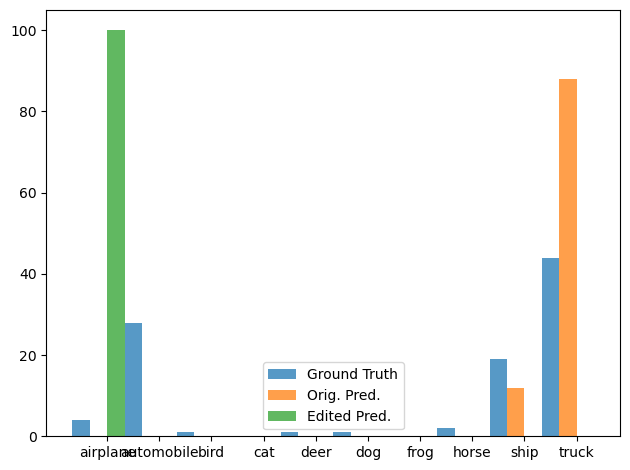

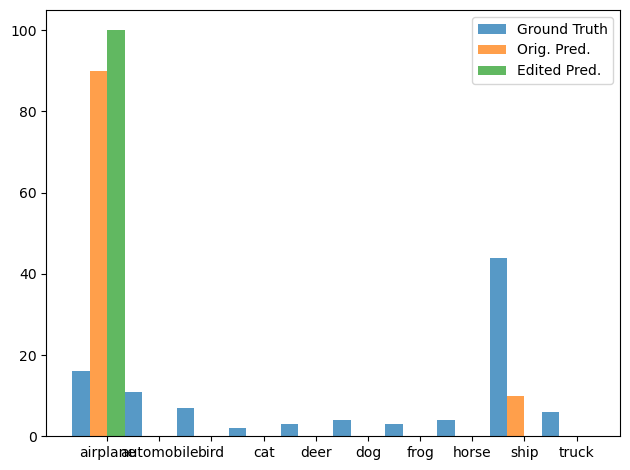

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_masked_softmax/models
Finished trial 38/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_masked_softmax
(0126_175844) Starting Trial 39/158...
Current run_id: 0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.73it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 885.60it/s]

Loss (orig, final): 0.12333233654499054 0.006508335471153259
L2 norm of weight change: 0.48980024456977844
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.28it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6381, 5267, 5707, 3393, 4165, 2996, 5328, 4671, 4338,    0]), 'TN': array([53066, 61284, 56035, 60808, 60260, 61793, 61648, 62319, 62033,
       63000]), 'FPs': array([9934, 1716, 6965, 2192, 2740, 1207, 1352,  681,  967,    0]), 'FNs': array([ 619, 1733, 1293, 3607, 2835, 4004, 1672, 2329, 2662, 7000]), 'accuracy': 0.6035142857142857, 'per_class_accuracy': array([0.84924286, 0.95072857, 0.88202857, 0.91715714, 0.92035714,
       0.92555714, 0.9568    , 0.957     , 0.94815714, 0.9       ]), 'per_class_accuracy_mean': 0.9207028571428572, 'precision': array([0.39111247, 0.75426035, 0.45036301, 0.60752014, 0.6031861 ,
       0.71282417, 0.79760479, 0.87275785, 0.81771913, 0.        ]), 'precision_mean': 0.6007348009118476, 'recall': array([0.91157143, 0.75242857, 0.81528571, 0.48471429, 0.595     ,
       0.428     , 0.76114286, 0.66728571, 0.61971429, 0.        ]), 'recall_mean': 0.6035142857142857, 'predicted_class_distribution': array([16315,  6983, 126

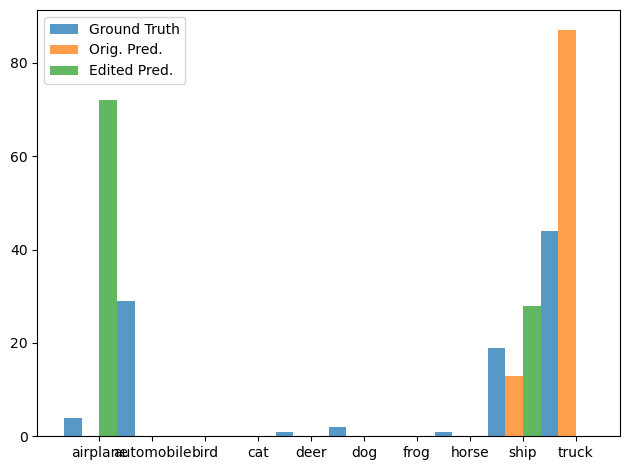

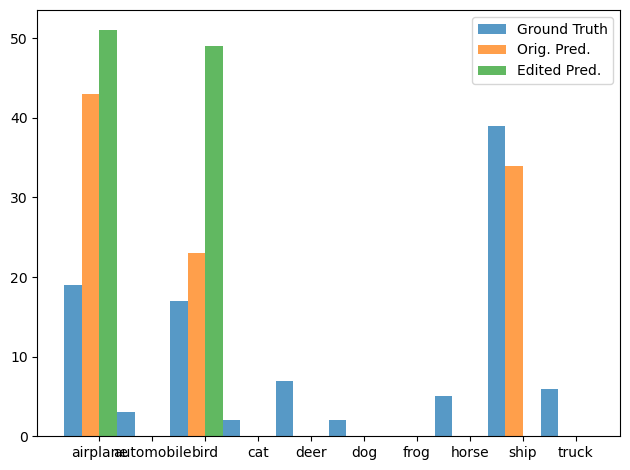

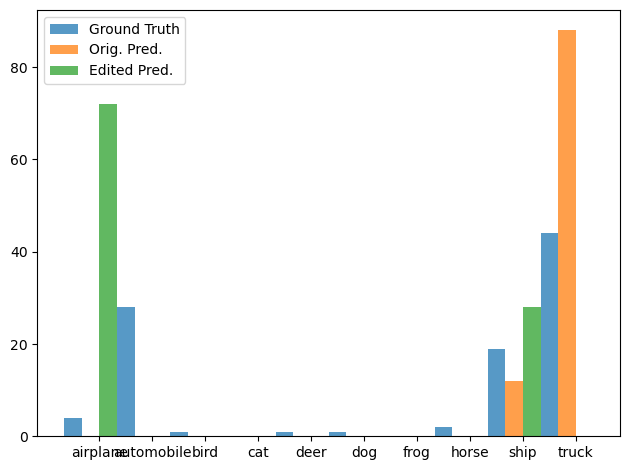

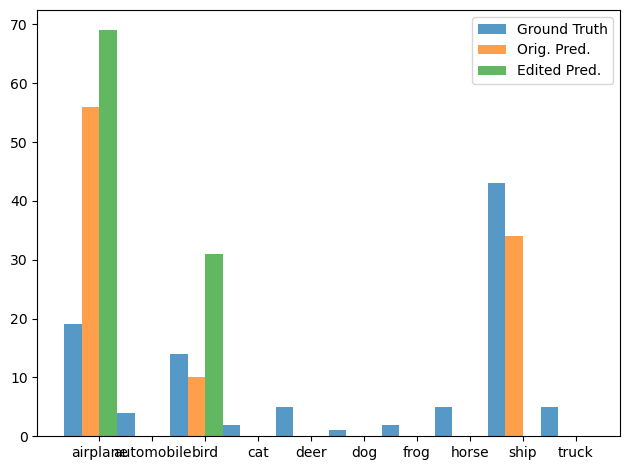

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_gaussian_softmax/models
Finished trial 39/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02690373_1044/felzenszwalb_gaussian_softmax
(0126_175952) Starting Trial 40/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_289/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.33it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.72it/s]

Loss (orig, final): 0.09500718861818314 0.003169696545228362
L2 norm of weight change: 0.3134859502315521
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.32it/s]


Post-edit metrics: {'TP': array([6417, 5382, 5262, 4010, 3188, 2862, 5506, 5103, 4449, 4591]), 'TN': array([56925, 61031, 59025, 59664, 61842, 61964, 61370, 61701, 61986,
       61262]), 'FPs': array([6075, 1969, 3975, 3336, 1158, 1036, 1630, 1299, 1014, 1738]), 'FNs': array([ 583, 1618, 1738, 2990, 3812, 4138, 1494, 1897, 2551, 2409]), 'accuracy': 0.6681428571428571, 'per_class_accuracy': array([0.90488571, 0.94875714, 0.91838571, 0.90962857, 0.929     ,
       0.92608571, 0.95537143, 0.95434286, 0.94907143, 0.94075714]), 'per_class_accuracy_mean': 0.9336285714285714, 'precision': array([0.51368876, 0.73214529, 0.56966548, 0.54587531, 0.73354809,
       0.73422268, 0.77158072, 0.79709466, 0.8143877 , 0.72539106]), 'precision_mean': 0.6937599729263593, 'recall': array([0.91671429, 0.76885714, 0.75171429, 0.57285714, 0.45542857,
       0.40885714, 0.78657143, 0.729     , 0.63557143, 0.65585714]), 'recall_mean': 0.6681428571428573, 'predicted_class_distribution': array([12492,  7351,  92

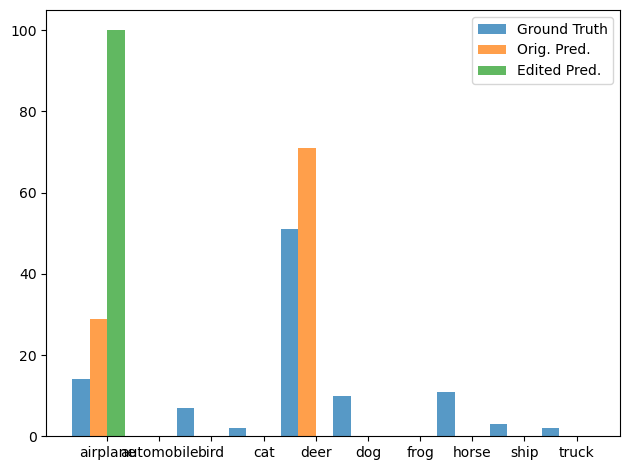

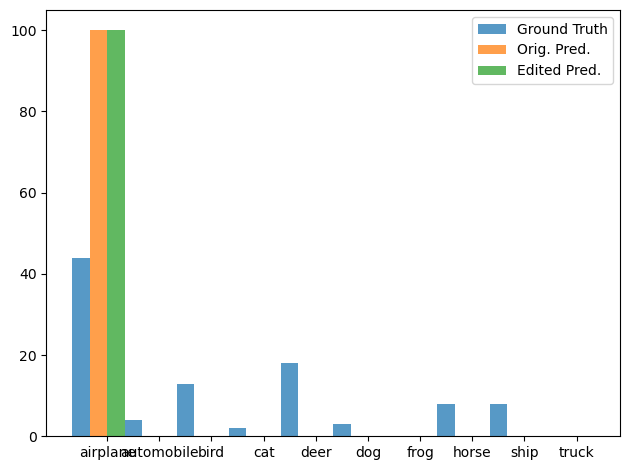

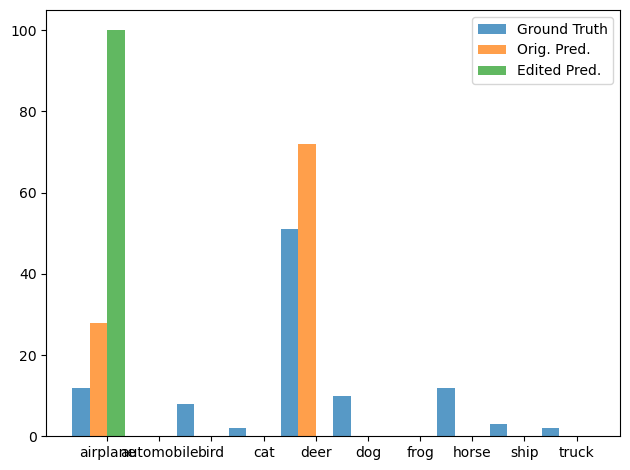

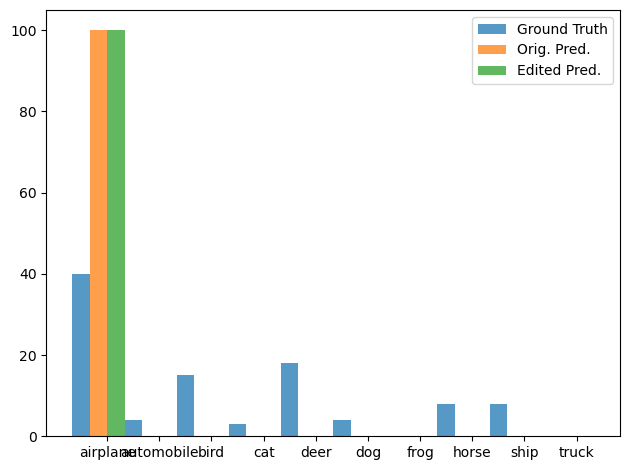

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_masked_softmax/models
Finished trial 40/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_masked_softmax
(0126_180058) Starting Trial 41/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_289/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.22it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 871.95it/s]

Loss (orig, final): 0.0619896724820137 0.0044650183990597725
L2 norm of weight change: 0.21403087675571442
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.64it/s]


Post-edit metrics: {'TP': array([6302, 5408, 5273, 3993, 3688, 2943, 5626, 5171, 4584, 4659]), 'TN': array([59057, 61028, 59111, 59581, 61221, 61853, 61116, 61620, 61890,
       61170]), 'FPs': array([3943, 1972, 3889, 3419, 1779, 1147, 1884, 1380, 1110, 1830]), 'FNs': array([ 698, 1592, 1727, 3007, 3312, 4057, 1374, 1829, 2416, 2341]), 'accuracy': 0.6806714285714286, 'per_class_accuracy': array([0.9337    , 0.94908571, 0.91977143, 0.9082    , 0.92727143,
       0.92565714, 0.95345714, 0.95415714, 0.94962857, 0.94041429]), 'per_class_accuracy_mean': 0.9361342857142858, 'precision': array([0.61512933, 0.73279133, 0.57552936, 0.53872099, 0.67459301,
       0.7195599 , 0.74913449, 0.78934514, 0.80505796, 0.71798428]), 'precision_mean': 0.6917845789833132, 'recall': array([0.90028571, 0.77257143, 0.75328571, 0.57042857, 0.52685714,
       0.42042857, 0.80371429, 0.73871429, 0.65485714, 0.66557143]), 'recall_mean': 0.6806714285714286, 'predicted_class_distribution': array([10245,  7380,  91

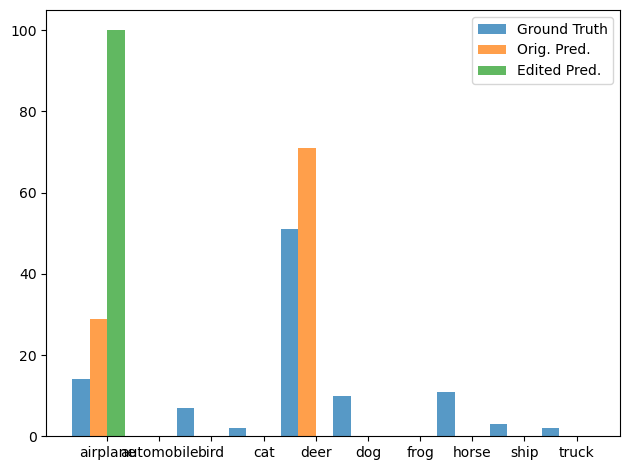

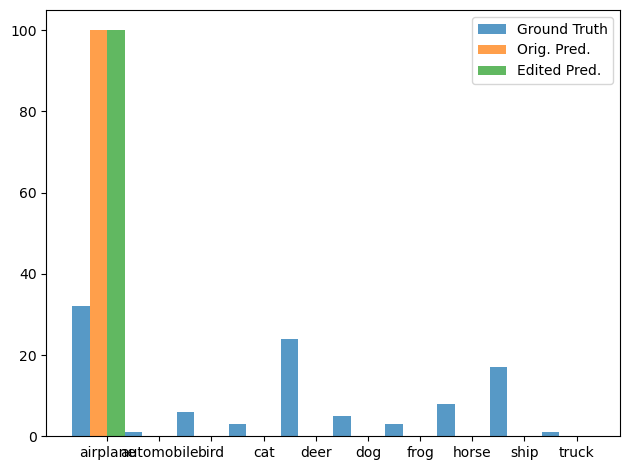

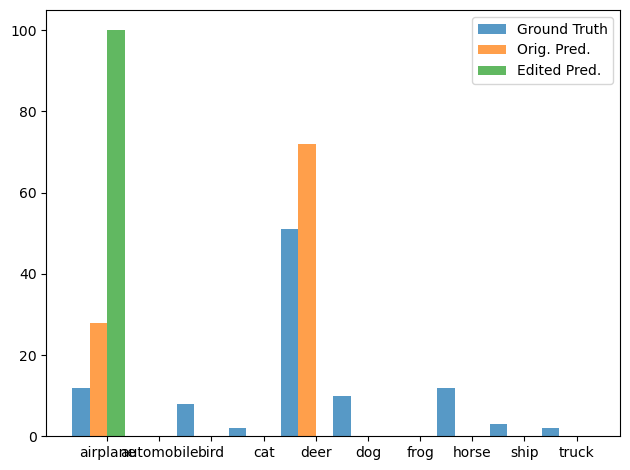

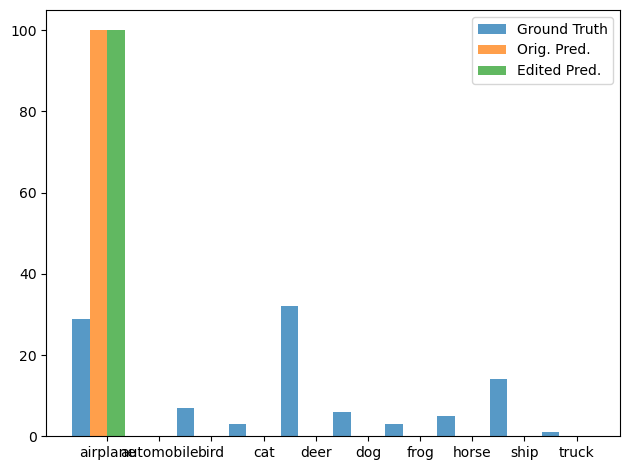

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_gaussian_softmax/models
Finished trial 41/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_289/felzenszwalb_gaussian_softmax
(0126_180209) Starting Trial 42/158...
Current run_id: 0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
K

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.55it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.22it/s]

Loss (orig, final): 0.18946750462055206 0.011617142707109451
L2 norm of weight change: 0.6850278973579407
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 16.07it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6589, 5179, 5335, 3482, 4107, 2994, 5321, 4518, 4067,    0]), 'TN': array([49338, 61386, 58463, 60839, 60309, 61795, 61770, 62339, 62353,
       63000]), 'FPs': array([13662,  1614,  4537,  2161,  2691,  1205,  1230,   661,   647,
           0]), 'FNs': array([ 411, 1821, 1665, 3518, 2893, 4006, 1679, 2482, 2933, 7000]), 'accuracy': 0.5941714285714286, 'per_class_accuracy': array([0.79895714, 0.95092857, 0.9114    , 0.91887143, 0.92022857,
       0.92555714, 0.95844286, 0.9551    , 0.94885714, 0.9       ]), 'per_class_accuracy_mean': 0.9188342857142858, 'precision': array([0.32536665, 0.76240247, 0.54041734, 0.61704767, 0.60414828,
       0.71302691, 0.81224241, 0.87236918, 0.86274926, 0.        ]), 'precision_mean': 0.6109770169936467, 'recall': array([0.94128571, 0.73985714, 0.76214286, 0.49742857, 0.58671429,
       0.42771429, 0.76014286, 0.64542857, 0.581     , 0.        ]), 'recall_mean': 0.5941714285714286, 'predicted_class_distribution': array([

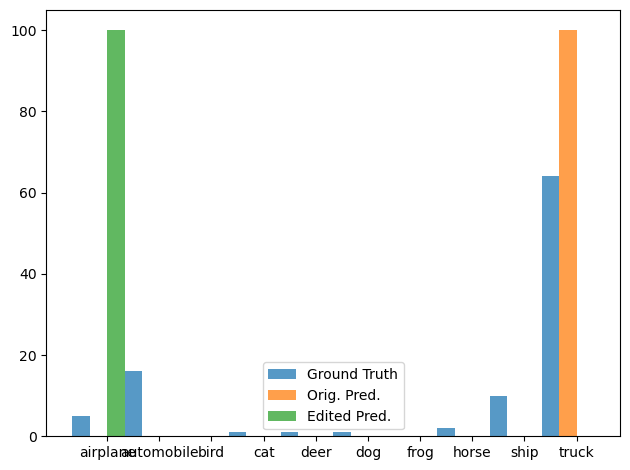

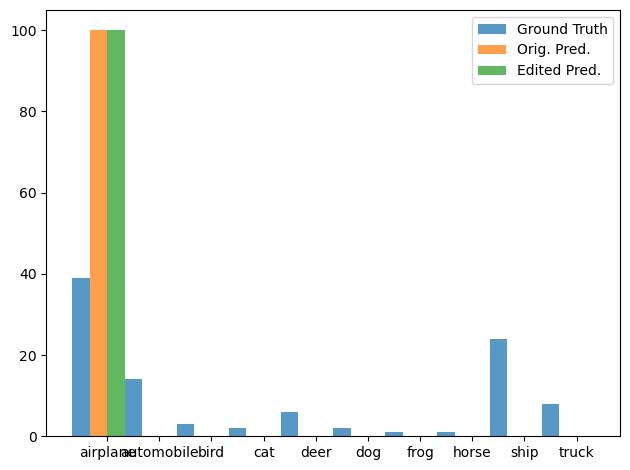

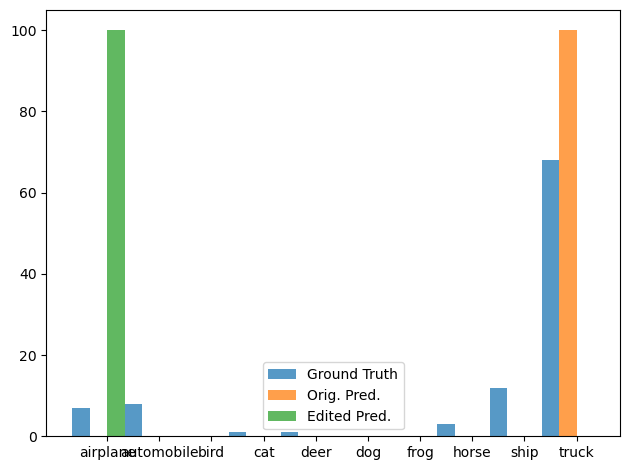

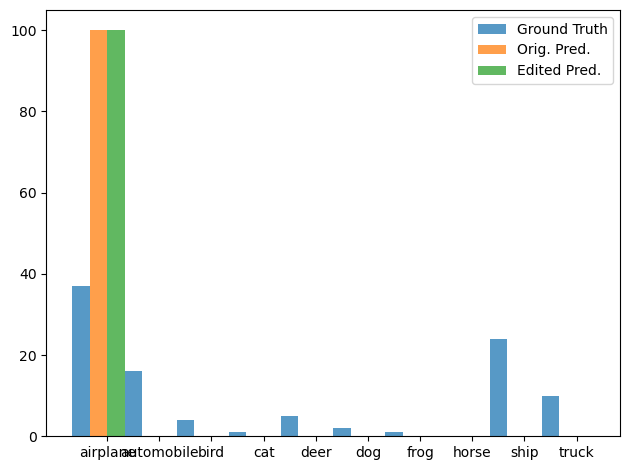

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_masked_softmax/models
Finished trial 42/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_masked_softmax
(0126_180324) Starting Trial 43/158...
Current run_id: 0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.72it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 880.21it/s]

Loss (orig, final): 0.10594575852155685 0.004728442989289761
L2 norm of weight change: 0.36143243312835693
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.37it/s]


Post-edit metrics: {'TP': array([6440, 5438, 5286, 3669, 4231, 2981, 5492, 4888, 4482, 2889]), 'TN': array([55637, 60995, 58830, 60364, 60131, 61786, 61408, 62025, 61915,
       62705]), 'FPs': array([7363, 2005, 4170, 2636, 2869, 1214, 1592,  975, 1085,  295]), 'FNs': array([ 560, 1562, 1714, 3331, 2769, 4019, 1508, 2112, 2518, 4111]), 'accuracy': 0.6542285714285714, 'per_class_accuracy': array([0.88681429, 0.94904286, 0.91594286, 0.91475714, 0.91945714,
       0.92524286, 0.95571429, 0.9559    , 0.94852857, 0.93705714]), 'per_class_accuracy_mean': 0.9308457142857142, 'precision': array([0.46656524, 0.73061937, 0.55901015, 0.58191911, 0.59591549,
       0.71060787, 0.77526821, 0.83370288, 0.80510149, 0.90734925]), 'precision_mean': 0.696605906660888, 'recall': array([0.92      , 0.77685714, 0.75514286, 0.52414286, 0.60442857,
       0.42585714, 0.78457143, 0.69828571, 0.64028571, 0.41271429]), 'recall_mean': 0.6542285714285715, 'predicted_class_distribution': array([13803,  7443,  945

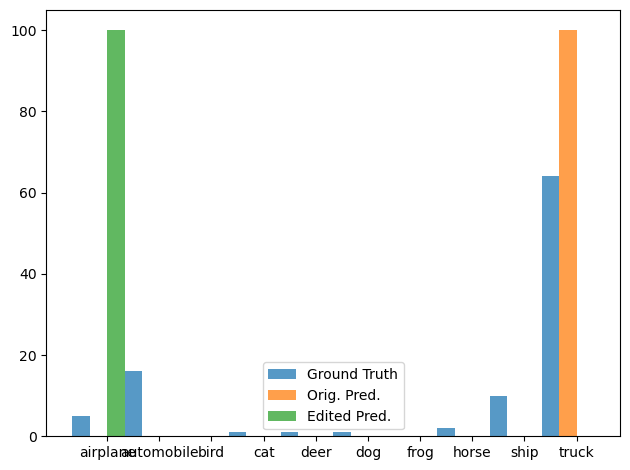

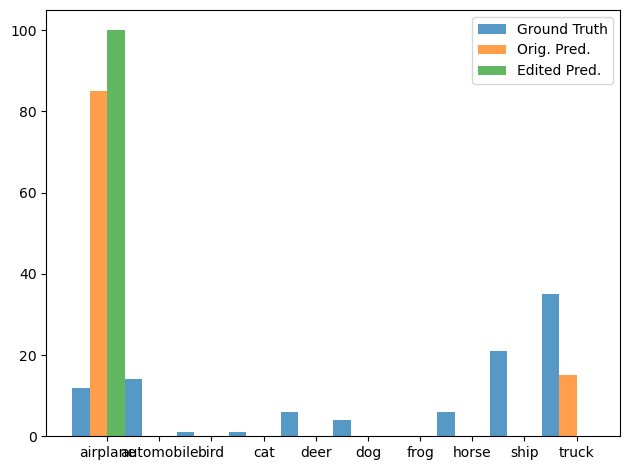

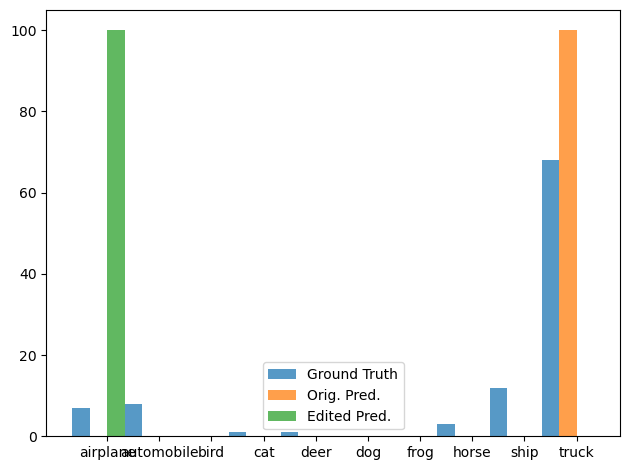

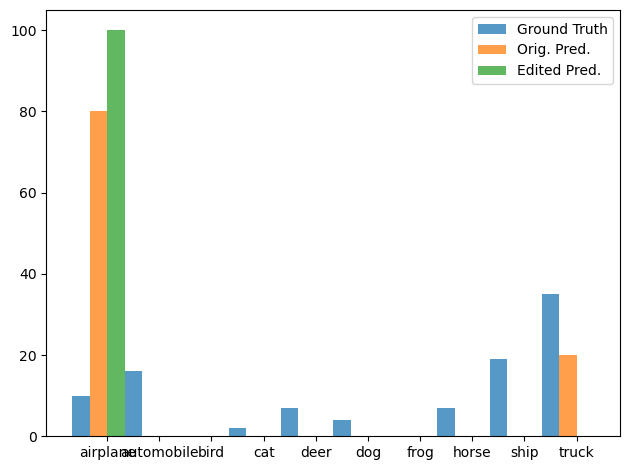

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_gaussian_softmax/models
Finished trial 43/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03595860_1465/felzenszwalb_gaussian_softmax
(0126_180441) Starting Trial 44/158...
Current run_id: 0126_170417/results/airplane-train-n02842573_1888/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1888/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.22it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0187, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 884.46it/s]

Loss (orig, final): 0.19089166820049286 0.01874176599085331
L2 norm of weight change: 0.7326051592826843
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.11it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6860, 5162, 4927,    1, 3509, 1981, 5417, 5181,    0, 3962]), 'TN': array([40813, 61282, 59898, 62997, 61418, 62716, 61581, 61123, 63000,
       62172]), 'FPs': array([22187,  1718,  3102,     3,  1582,   284,  1419,  1877,     0,
         828]), 'FNs': array([ 140, 1838, 2073, 6999, 3491, 5019, 1583, 1819, 7000, 3038]), 'accuracy': 0.5285714285714286, 'per_class_accuracy': array([0.68104286, 0.9492    , 0.92607143, 0.89997143, 0.92752857,
       0.92424286, 0.95711429, 0.9472    , 0.9       , 0.94477143]), 'per_class_accuracy_mean': 0.9057142857142857, 'precision': array([0.23616897, 0.7502907 , 0.61365052, 0.25      , 0.68925555,
       0.87461369, 0.79242247, 0.73406064, 0.        , 0.82713987]), 'precision_mean': 0.5767602402055754, 'recall': array([9.80000000e-01, 7.37428571e-01, 7.03857143e-01, 1.42857143e-04,
       5.01285714e-01, 2.83000000e-01, 7.73857143e-01, 7.40142857e-01,
       0.00000000e+00, 5.66000000e-01]), 'recall_mean': 0.5285714285

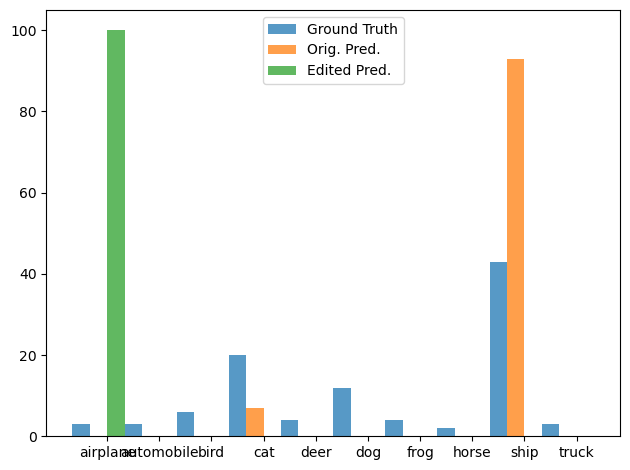

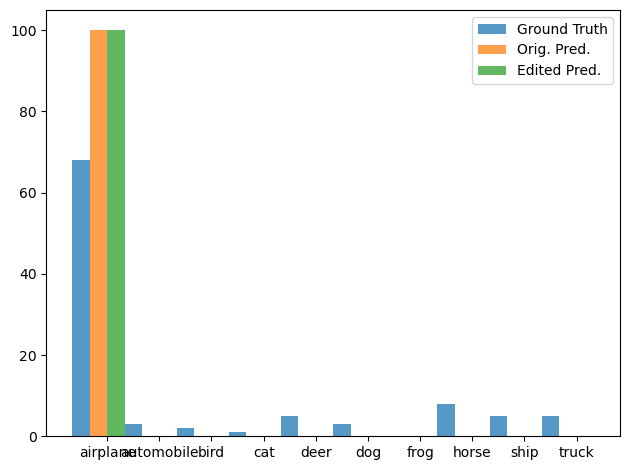

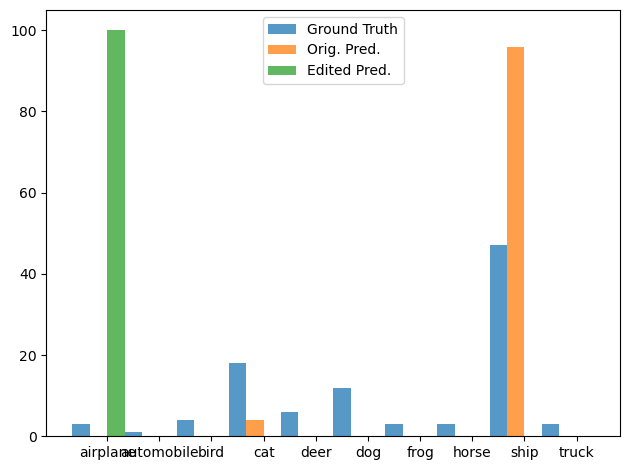

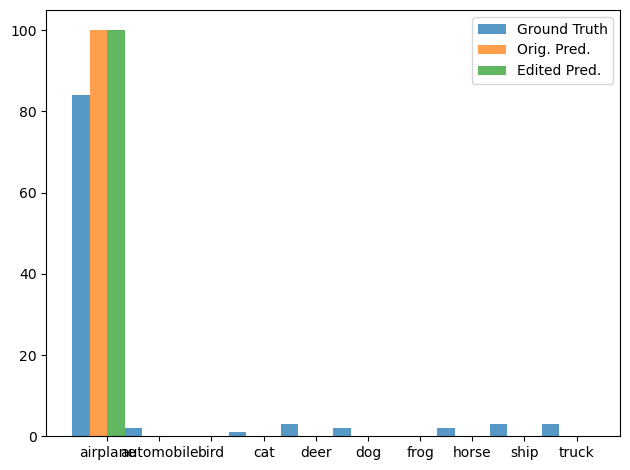

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1888/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1888/felzenszwalb_masked_softmax/models
Finished trial 44/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n02842573_1888/felzenszwalb_masked_softmax
(0126_180557) Starting Trial 45/158...
Current run_id: 0126_170417/results/airplane-train-n03798610_1313/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_1313/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.38it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0548, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 883.78it/s]

Loss (orig, final): 0.2158070206642151 0.0547604113817215
L2 norm of weight change: 0.6323466897010803
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:29<00:00,  9.20it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6757, 5278, 5110, 3896, 3966, 2568, 5685, 5319,    0, 4399]), 'TN': array([52416, 61307, 59640, 59775, 60717, 62293, 60932, 61170, 63000,
       61728]), 'FPs': array([10584,  1693,  3360,  3225,  2283,   707,  2068,  1830,     0,
        1272]), 'FNs': array([ 243, 1722, 1890, 3104, 3034, 4432, 1315, 1681, 7000, 2601]), 'accuracy': 0.6139714285714286, 'per_class_accuracy': array([0.84532857, 0.95121429, 0.925     , 0.90958571, 0.92404286,
       0.92658571, 0.95167143, 0.94984286, 0.9       , 0.94467143]), 'per_class_accuracy_mean': 0.9227942857142857, 'precision': array([0.38965458, 0.75713671, 0.60330579, 0.54711417, 0.63466155,
       0.78412214, 0.73326454, 0.74402014, 0.        , 0.77570093]), 'precision_mean': 0.5968980542833103, 'recall': array([0.96528571, 0.754     , 0.73      , 0.55657143, 0.56657143,
       0.36685714, 0.81214286, 0.75985714, 0.        , 0.62842857]), 'recall_mean': 0.6139714285714286, 'predicted_class_distribution': array([

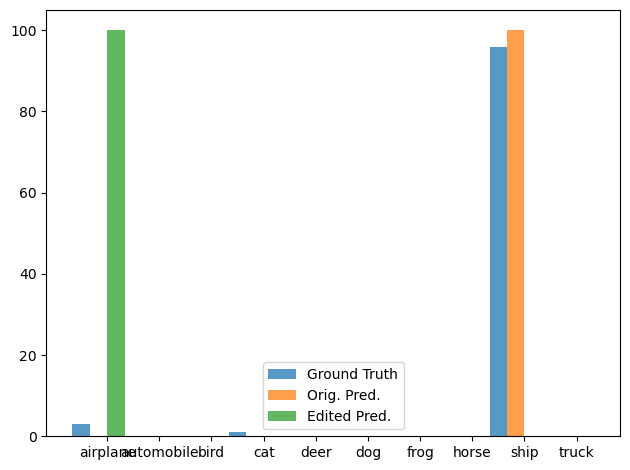

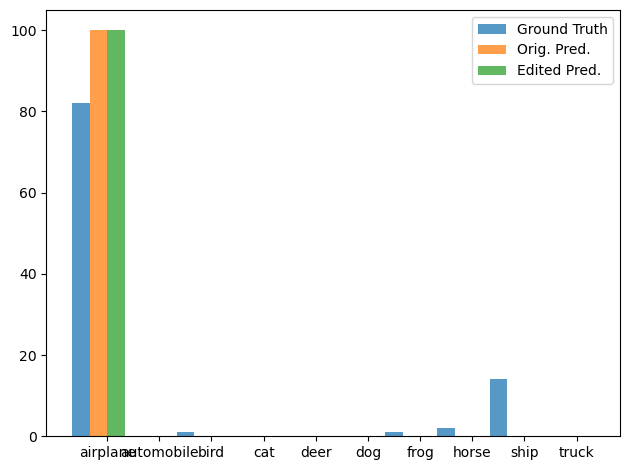

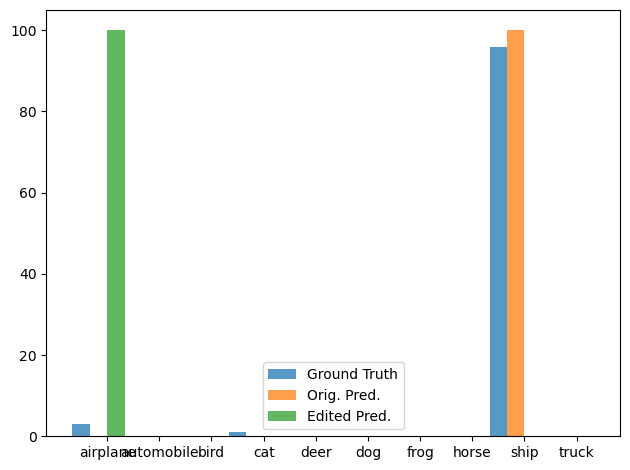

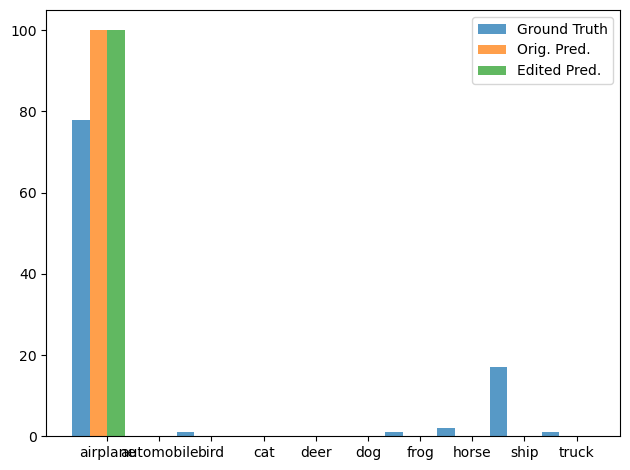

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_1313/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_1313/felzenszwalb_masked_softmax/models
Finished trial 45/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_1313/felzenszwalb_masked_softmax
(0126_180731) Starting Trial 46/158...
Current run_id: 0126_170417/results/airplane-train-n03798610_853/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:22<00:00, 12.36it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.26it/s]

Loss (orig, final): 0.13470502197742462 0.003914096392691135
L2 norm of weight change: 0.5192979574203491
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.90it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6537, 5296,    0, 4067, 4225, 2700, 5502, 4992, 4492, 4690]), 'TN': array([50116, 61199, 63000, 59519, 60170, 62121, 61504, 61835, 61971,
       61066]), 'FPs': array([12884,  1801,     0,  3481,  2830,   879,  1496,  1165,  1029,
        1934]), 'FNs': array([ 463, 1704, 7000, 2933, 2775, 4300, 1498, 2008, 2508, 2310]), 'accuracy': 0.6071571428571428, 'per_class_accuracy': array([0.80932857, 0.94992857, 0.9       , 0.90837143, 0.91992857,
       0.92601429, 0.95722857, 0.95467143, 0.94947143, 0.93937143]), 'per_class_accuracy_mean': 0.9214314285714286, 'precision': array([0.33659441, 0.7462308 , 0.        , 0.53881823, 0.59886605,
       0.75440067, 0.78622464, 0.81078447, 0.81362072, 0.7080314 ]), 'precision_mean': 0.6093571393298158, 'recall': array([0.93385714, 0.75657143, 0.        , 0.581     , 0.60357143,
       0.38571429, 0.786     , 0.71314286, 0.64171429, 0.67      ]), 'recall_mean': 0.6071571428571428, 'predicted_class_distribution': array([

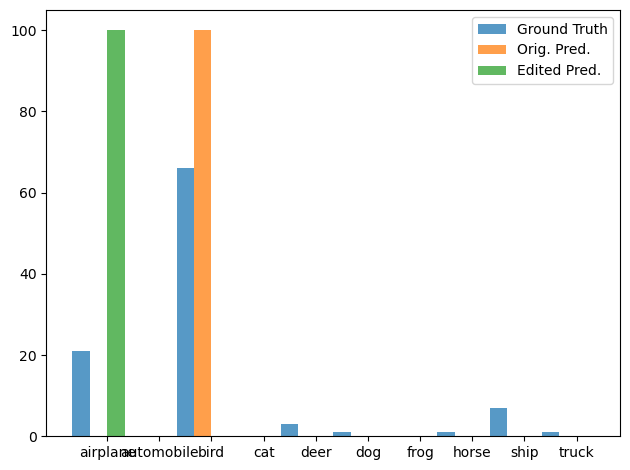

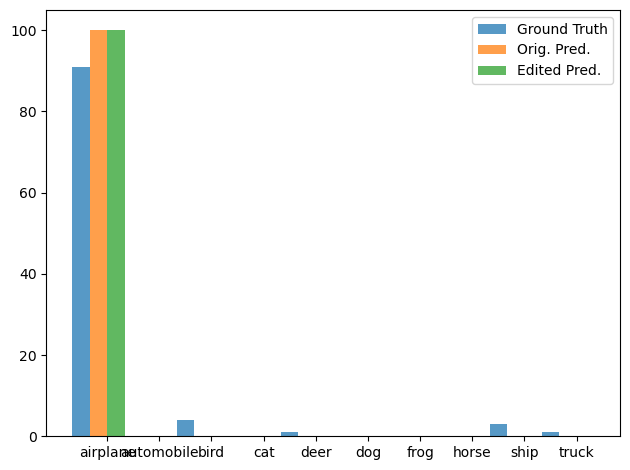

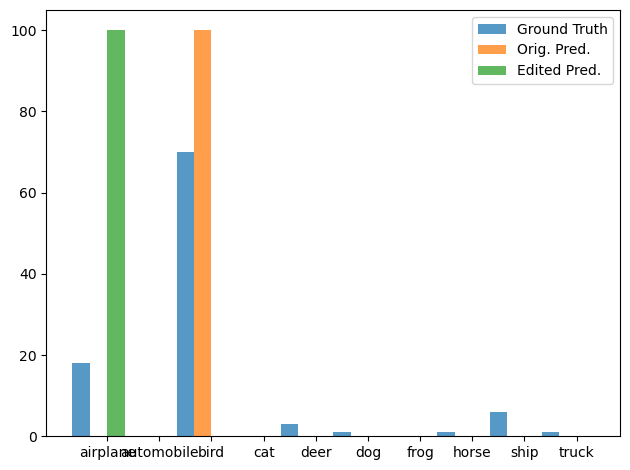

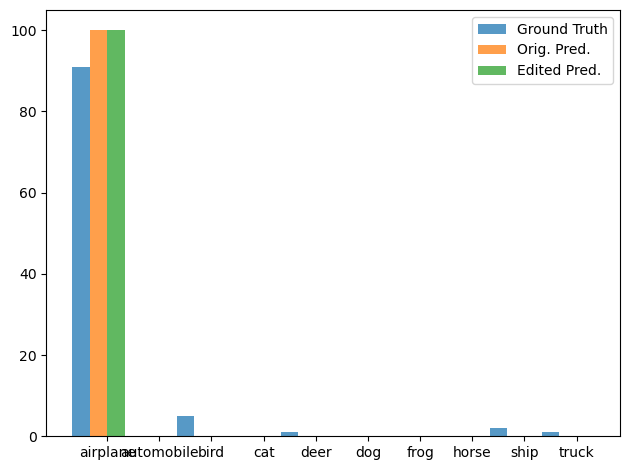

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_masked_softmax/models
Finished trial 46/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_masked_softmax
(0126_180859) Starting Trial 47/158...
Current run_id: 0126_170417/results/airplane-train-n03798610_853/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.50it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 882.65it/s]

Loss (orig, final): 0.07814180850982666 0.0028361757285892963
L2 norm of weight change: 0.26996368169784546
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 15.19it/s]


Post-edit metrics: {'TP': array([6382, 5318, 4393, 4098, 4312, 2811, 5696, 5093, 4698, 4714]), 'TN': array([58225, 61162, 61181, 59355, 59970, 61988, 61058, 61718, 61784,
       61074]), 'FPs': array([4775, 1838, 1819, 3645, 3030, 1012, 1942, 1282, 1216, 1926]), 'FNs': array([ 618, 1682, 2607, 2902, 2688, 4189, 1304, 1907, 2302, 2286]), 'accuracy': 0.6787857142857143, 'per_class_accuracy': array([0.92295714, 0.94971429, 0.93677143, 0.90647143, 0.91831429,
       0.9257    , 0.95362857, 0.95444286, 0.94974286, 0.93982857]), 'per_class_accuracy_mean': 0.935757142857143, 'precision': array([0.57201757, 0.7431526 , 0.70717965, 0.52925223, 0.58730591,
       0.73528642, 0.74574496, 0.79890196, 0.7943862 , 0.70993976]), 'precision_mean': 0.692316726370436, 'recall': array([0.91171429, 0.75971429, 0.62757143, 0.58542857, 0.616     ,
       0.40157143, 0.81371429, 0.72757143, 0.67114286, 0.67342857]), 'recall_mean': 0.6787857142857143, 'predicted_class_distribution': array([11157,  7156,  6212

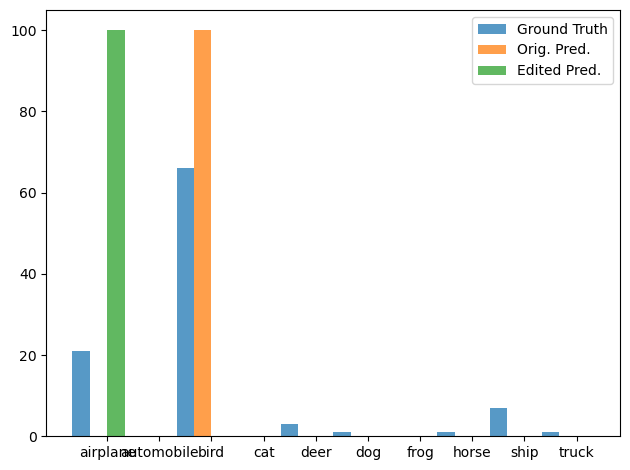

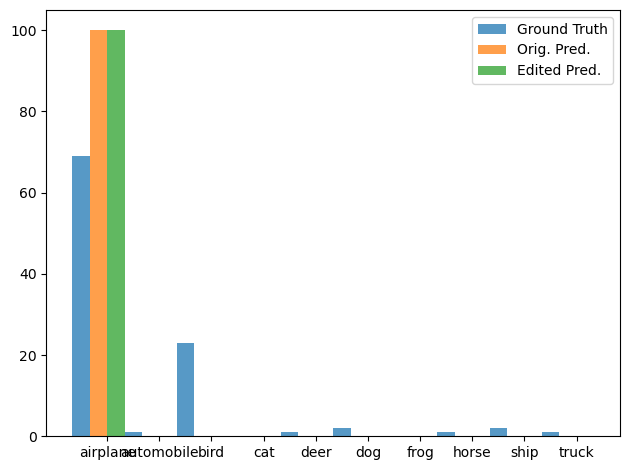

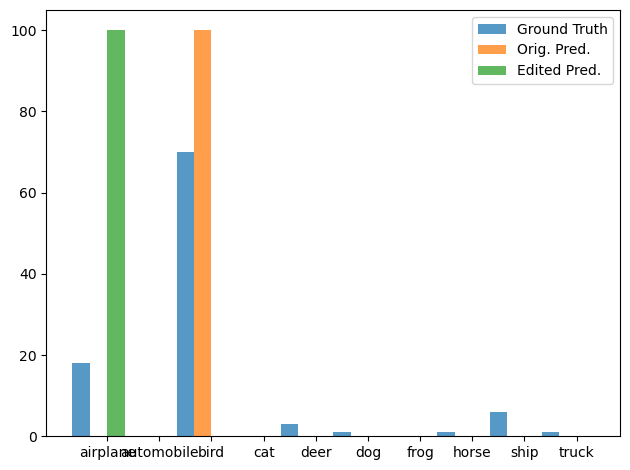

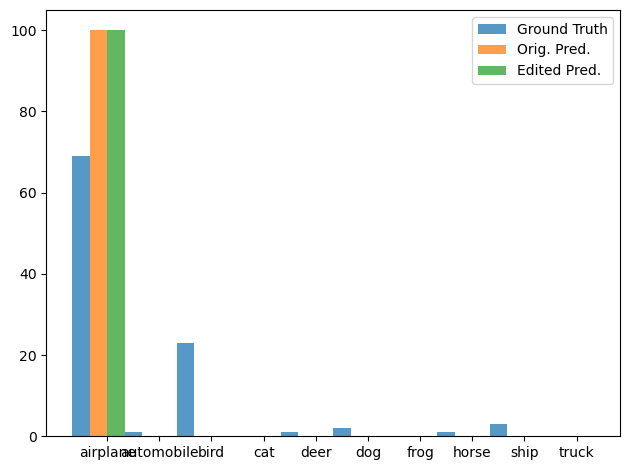

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_gaussian_softmax/models
Finished trial 47/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03798610_853/felzenszwalb_gaussian_softmax
(0126_181015) Starting Trial 48/158...
Current run_id: 0126_170417/results/airplane-train-n03174079_2322/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03174079_2322/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
K

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.63it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:48<00:00, 831.95it/s]

Loss (orig, final): 0.12989699840545654 0.0032066558487713337
L2 norm of weight change: 0.5123267769813538
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.55it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6511, 5293,    0, 4106, 4269, 2730, 5525, 5000, 4558, 4704]), 'TN': array([50667, 61207, 63000, 59423, 60048, 62088, 61475, 61828, 61910,
       61050]), 'FPs': array([12333,  1793,     0,  3577,  2952,   912,  1525,  1172,  1090,
        1950]), 'FNs': array([ 489, 1707, 7000, 2894, 2731, 4270, 1475, 2000, 2442, 2296]), 'accuracy': 0.6099428571428571, 'per_class_accuracy': array([0.81682857, 0.95      , 0.9       , 0.90755714, 0.91881429,
       0.92597143, 0.95714286, 0.95468571, 0.94954286, 0.93934286]), 'per_class_accuracy_mean': 0.9219885714285715, 'precision': array([0.34552112, 0.74696585, 0.        , 0.53442666, 0.59119236,
       0.74958814, 0.78368794, 0.81011017, 0.80701133, 0.70694319]), 'precision_mean': 0.6075446760957309, 'recall': array([0.93014286, 0.75614286, 0.        , 0.58657143, 0.60985714,
       0.39      , 0.78928571, 0.71428571, 0.65114286, 0.672     ]), 'recall_mean': 0.6099428571428571, 'predicted_class_distribution': array([

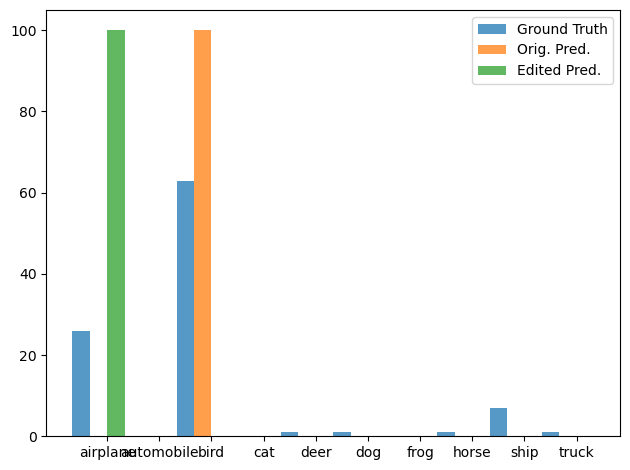

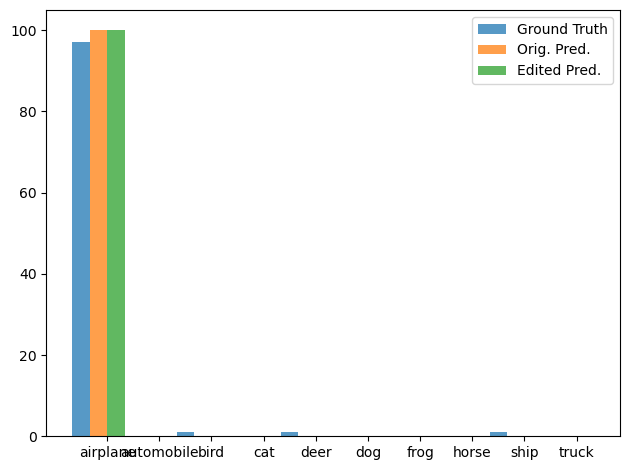

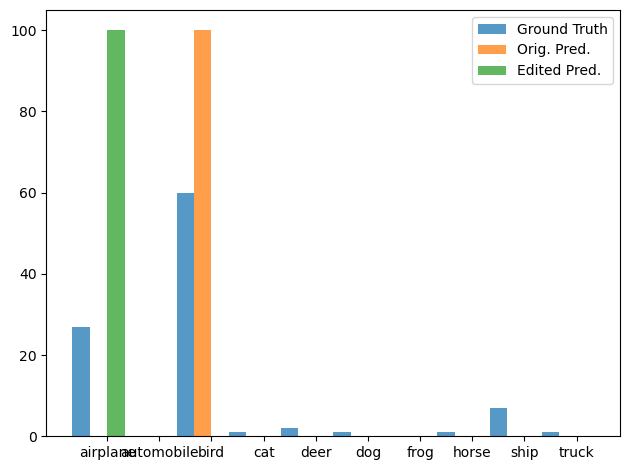

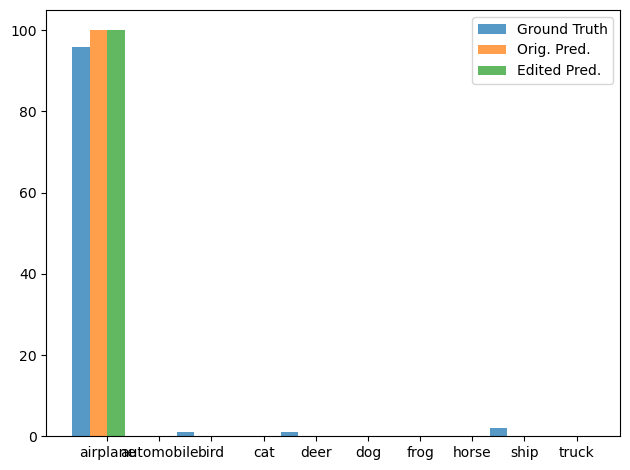

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03174079_2322/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03174079_2322/felzenszwalb_masked_softmax/models
Finished trial 48/158. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03174079_2322/felzenszwalb_masked_softmax
(0126_181129) Starting Trial 49/158...
Current run_id: 0126_170417/results/airplane-train-n03174079_2322/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0126_170417/results/airplane-train-n03174079_2322/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.


 30%|█████████████████████▏                                                | 83/274 [00:02<00:04, 45.01it/s]

In [ ]:
# for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
#     split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
#     class_name = os.path.basename(os.path.dirname(key_path))
#     file_name = os.path.basename(key_path).split(".")[0]
#     key_image_id = "{}-{}-{}".format(class_name, split, file_name)
#     # Print Progress
#     informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)
    
#     # Create run id 
#     value_image_id = os.path.splitext(os.path.basename(value_path))[0]
#     run_id = os.path.join('{}_{}'.format(target_class_name, n_select), timestamp, 'results', key_image_id, value_image_id)
#     informal_log("Current run_id: {}".format(run_id), progress_report_path)
    
#     # Read config file as json and make updates to key and value paths
#     config_dict = read_json(config_path)
#     config_dict['editor'].update({
#         'key_paths_file': key_path,
#         'value_paths_file': value_path
#     })
    
#     # Create config object
#     config = ConfigParser(config_dict, run_id=run_id)
    
#     # Log the current trial path
#     informal_log(os.path.dirname(config.save_dir), save_trials_path)
    
#     informal_log("Calling edit()...", progress_report_path)
    
#     edit(
#         config=config,
#         val_paths_data_loader=val_paths_data_loader,
#         covariance_data_loader=covariance_data_loader,
#         do_analyze_knn=analyze_in_edit)
    
#     # Print progress
#     informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
#                 progress_report_path)


## FIN

In [5]:
save_trials_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/trial_paths.txt'
trial_dirs = read_lists(save_trials_path)
knn_analysis_filename = 'knn_analysis_results.pth'

In [6]:
try:
    if not os.path.exists(save_trials_path):
        print("Path {} does not exist".format(save_trials_path))
    else:
        print("Obtaining trial paths from {}".format(save_trials_path))
except:
    print("Need to define save_trials_path.")



Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/trial_paths.txt


## Analyze KNN

In [ ]:
## Process KNN results for each
n_trials = len(trial_dirs)
n_log = n_trials // 10 + 1  # log every 10%
progress_report_path = os.path.join(os.path.dirname(save_trials_path), 'progress_report_analysis.txt')

informal_log("Starting KNN analysis...", progress_report_path)
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # if trial_idx % n_log == 0:
    informal_log("Processing {}/{} trials. Currently processing {}".format(
        trial_idx+1, n_trials, os.path.basename(trial_dir)), progress_report_path)
                     
    results_save_dir = os.path.join(trial_dir, 'models')
    load_and_analyze_knn(
        restore_dir=results_save_dir,
        pre_edit_knn_path=os.path.join(results_save_dir, 'pre_edit_{}-nn.pth'.format(K)),
        post_edit_knn_path=os.path.join(results_save_dir, 'post_edit_{}-nn.pth'.format(K)),
        knn_analysis_filename=knn_analysis_filename,
        target_class_idx=target_class_idx,
        class_list=class_list,
        progress_report_path=progress_report_path,
        save_images=False,
        save_plots=True)
    


## Convert to CSV for all trials

In [15]:
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
store_csv(
    trial_dirs=trial_dirs,
    class_list=class_list,
    save_path=csv_save_path)


67it [00:00, 213.64it/s]


Saved CSV to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results_table.csv


ID  Pre Accuracy  \
0   cat-train-n02123159_5240/felzenszwalb_masked_s...      0.687414   
1   cat-train-n02123159_5240/felzenszwalb_gaussian...      0.687414   
2   cat-train-n02129837_1765/felzenszwalb_masked_s...      0.687414   
3   cat-train-n02129923_8962/felzenszwalb_masked_s...      0.687414   
4   cat-train-n02129923_8962/felzenszwalb_gaussian...      0.687414   
..                                                ...           ...   
62  cat-train-n02127808_5137/felzenszwalb_masked_s...      0.687414   
63  cat-train-n02129991_438/felzenszwalb_masked_so...      0.687414   
64  cat-train-n02126640_2067/felzenszwalb_masked_s...      0.687414   
65  cat-train-n02129463_8239/felzenszwalb_masked_s...      0.687414   
66  cat-train-n01322898_1027/felzenszwalb_masked_s...      0.687414   

    Post Accuracy  Pre Mean Precision  Post Mean Precision  Pre Mean Recall  \
0        0.672186            0.692406             0.709197         0.687414   
1        0.633886            0.692406             0.598608         0.687414   
2        0.607971            0.692406             0.646743         0.687414   
3        0.632857            0.692406             0.623802         0.687414   
4        0.686829            0.692406             0.694383         0.687414   
..            ...                 ...                  ...              ...   
62       0.576271            0.692406             0.631007         0.687414   
63       0.673171            0.692406             0.695573         0.687414   
64       0.450029            0.692406             0.573060         0.687414   
65       0.635029            0.692406             0.611812         0.687414   
66       0.485729            0.692406             0.606418         0.687414   

    Post Mean Recall  Pre Mean F1  Post Mean F1  Pre Target Precision  ...  \
0           0.672186     0.683682      0.670420              0.553299  ...   
1           0.633886     0.683682      0.603072              0.553299  ...   
2           0.607971     0.683682      0.596876              0.553299  ...   
3           0.632857     0.683682      0.611744              0.553299  ...   
4           0.686829     0.683682      0.684031              0.553299  ...   
..               ...          ...           ...                   ...  ...   
62          0.576271     0.683682      0.549253              0.553299  ...   
63          0.673171     0.683682      0.665643              0.553299  ...   
64          0.450029     0.683682      0.453774              0.553299  ...   
65          0.635029     0.683682      0.608942              0.553299  ...   
66          0.485729     0.683682      0.480233              0.553299  ...   

    Pre key-valN (L)  Post key-valN (L)  Pre key-keyN (F)  Post key-keyN (F)  \
0           5.171321           3.169234          0.596380           0.594950   
1           8.166020           2.563223          0.596380           0.523944   
2           6.564913           2.954387          0.935025           0.774271   
3           5.371199           2.632539          0.763008           0.722909   
4           1.375438           1.304161          0.763008           0.755527   
..               ...                ...               ...                ...   
62          8.245894           2.834608          0.584197           0.395530   
63          8.212924           3.519887          0.823938           0.616917   
64          7.195724           5.414852          1.244950           1.043974   
65          8.692849           4.320444          0.183258           0.187100   
66          7.628166           4.563941          1.131386           0.882368   

    Pre key-keyN (L)  Post key-keyN (L)  Pre val-valN (F)  Post val-valN (F)  \
0           0.710303           0.703269          0.723165           0.660501   
1           0.710303           0.591248          1.175095           1.062049   
2           1.173931           0.908001          0.107244           0.119450   
3           0.921382           